In [7]:
!uv add polars


Resolved 165 packages in 1ms
Audited 147 packages in 0.53ms


In [8]:
import polars as pl
import json

def load_analysis_data(file_path="layer30_analysis.json"):
    """Load analysis data using Polars lazy evaluation."""
    
    # First read the JSON structure
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Create records for step-level analysis
    step_records = []
    for result in data['results']:
        for step_idx, step_info in enumerate(result['step_features']):
            record = {
                'prompt': result['prompt'],
                'category': result['category'],
                'step_number': step_idx,
                'step_text': result['steps'][step_idx] if step_idx < len(result['steps']) else '',
                'relative_position': step_idx / len(result['steps']),
                
                # Basic activation stats
                'mean_activation': step_info['mean_activation'],
                'max_activation': step_info['max_activation'],
                'min_activation': step_info['min_activation'],
                
                # Max/Min feature info
                'max_feature_idx': step_info['max_feature']['index'],
                'max_feature_val': step_info['max_feature']['value'],
                'min_feature_idx': step_info['min_feature']['index'],
                'min_feature_val': step_info['min_feature']['value'],
                
                # Problem metadata
                'generated_answer': result['generated_answer'],
                'ground_truth': result['ground_truth'],
                'matches_dataset': result['matches_dataset'],
                'dataset_says_correct': result['dataset_says_correct']
            }
            
            # Add top positive features
            for i, feat in enumerate(step_info['top_positive_features']):
                record[f'pos_feat_{i}_idx'] = feat['index']
                record[f'pos_feat_{i}_val'] = feat['value']
            
            # Add top negative features
            for i, feat in enumerate(step_info['top_negative_features']):
                record[f'neg_feat_{i}_idx'] = feat['index']
                record[f'neg_feat_{i}_val'] = feat['value']
            
            step_records.append(record)
    
    # Create schema
    schema = {
        'prompt': pl.String,
        'category': pl.String,
        'step_number': pl.Int32,
        'step_text': pl.String,
        'relative_position': pl.Float64,
        'mean_activation': pl.Float64,
        'max_activation': pl.Float64,
        'min_activation': pl.Float64,
        'max_feature_idx': pl.Int32,
        'max_feature_val': pl.Float64,
        'min_feature_idx': pl.Int32,
        'min_feature_val': pl.Float64,
        'generated_answer': pl.String,
        'ground_truth': pl.String,
        'matches_dataset': pl.Boolean,
        'dataset_says_correct': pl.Boolean
    }
    
    # Add schema for top features
    for i in range(10):  # top_k=10 from original code
        schema[f'pos_feat_{i}_idx'] = pl.Int32
        schema[f'pos_feat_{i}_val'] = pl.Float64
        schema[f'neg_feat_{i}_idx'] = pl.Int32
        schema[f'neg_feat_{i}_val'] = pl.Float64
    
    # Create LazyFrame
    return pl.DataFrame(step_records, schema=schema).lazy()

def analyze_features(lf):
    """Create analysis queries."""
    return {
        # Feature activation patterns
        'feature_stats': (
            lf.group_by('max_feature_idx')
            .agg([
                pl.count().alias('activation_count'),
                pl.col('max_feature_val').mean().alias('mean_activation'),
                pl.col('max_feature_val').std().alias('std_activation'),
                pl.col('relative_position').mean().alias('avg_position')
            ])
            .sort('activation_count', descending=True)
        ),
        
        # Feature 2352 analysis
        'feature_2352_steps': (
            lf.filter(pl.col('max_feature_idx') == 2352)
            .group_by(['step_number', 'prompt'])
            .agg([
                pl.col('max_feature_val').alias('activation'),
                pl.col('step_text').first().alias('step_text')
            ])
            .sort(['prompt', 'step_number'])
        ),
        
        # Negative feature patterns
        'top_negative_features': (
            lf.select([
                pl.col('min_feature_idx'),
                pl.col('min_feature_val'),
                pl.col('step_text'),
                pl.col('relative_position')
            ])
            .group_by('min_feature_idx')
            .agg([
                pl.count().alias('count'),
                pl.col('min_feature_val').mean().alias('avg_negative_val'),
                pl.col('relative_position').mean().alias('avg_position')
            ])
            .sort('count', descending=True)
        )
    }

# Usage
lf = load_analysis_data()
queries = analyze_features(lf)

# Execute specific queries
top_features = queries['feature_stats'].collect()
feature_2352_analysis = queries['feature_2352_steps'].collect()
negative_patterns = queries['top_negative_features'].collect()

/var/folders/f9/q60hmfgd2lx3_mpq6kwg9_980000gn/T/ipykernel_5866/3826975761.py:89: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('activation_count'),
/var/folders/f9/q60hmfgd2lx3_mpq6kwg9_980000gn/T/ipykernel_5866/3826975761.py:118: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('count'),


In [9]:
top_features

shape: (1_260, 5)
┌─────────────────┬──────────────────┬─────────────────┬────────────────┬──────────────┐
│ max_feature_idx ┆ activation_count ┆ mean_activation ┆ std_activation ┆ avg_position │
│ ---             ┆ ---              ┆ ---             ┆ ---            ┆ ---          │
│ i32             ┆ u32              ┆ f64             ┆ f64            ┆ f64          │
╞═════════════════╪══════════════════╪═════════════════╪════════════════╪══════════════╡
│ 290             ┆ 24187            ┆ 4.631601        ┆ 1.182124       ┆ 5.95506      │
│ 3881            ┆ 23506            ┆ 4.884226        ┆ 1.050513       ┆ 12.459181    │
│ 2219            ┆ 19434            ┆ 4.772992        ┆ 1.043282       ┆ 10.817343    │
│ 761             ┆ 17871            ┆ 5.600105        ┆ 1.316637       ┆ 10.017464    │
│ 133             ┆ 16106            ┆ 4.217756        ┆ 0.956111       ┆ 15.478623    │
│ …               ┆ …                ┆ …               ┆ …              ┆ …            │
│ 2468            ┆ 1                ┆ 2.619141        ┆ null           ┆ 8.612476     │
│ 515             ┆ 1                ┆ 3.140625        ┆ null           ┆ 13.391304    │
│ 2882            ┆ 1                ┆ 2.337891        ┆ null           ┆ 0.520124     │
│ 1277            ┆ 1                ┆ 2.650391        ┆ null           ┆ 6.13245      │
│ 765             ┆ 1                ┆ 3.058594        ┆ null           ┆ 13.222689    │
└─────────────────┴──────────────────┴─────────────────┴────────────────┴──────────────┘

In [10]:
def clean_step_text(text):
    """Clean LaTeX and other special characters from step text."""
    import re
    # Remove LaTeX math mode
    text = re.sub(r'\$.*?\$', '[MATH]', text)
    # Remove LaTeX commands
    text = re.sub(r'\\[a-zA-Z]+', '', text)
    # Remove curly braces
    text = re.sub(r'[{}]', '', text)
    # Clean up whitespace
    text = ' '.join(text.split())
    return text

# Load and clean data
lf = (load_analysis_data()
      .with_columns([
          pl.col('step_text').map(clean_step_text).alias('clean_step_text')
      ]))


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x112509c90>>
Traceback (most recent call last):
  File "/Users/darklight/Interning/Research/MATs/ThinkingChainMechInterp/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


AttributeError: 'Expr' object has no attribute 'map'

In [ ]:
#realize that the schema is wrong.. 
feature_2352_analysis = (
    lf.filter(pl.col('max_feature_idx') == 2352)
    .group_by(['prompt', 'step_number'])
    .agg([
        pl.col('max_feature_val').alias('activation'),
        pl.col('clean_step_text').first().alias('step'),
        pl.col('relative_position').first().alias('position')
    ])
    .sort(['prompt', 'step_number'])
    .collect()
)

ColumnNotFoundError: clean_step_text

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sort' <---
FILTER [(col("max_feature_idx")) == (2352)] FROM
  DF ["prompt", "category", "step_number", "step_text"]; PROJECT */56 COLUMNS

In [ ]:
import json
import pprint

with open('layer30_analysis.json', 'r') as f:
    data = json.load(f)

print('keys in the json: ', data.keys())
print('\nNumber of results:', len(data['results']))
print('\nFirst result structure:')
pprint.pprint(data['results'][0], depth=2)

# To see the full structure of one result
print("\nComplete structure of first result:")
pprint.pprint(data['results'][0])

# To see unique keys/structure
def get_structure(d, depth=0, max_depth=100):
    if depth >= max_depth:
        return "..."
    if isinstance(d, dict):
        return {k: get_structure(v, depth + 1) for k, v in d.items()}
    if isinstance(d, list) and d:
        return [get_structure(d[0], depth + 1)]
    return type(d).__name__

print("\nJSON Structure:")
pprint.pprint(get_structure(data))

keys in the json:  dict_keys(['results', 'metadata'])

Number of results: 50

First result structure:
{'activations': [-0.10442297905683517,
                 -0.0013057119213044643,
                 -0.0036739185452461243,
                 -0.004113773815333843,
                 0.01480528712272644,
                 0.00015458744019269943,
                 0.005072581581771374,
                 0.010034829378128052,
                 0.01514438632875681,
                 0.0074464380741119385,
                 0.007024453952908516,
                 -0.010245111770927906,
                 0.0017914175987243652,
                 0.004097119905054569,
                 -0.0031599998474121094,
                 0.007790805771946907,
                 -0.0018366677686572075,
                 0.001502305269241333,
                 -0.005548777058720589,
                 -0.006330037489533424,
                 0.009894297458231449,
                 0.016542332246899605,
                 0.0045427

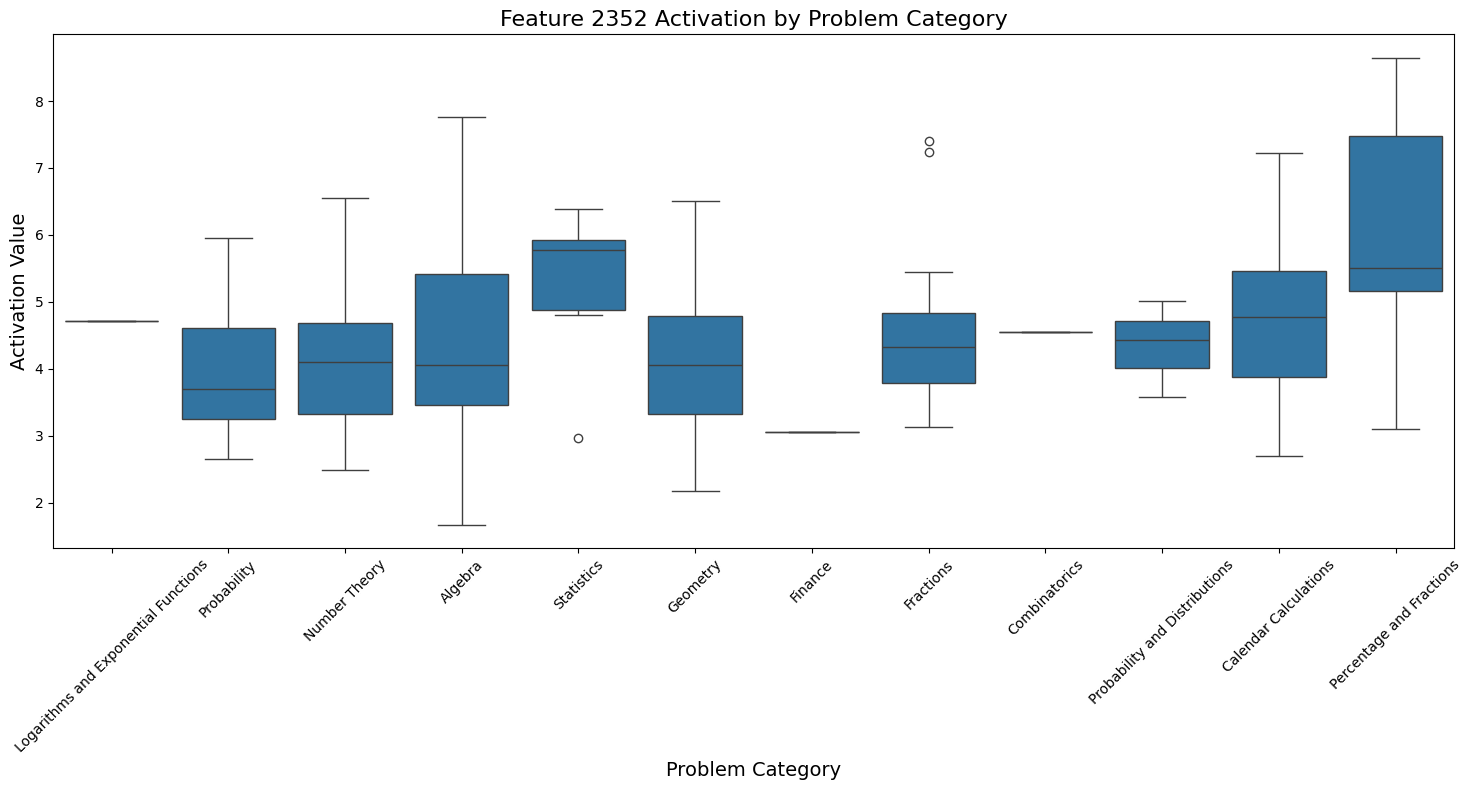

/var/folders/f9/q60hmfgd2lx3_mpq6kwg9_980000gn/T/ipykernel_94294/1866816038.py:123: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  activation_by_position = feature_2352_df.groupby('position_bin')['max_feature_val'].mean().reset_index()


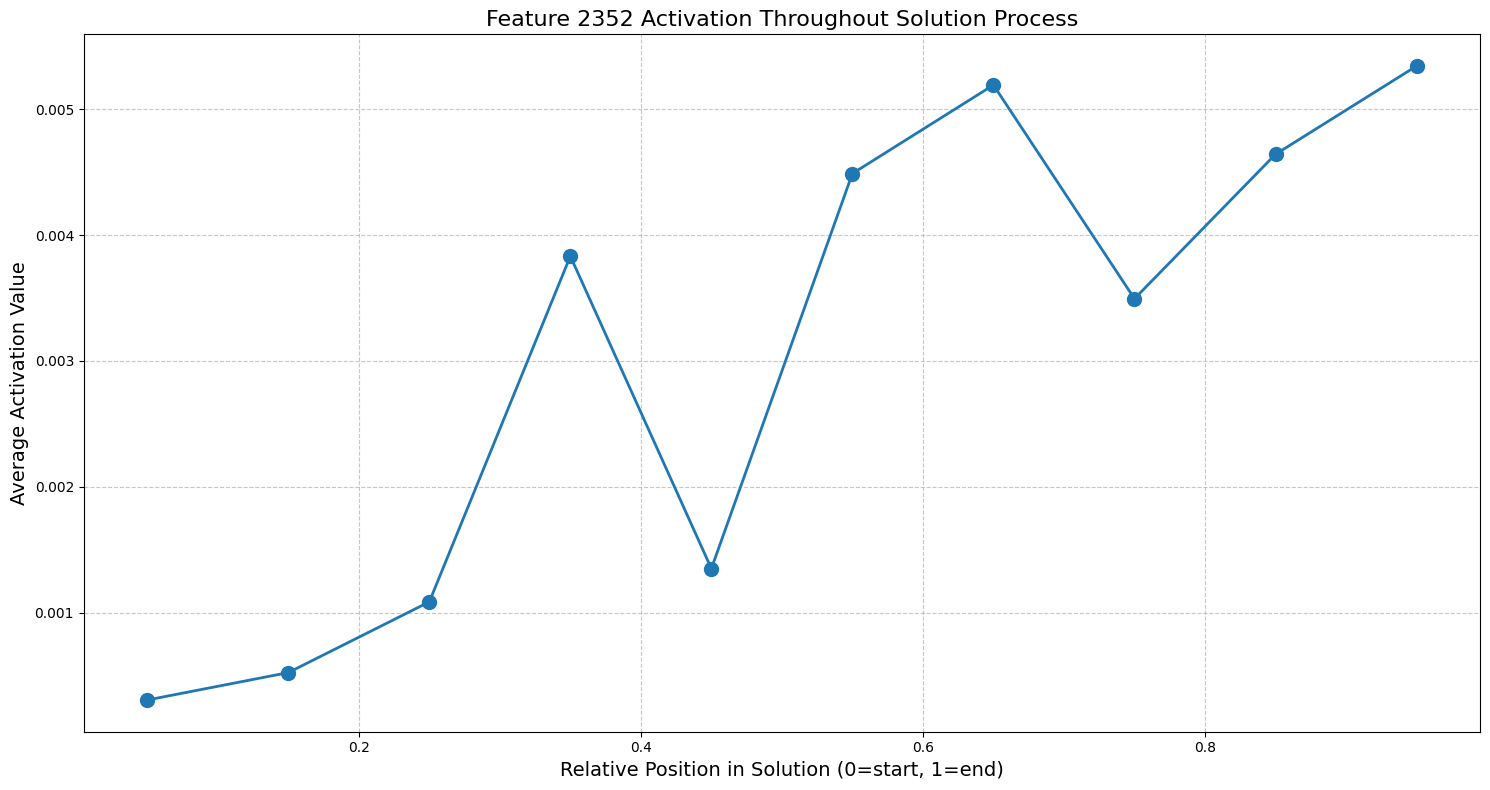

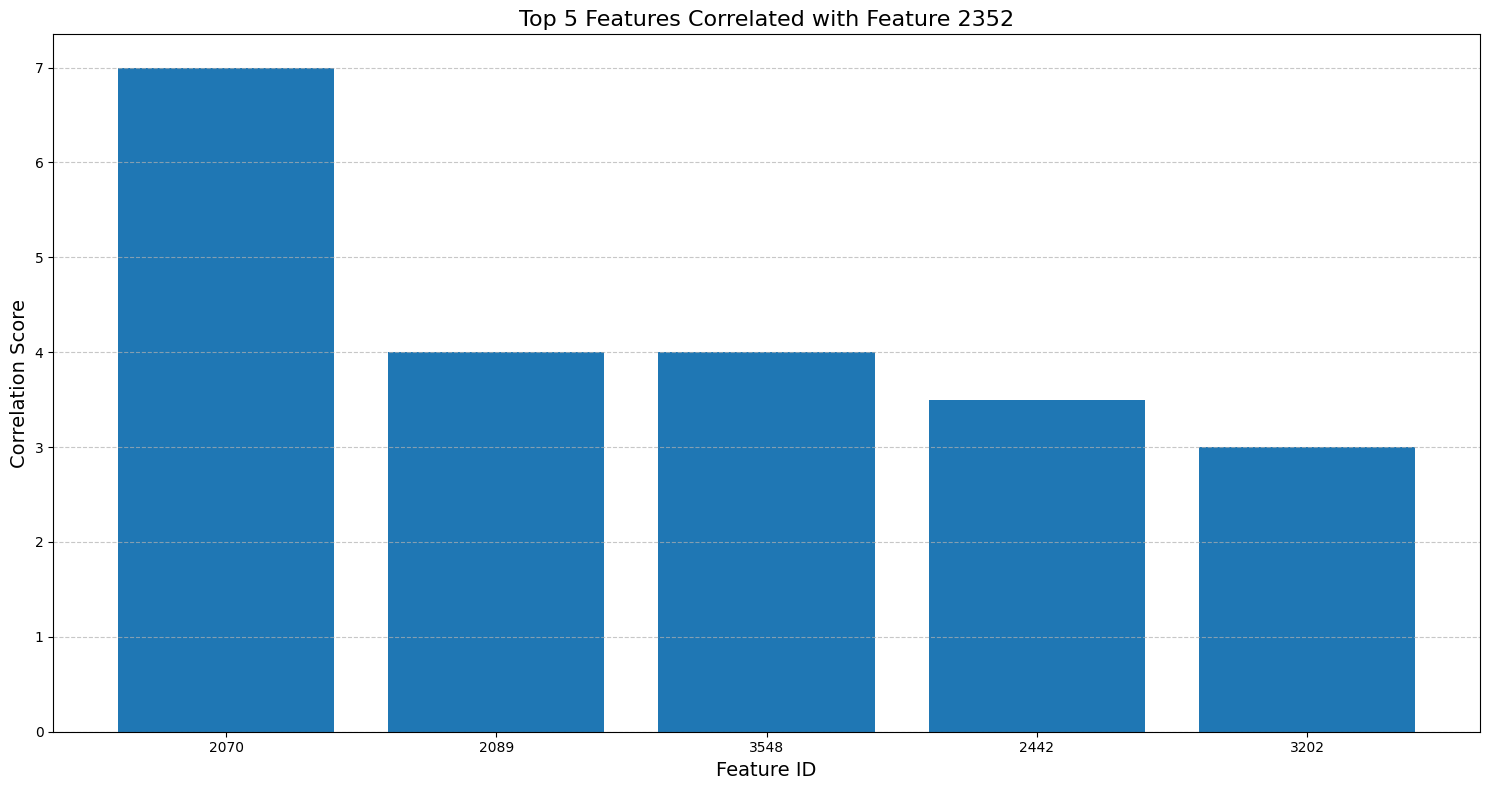

/var/folders/f9/q60hmfgd2lx3_mpq6kwg9_980000gn/T/ipykernel_94294/1866816038.py:151: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = feature_2352_df.pivot_table(


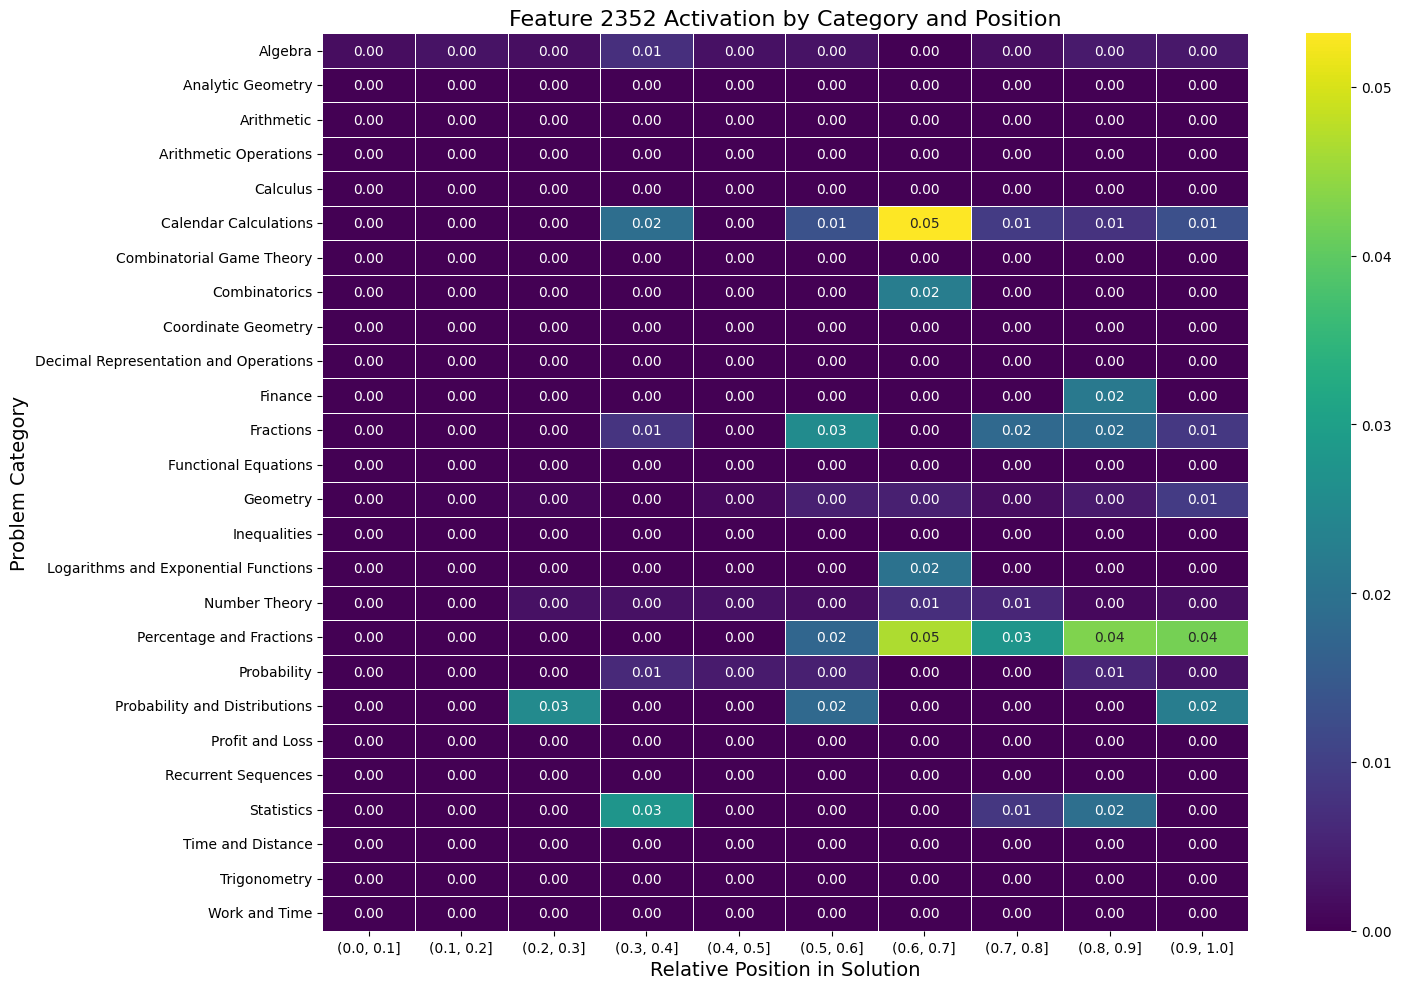

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
#It was also at this point when I gave up on trying to continue with polars.
# Load the data
with open('layer30_analysis.json', 'r') as f:
    data = json.load(f)

# 1. Process data for Feature 2352 analysis
def extract_feature_data(data, feature_id=2352):
    """Extract data for a specific feature across all problems."""
    feature_data = []
    
    for result_idx, result in enumerate(data['results']):
        # Get problem metadata
        problem_id = result_idx
        category = result['category']
        is_correct = result['matches_dataset']
        
        # Process each step
        for step_idx, step_feature in enumerate(result['step_features']):
            # Calculate relative position in solution
            relative_pos = step_idx / len(result['step_features'])
            
            # Check if this feature is the max feature
            is_max_feature = step_feature['max_feature']['index'] == feature_id
            max_feature_val = step_feature['max_feature']['value'] if is_max_feature else 0
            
            # Check if feature appears in top positive features
            pos_feature_val = 0
            for feat in step_feature['top_positive_features']:
                if feat['index'] == feature_id:
                    pos_feature_val = feat['value']
                    break
            
            # Check if feature appears in top negative features
            neg_feature_val = 0
            for feat in step_feature['top_negative_features']:
                if feat['index'] == feature_id:
                    neg_feature_val = feat['value']
                    break
            
            # Store data
            feature_data.append({
                'problem_id': problem_id,
                'category': category,
                'is_correct': is_correct,
                'step_idx': step_idx,
                'relative_pos': relative_pos,
                'is_max_feature': is_max_feature,
                'max_feature_val': max_feature_val,
                'pos_feature_val': pos_feature_val,
                'neg_feature_val': neg_feature_val,
                'step_text': result['steps'][step_idx] if step_idx < len(result['steps']) else ''
            })
    
    return pd.DataFrame(feature_data)

# 2. Find correlated features
def find_correlated_features(data, target_feature=2352, top_n=5):
    """Find features most correlated with target feature."""
    feature_correlations = defaultdict(lambda: {'co_activations': 0, 'total_activations': 0})
    
    for result in data['results']:
        for step_feature in result['step_features']:
            # Check if target feature is max
            if step_feature['max_feature']['index'] == target_feature:
                # Record min feature
                min_idx = step_feature['min_feature']['index']
                feature_correlations[min_idx]['co_activations'] += 1
            
            # Check if target feature is in top positive
            for feat in step_feature['top_positive_features']:
                if feat['index'] == target_feature:
                    # Record other top positive features
                    for other_feat in step_feature['top_positive_features']:
                        if other_feat['index'] != target_feature:
                            feature_correlations[other_feat['index']]['co_activations'] += 1
            
            # Count total activations for each feature
            feature_correlations[step_feature['max_feature']['index']]['total_activations'] += 1
    
    # Calculate correlation scores
    correlation_scores = []
    for feat_idx, stats in feature_correlations.items():
        if feat_idx != target_feature and stats['total_activations'] > 0:
            correlation_scores.append({
                'feature_id': feat_idx,
                'co_activations': stats['co_activations'],
                'total_activations': stats['total_activations'],
                'correlation_score': stats['co_activations'] / stats['total_activations']
            })
    
    # Sort by correlation score
    correlation_scores.sort(key=lambda x: x['correlation_score'], reverse=True)
    return correlation_scores[:top_n]

# Extract data
feature_2352_df = extract_feature_data(data, feature_id=2352)
correlated_features = find_correlated_features(data, target_feature=2352, top_n=5)

# Visualization 1: Feature 2352's activation across problem types
plt.figure(figsize=(15, 8))
sns.boxplot(x='category', y='max_feature_val', data=feature_2352_df[feature_2352_df['is_max_feature']])
plt.title('Feature 2352 Activation by Problem Category', fontsize=16)
plt.xlabel('Problem Category', fontsize=14)
plt.ylabel('Activation Value', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization 2: When Feature 2352 peaks in the solution process
plt.figure(figsize=(15, 8))

# Create bins for relative position
bins = np.linspace(0, 1, 11)  # 10 bins from 0 to 1
feature_2352_df['position_bin'] = pd.cut(feature_2352_df['relative_pos'], bins)

# Calculate average activation per bin
activation_by_position = feature_2352_df.groupby('position_bin')['max_feature_val'].mean().reset_index()

plt.plot(activation_by_position['position_bin'].apply(lambda x: x.mid), 
         activation_by_position['max_feature_val'], 
         marker='o', linewidth=2, markersize=10)

plt.title('Feature 2352 Activation Throughout Solution Process', fontsize=16)
plt.xlabel('Relative Position in Solution (0=start, 1=end)', fontsize=14)
plt.ylabel('Average Activation Value', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualization 3: Top correlated features
plt.figure(figsize=(15, 8))
correlated_df = pd.DataFrame(correlated_features)
plt.bar(correlated_df['feature_id'].astype(str), correlated_df['correlation_score'])
plt.title('Top 5 Features Correlated with Feature 2352', fontsize=16)
plt.xlabel('Feature ID', fontsize=14)
plt.ylabel('Correlation Score', fontsize=14)
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualization 4: Heatmap of Feature 2352 activation by category and position
plt.figure(figsize=(15, 10))
# Create a pivot table
heatmap_data = feature_2352_df.pivot_table(
    index='category', 
    columns='position_bin', 
    values='max_feature_val',
    aggfunc='mean'
)
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='.2f', linewidths=.5)
plt.title('Feature 2352 Activation by Category and Position', fontsize=16)
plt.xlabel('Relative Position in Solution', fontsize=14)
plt.ylabel('Problem Category', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
!uv pip install matplotlib seaborn

Resolved 15 packages in 152ms                                        
⠙ Preparing packages... (0/1)                                                   
⠙ Preparing packages... (0/1)----     0 B/288.00 KiB                    
⠙ Preparing packages... (0/1)---- 16.00 KiB/288.00 KiB                  
⠙ Preparing packages... (0/1)---- 32.00 KiB/288.00 KiB                  
⠙ Preparing packages... (0/1)---- 42.10 KiB/288.00 KiB                  
⠙ Preparing packages... (0/1)---- 58.10 KiB/288.00 KiB                  
⠙ Preparing packages... (0/1)---- 62.10 KiB/288.00 KiB                  
⠙ Preparing packages... (0/1)---- 78.10 KiB/288.00 KiB                  
⠙ Preparing packages... (0/1)---- 94.10 KiB/288.00 KiB                  
⠙ Preparing packages... (0/1)---- 110.10 KiB/288.00 KiB                 
⠙ Preparing packages... (0/1)---- 126.10 KiB/288.00 KiB                 
⠙ Preparing packages... (0/1)---- 142.10 KiB/288.00 KiB                 
⠙ Preparing packages... (0/1)---- 158.10 KiB/2

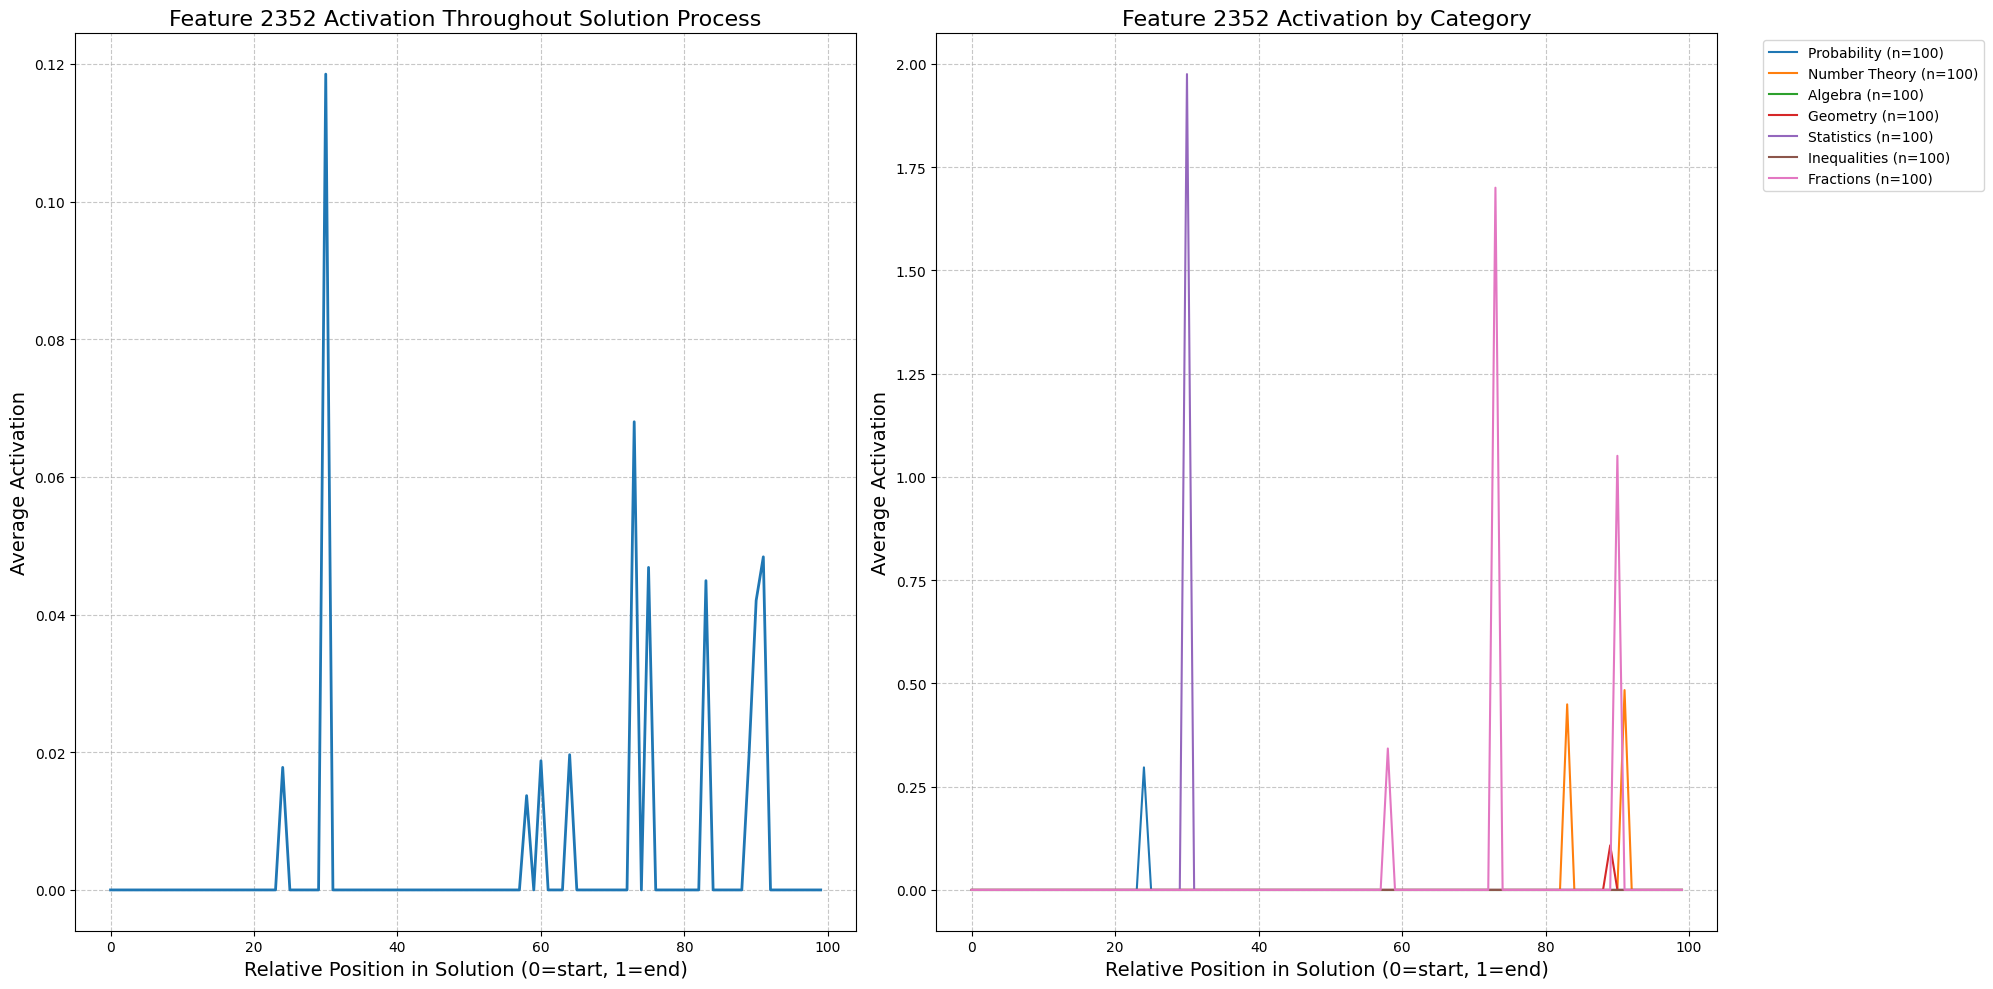

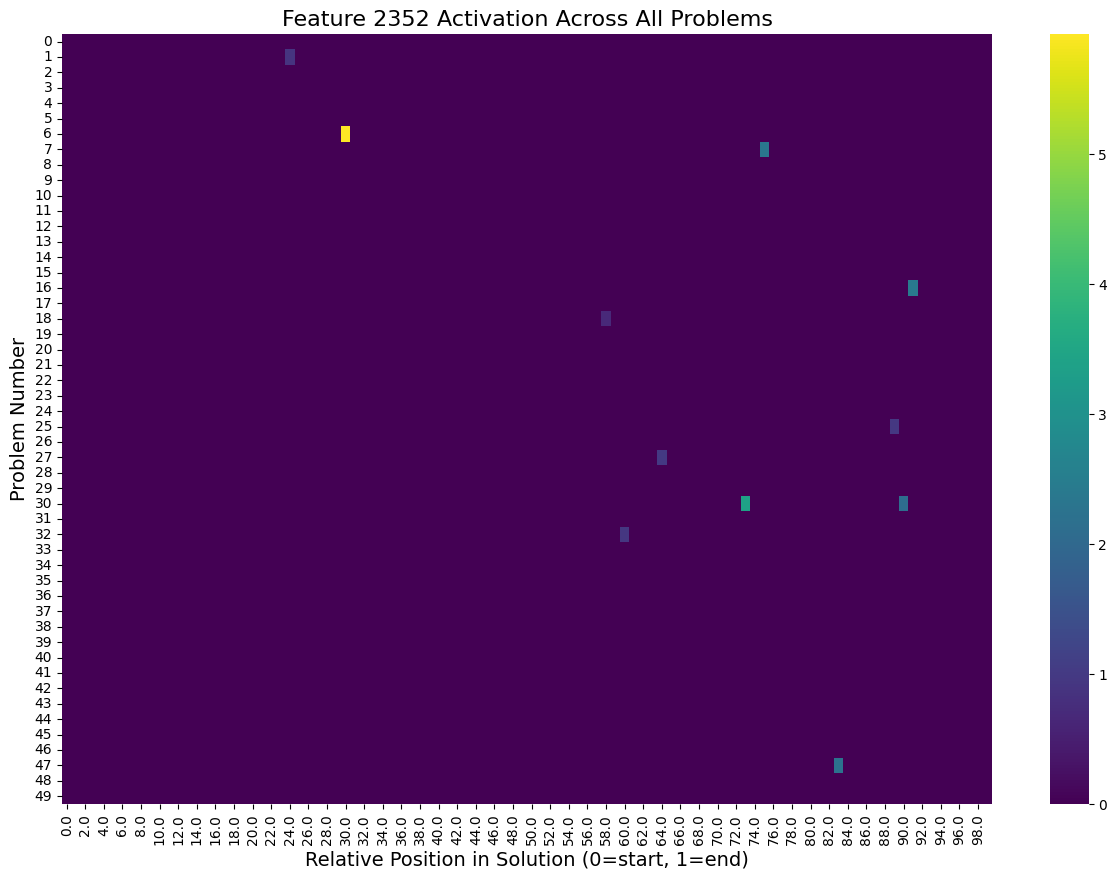

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
with open('layer30_analysis.json', 'r') as f:
    data = json.load(f)

# Process data to match the original analysis
def extract_feature_activation_patterns(data, feature_id=2352):
    """Extract when the feature is active throughout solutions."""
    feature_data = []
    
    for result_idx, result in enumerate(data['results']):
        problem_id = result_idx
        category = result['category']
        is_correct = result['matches_dataset']
        
        # Get activation pattern across all steps
        activations = []
        for step_idx, step_feature in enumerate(result['step_features']):
            # Check if feature appears anywhere in top features
            is_active = False
            activation_val = 0
            
            # Check max feature
            if step_feature['max_feature']['index'] == feature_id:
                is_active = True
                activation_val = step_feature['max_feature']['value']
            
            # Check top positive features
            for feat in step_feature['top_positive_features']:
                if feat['index'] == feature_id:
                    is_active = True
                    activation_val = max(activation_val, feat['value'])
            
            # Store step data
            activations.append(activation_val)
            
            # Also store individual step data for detailed analysis
            feature_data.append({
                'problem_id': problem_id,
                'category': category,
                'is_correct': is_correct,
                'step_idx': step_idx,
                'relative_pos': step_idx / len(result['step_features']),
                'activation': activation_val,
                'is_active': is_active
            })
        
        # Normalize to 100 steps for comparison
        if activations:
            x = np.linspace(0, len(activations)-1, 100)
            normalized = np.interp(x, np.arange(len(activations)), activations)
            
            # Store problem-level data
            for i, act_val in enumerate(normalized):
                feature_data.append({
                    'problem_id': problem_id,
                    'category': category,
                    'is_correct': is_correct,
                    'normalized_step': i,
                    'normalized_pos': i/100,
                    'normalized_activation': act_val,
                    'analysis_type': 'normalized'
                })
    
    return pd.DataFrame(feature_data)

# Extract data
feature_df = extract_feature_activation_patterns(data, feature_id=2352)

# Create visualizations that match the original analysis
plt.figure(figsize=(20, 10))

# 1. Activation pattern over time (matching the original right plot)
plt.subplot(1, 2, 1)
normalized_data = feature_df[feature_df['analysis_type'] == 'normalized']
temporal_pattern = normalized_data.groupby('normalized_step')['normalized_activation'].mean()

plt.plot(temporal_pattern.index, temporal_pattern.values, linewidth=2)
plt.title('Feature 2352 Activation Throughout Solution Process', fontsize=16)
plt.xlabel('Relative Position in Solution (0=start, 1=end)', fontsize=14)
plt.ylabel('Average Activation', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# 2. Activation by category (matching original left plot)
plt.subplot(1, 2, 2)
category_patterns = {}
for category in normalized_data['category'].unique():
    cat_data = normalized_data[normalized_data['category'] == category]
    if len(cat_data) > 100:  # Only include categories with enough data
        pattern = cat_data.groupby('normalized_step')['normalized_activation'].mean()
        category_patterns[category] = pattern

for category, pattern in category_patterns.items():
    plt.plot(pattern.index, pattern.values, label=f"{category} (n={len(pattern)})")

plt.title('Feature 2352 Activation by Category', fontsize=16)
plt.xlabel('Relative Position in Solution (0=start, 1=end)', fontsize=14)
plt.ylabel('Average Activation', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 3. Heatmap showing activation over time (all problems)
plt.figure(figsize=(15, 10))
problem_data = normalized_data.pivot_table(
    index='problem_id',
    columns='normalized_step',
    values='normalized_activation',
    aggfunc='mean'
)
sns.heatmap(problem_data, cmap='viridis')
plt.title('Feature 2352 Activation Across All Problems', fontsize=16)
plt.xlabel('Relative Position in Solution (0=start, 1=end)', fontsize=14)
plt.ylabel('Problem Number', fontsize=14)
plt.show()

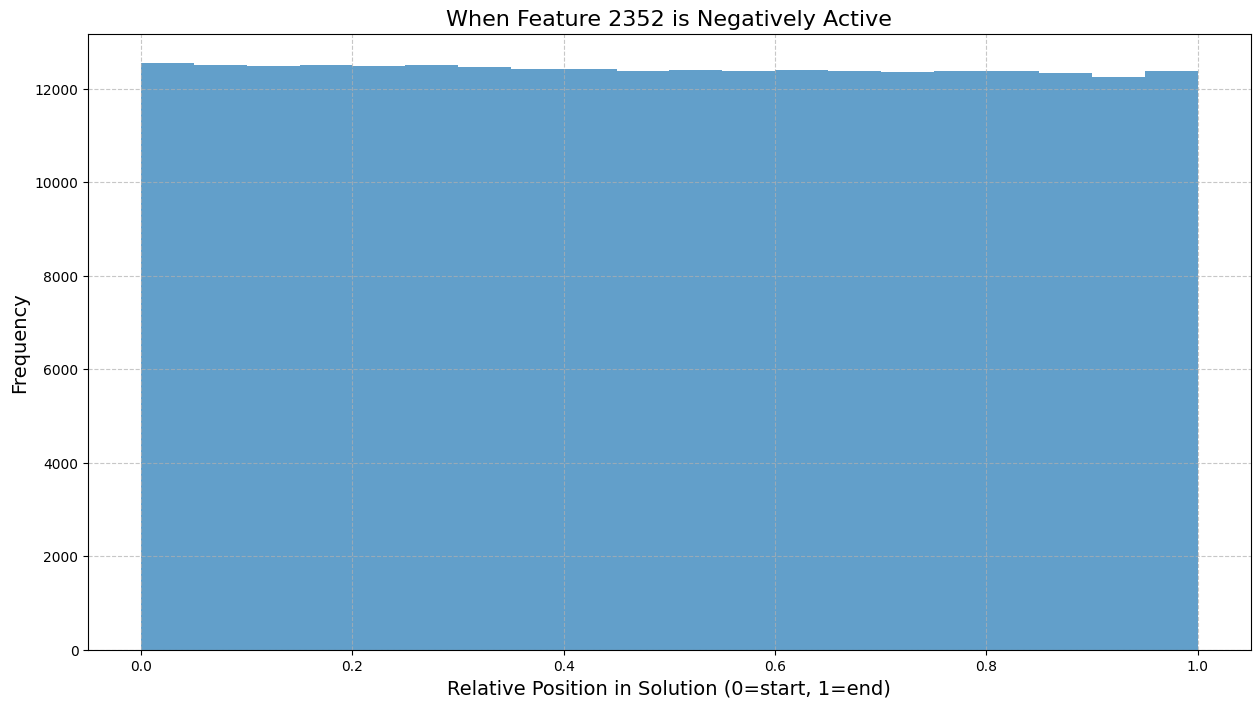

/var/folders/f9/q60hmfgd2lx3_mpq6kwg9_980000gn/T/ipykernel_94294/3030944071.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  activation_by_position = negative_df.groupby('position_bin')['negative_value'].mean().reset_index()


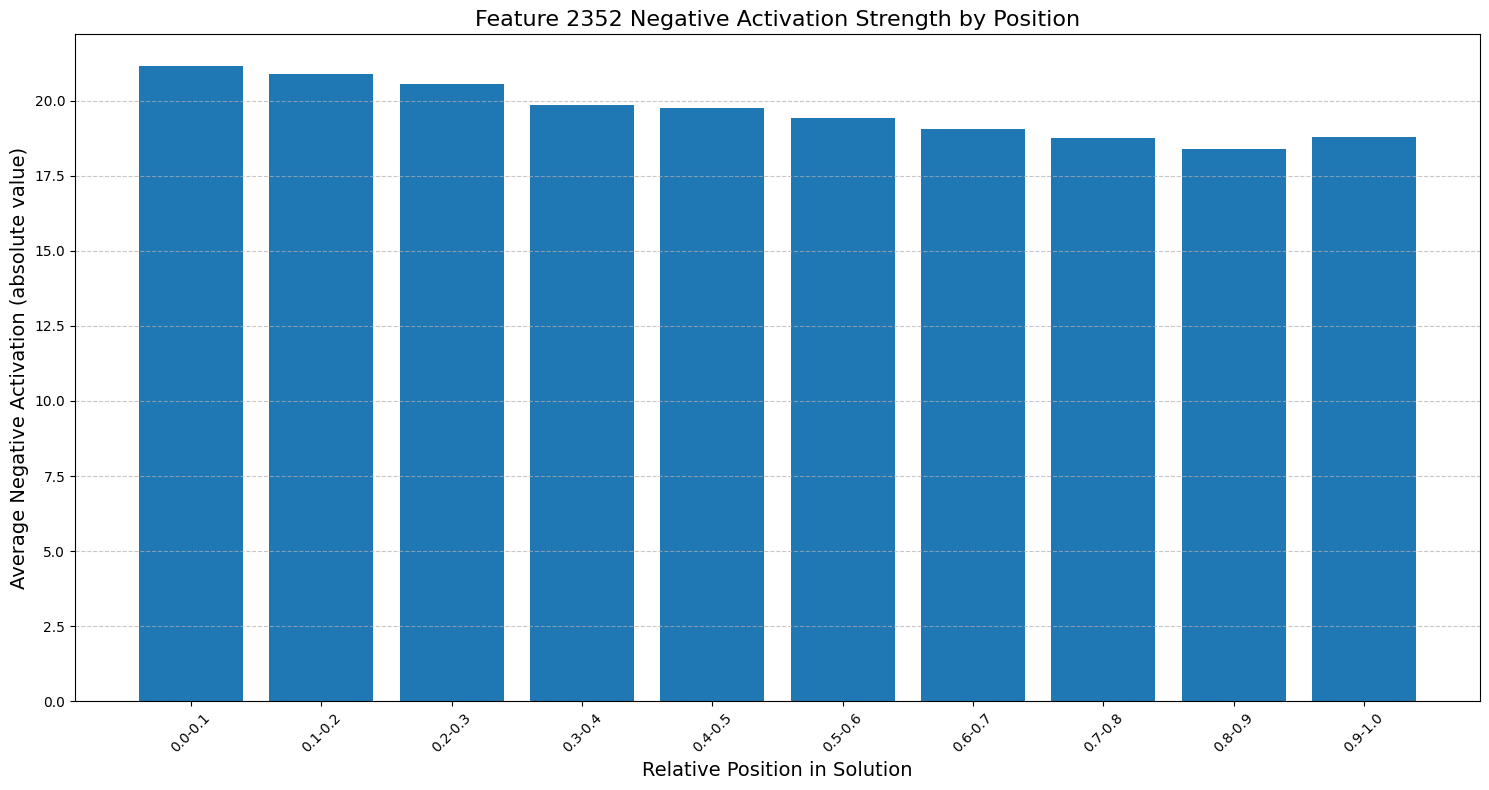

/var/folders/f9/q60hmfgd2lx3_mpq6kwg9_980000gn/T/ipykernel_94294/3030944071.py:90: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = negative_df.pivot_table(


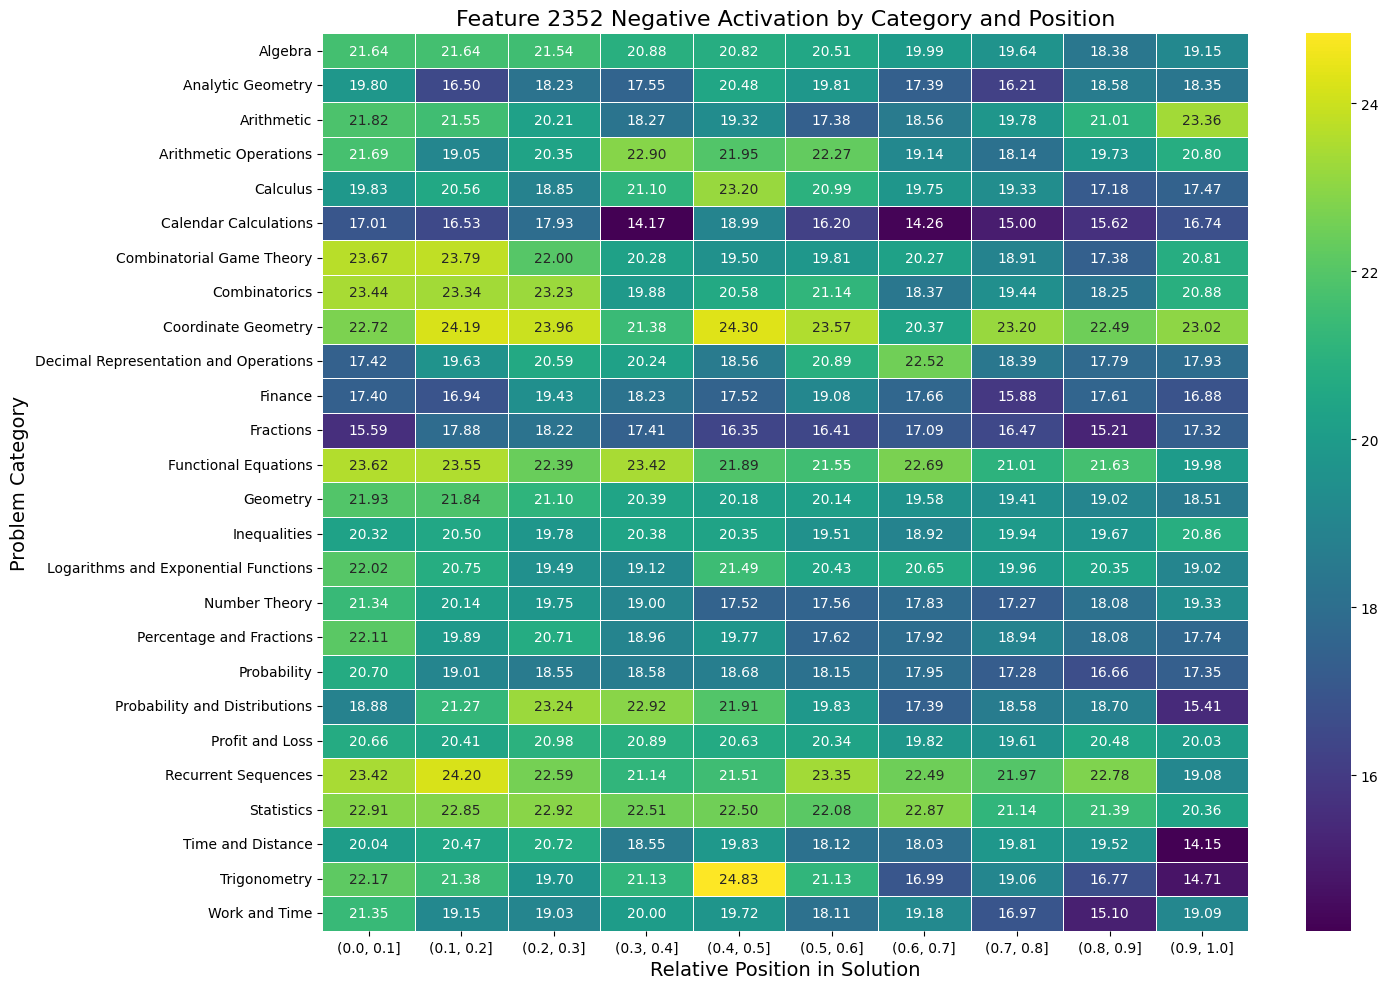

/var/folders/f9/q60hmfgd2lx3_mpq6kwg9_980000gn/T/ipykernel_94294/3030944071.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  position_counts = negative_df.groupby('position_bin').size()


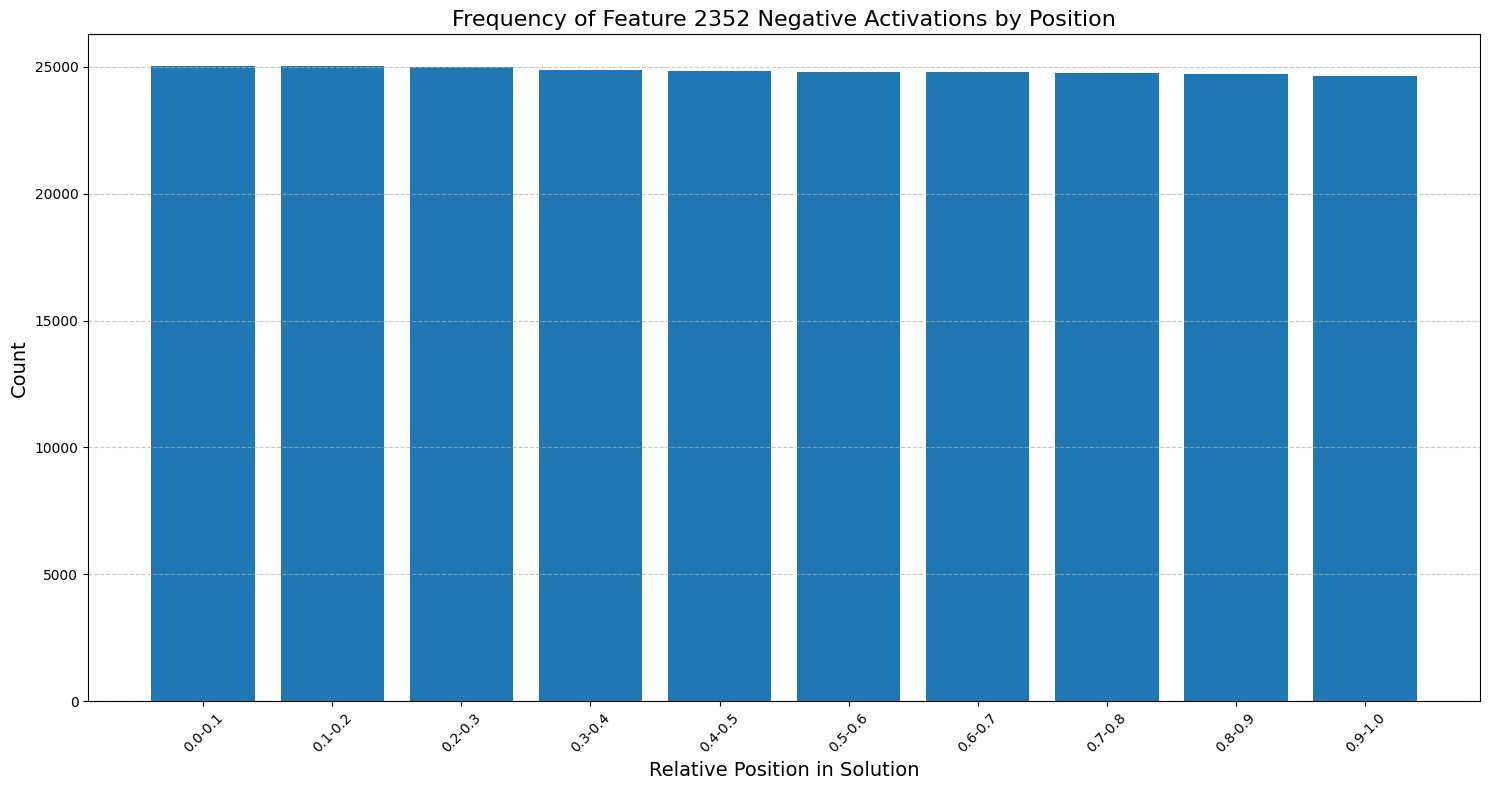

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
with open('layer30_analysis.json', 'r') as f:
    data = json.load(f)

# Process data focusing on negative features
def extract_negative_feature_data(data, feature_id=2352):
    """Extract data for a specific feature's negative activations."""
    feature_data = []
    
    for result_idx, result in enumerate(data['results']):
        problem_id = result_idx
        category = result['category']
        is_correct = result['matches_dataset']
        
        # Process each step
        for step_idx, step_feature in enumerate(result['step_features']):
            relative_pos = step_idx / len(result['step_features'])
            
            # Check if feature appears in top negative features
            is_negative = False
            neg_value = 0
            
            # Check min feature
            if step_feature['min_feature']['index'] == feature_id:
                is_negative = True
                neg_value = step_feature['min_feature']['value']
            
            # Check top negative features
            for feat in step_feature['top_negative_features']:
                if feat['index'] == feature_id:
                    is_negative = True
                    neg_value = min(neg_value, feat['value'])  # More negative value
            
            # Only store if it's a negative activation
            if is_negative:
                feature_data.append({
                    'problem_id': problem_id,
                    'category': category,
                    'is_correct': is_correct,
                    'step_idx': step_idx,
                    'relative_pos': relative_pos,
                    'negative_value': neg_value,
                    'step_text': result['steps'][step_idx] if step_idx < len(result['steps']) else ''
                })
    
    return pd.DataFrame(feature_data)

# Extract negative activation data
negative_df = extract_negative_feature_data(data, feature_id=2352)

# Create histogram of when feature 2352 is negatively active
plt.figure(figsize=(15, 8))
plt.hist(negative_df['relative_pos'], bins=20, alpha=0.7)
plt.title('When Feature 2352 is Negatively Active', fontsize=16)
plt.xlabel('Relative Position in Solution (0=start, 1=end)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Create heatmap of negative activation strength by position
plt.figure(figsize=(15, 8))
# Create bins for relative position
bins = np.linspace(0, 1, 11)  # 10 bins from 0 to 1
negative_df['position_bin'] = pd.cut(negative_df['relative_pos'], bins)

# Calculate average negative activation per bin
activation_by_position = negative_df.groupby('position_bin')['negative_value'].mean().reset_index()

plt.bar(range(len(activation_by_position)), 
        activation_by_position['negative_value'].abs(),  # Use absolute value for better visualization
        width=0.8)
plt.xticks(range(len(activation_by_position)), 
           [f"{b.left:.1f}-{b.right:.1f}" for b in activation_by_position['position_bin']], 
           rotation=45)
plt.title('Feature 2352 Negative Activation Strength by Position', fontsize=16)
plt.xlabel('Relative Position in Solution', fontsize=14)
plt.ylabel('Average Negative Activation (absolute value)', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Create heatmap of negative activation by category and position
plt.figure(figsize=(15, 10))
heatmap_data = negative_df.pivot_table(
    index='category', 
    columns='position_bin', 
    values='negative_value',
    aggfunc='mean'
)
# Use absolute values for better visualization
heatmap_data = heatmap_data.abs()
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='.2f', linewidths=.5)
plt.title('Feature 2352 Negative Activation by Category and Position', fontsize=16)
plt.xlabel('Relative Position in Solution', fontsize=14)
plt.ylabel('Problem Category', fontsize=14)
plt.tight_layout()
plt.show()

# Count occurrences by position
position_counts = negative_df.groupby('position_bin').size()
plt.figure(figsize=(15, 8))
plt.bar(range(len(position_counts)), position_counts, width=0.8)
plt.xticks(range(len(position_counts)), 
           [f"{b.left:.1f}-{b.right:.1f}" for b in position_counts.index], 
           rotation=45)
plt.title('Frequency of Feature 2352 Negative Activations by Position', fontsize=16)
plt.xlabel('Relative Position in Solution', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/var/folders/f9/q60hmfgd2lx3_mpq6kwg9_980000gn/T/ipykernel_94294/3766191638.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_by_position = negative_df.groupby('position_bin')['negative_value'].mean()


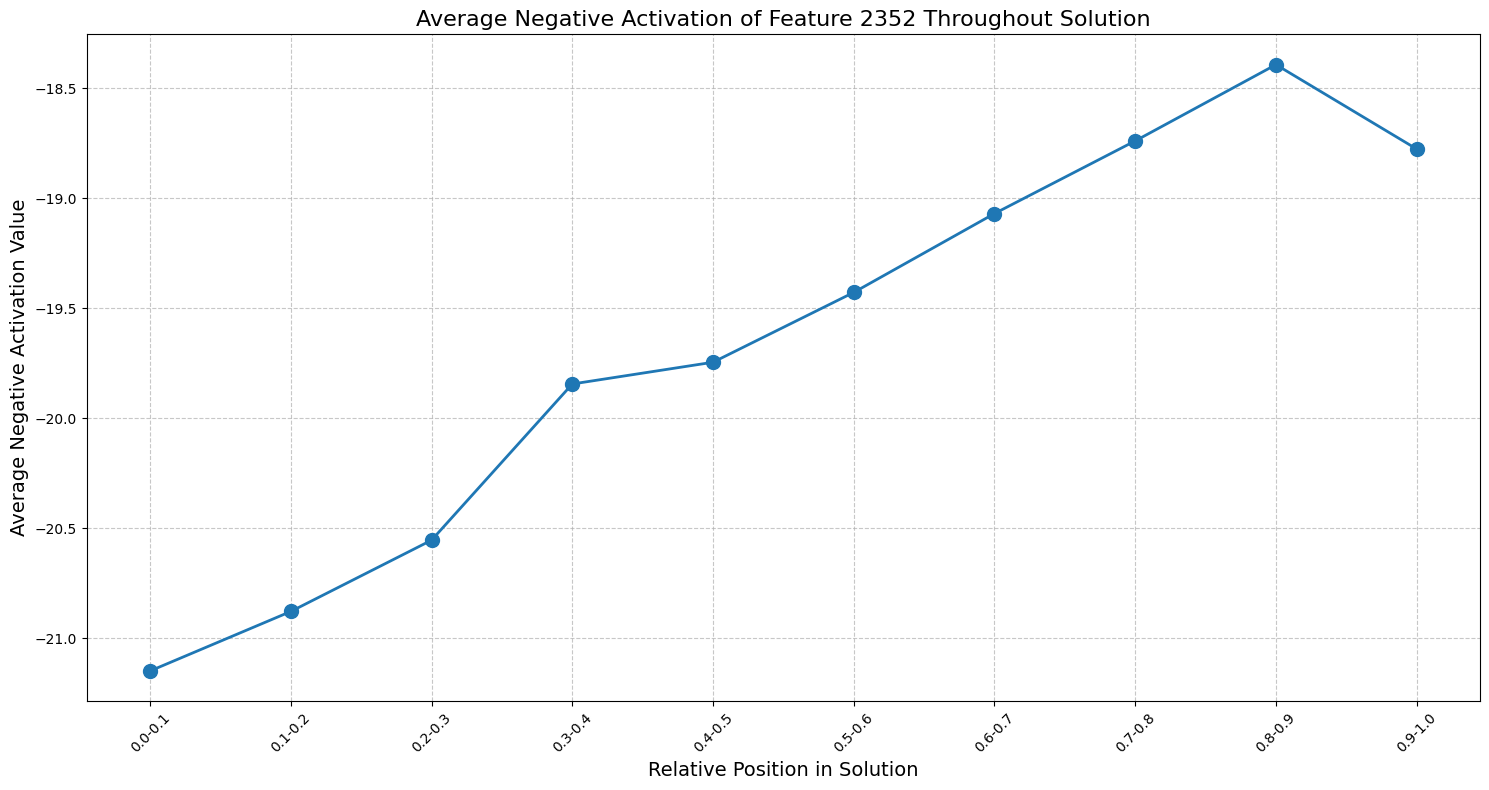

/var/folders/f9/q60hmfgd2lx3_mpq6kwg9_980000gn/T/ipykernel_94294/3766191638.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correct_avg = negative_df[negative_df['is_correct']].groupby('position_bin')['negative_value'].mean()
/var/folders/f9/q60hmfgd2lx3_mpq6kwg9_980000gn/T/ipykernel_94294/3766191638.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  incorrect_avg = negative_df[~negative_df['is_correct']].groupby('position_bin')['negative_value'].mean()


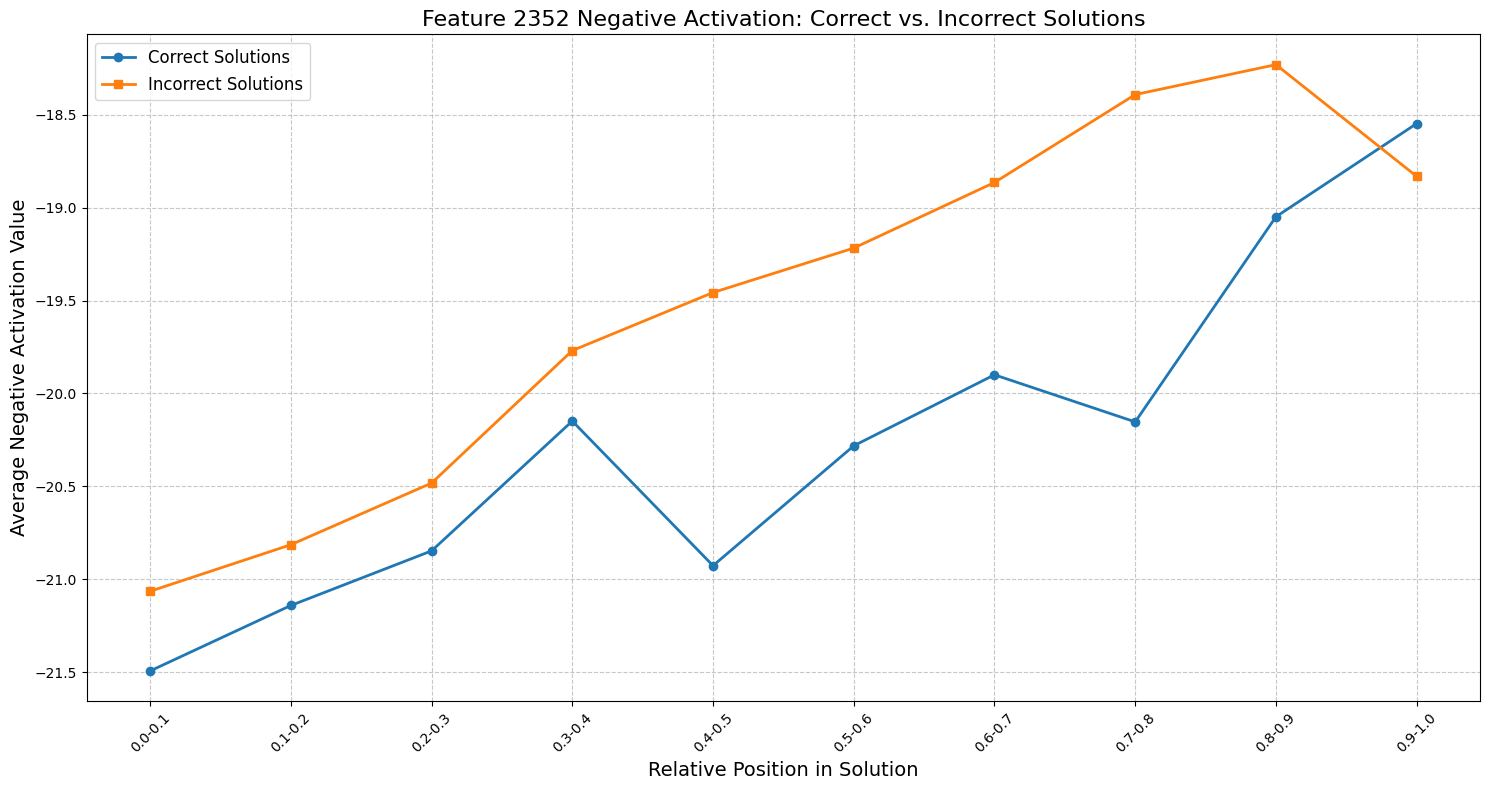

Steps with Strongest Negative Activations of Feature 2352:

Problem 48, Step 0 (Position: 0.00):
Activation: -50.1875
Text: What is the largest possible median for the five-number set \(\{x, 4x, 3, 1, 6\}\) if \( x \) can be any real number?

Problem 33, Step 0 (Position: 0.00):
Activation: -50.1875
Text: Find the angle and distance between two skew medians of the lateral faces of a regular tetrahedron with edge length $a$.

Problem 47, Step 0 (Position: 0.00):
Activation: -50.1875
Text: What is the greatest common factor of the numbers 4536 and 14280, and what is the ratio of the smaller to the larger number? Hmm, okay. So I need to find the GCF (greatest common factor) of two numbers: 4536 and 14280.

Problem 34, Step 0 (Position: 0.00):
Activation: -50.1875
Text: A train that is 250 meters long is running at a speed of 36 km/hour. It takes 45 seconds to pass a station of a certain length. How long is the station? - Okay, so I have this problem here about a train passing by a station

In [ ]:
# 1. Plot the average negative activation across all problems
plt.figure(figsize=(15, 8))
avg_by_position = negative_df.groupby('position_bin')['negative_value'].mean()
plt.plot(range(len(avg_by_position)), avg_by_position.values, marker='o', linewidth=2, markersize=10)
plt.xticks(range(len(avg_by_position)), 
           [f"{b.left:.1f}-{b.right:.1f}" for b in avg_by_position.index], 
           rotation=45)
plt.title('Average Negative Activation of Feature 2352 Throughout Solution', fontsize=16)
plt.xlabel('Relative Position in Solution', fontsize=14)
plt.ylabel('Average Negative Activation Value', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Compare correct vs. incorrect solutions
plt.figure(figsize=(15, 8))
correct_avg = negative_df[negative_df['is_correct']].groupby('position_bin')['negative_value'].mean()
incorrect_avg = negative_df[~negative_df['is_correct']].groupby('position_bin')['negative_value'].mean()

plt.plot(range(len(correct_avg)), correct_avg.values, marker='o', linewidth=2, label='Correct Solutions')
plt.plot(range(len(incorrect_avg)), incorrect_avg.values, marker='s', linewidth=2, label='Incorrect Solutions')
plt.xticks(range(len(avg_by_position)), 
           [f"{b.left:.1f}-{b.right:.1f}" for b in avg_by_position.index], 
           rotation=45)
plt.title('Feature 2352 Negative Activation: Correct vs. Incorrect Solutions', fontsize=16)
plt.xlabel('Relative Position in Solution', fontsize=14)
plt.ylabel('Average Negative Activation Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Look at the text of steps with strongest negative activations
strongest_negative = negative_df.sort_values('negative_value').head(20)
print("Steps with Strongest Negative Activations of Feature 2352:")
for i, row in strongest_negative.iterrows():
    print(f"\nProblem {row['problem_id']}, Step {row['step_idx']} (Position: {row['relative_pos']:.2f}):")
    print(f"Activation: {row['negative_value']}")
    print(f"Text: {row['step_text']}")

In [ ]:
# Fix the analysis to handle empty step text and step_type issues
def analyze_solution_dips_fixed(data, feature_id=2352):
    """Analyze what happens at the dip points in correct solutions."""
    # Extract data
    feature_data = []
    for result_idx, result in enumerate(data['results']):
        if result['matches_dataset']:  # Only correct solutions
            # Get steps text for reference
            steps_text = result['steps']
            
            for step_idx, step_feature in enumerate(result['step_features']):
                # Skip if step_idx is out of range for steps_text
                if step_idx >= len(steps_text):
                    continue
                    
                relative_pos = step_idx / len(result['step_features'])
                
                # Check if step is in a dip region
                dip1 = 0.3 <= relative_pos <= 0.5
                dip2 = 0.6 <= relative_pos <= 0.8
                
                # Check if feature appears in negative features
                is_negative = False
                neg_value = 0
                
                if step_feature['min_feature']['index'] == feature_id:
                    is_negative = True
                    neg_value = step_feature['min_feature']['value']
                
                for feat in step_feature['top_negative_features']:
                    if feat['index'] == feature_id:
                        is_negative = True
                        neg_value = min(neg_value, feat['value'])
                
                if is_negative:
                    # Get the actual step text
                    step_text = steps_text[step_idx]
                    
                    # Categorize step
                    step_type = categorize_step(step_text)
                    
                    feature_data.append({
                        'problem_id': result_idx,
                        'category': result['category'],
                        'step_idx': step_idx,
                        'relative_pos': relative_pos,
                        'negative_value': neg_value,
                        'in_dip1': dip1,
                        'in_dip2': dip2,
                        'step_text': step_text,
                        'step_type': step_type
                    })
    
    return pd.DataFrame(feature_data)

# Get dip analysis with fixed function
dip_df_fixed = analyze_solution_dips_fixed(data)

# Analyze steps in first dip (0.3-0.5)
dip1_steps = dip_df_fixed[dip_df_fixed['in_dip1'] & (dip_df_fixed['negative_value'] < -21.0)]
dip1_steps = dip1_steps.sort_values('negative_value')

print("=== STEPS IN FIRST DIP (0.3-0.5) ===")
for i, row in dip1_steps.head(10).iterrows():
    print(f"\nProblem {row['problem_id']}, Step {row['step_idx']} (Position: {row['relative_pos']:.2f}):")
    print(f"Activation: {row['negative_value']}")
    print(f"Type: {row['step_type']}")
    print(f"Text: {row['step_text']}")

# Analyze steps in second dip (0.6-0.8)
dip2_steps = dip_df_fixed[dip_df_fixed['in_dip2'] & (dip_df_fixed['negative_value'] < -20.0)]
dip2_steps = dip2_steps.sort_values('negative_value')

print("\n\n=== STEPS IN SECOND DIP (0.6-0.8) ===")
for i, row in dip2_steps.head(10).iterrows():
    print(f"\nProblem {row['problem_id']}, Step {row['step_idx']} (Position: {row['relative_pos']:.2f}):")
    print(f"Activation: {row['negative_value']}")
    print(f"Type: {row['step_type']}")
    print(f"Text: {row['step_text']}")

# Analyze step types in dips
dip1_types = dip1_steps['step_type'].value_counts()
dip2_types = dip2_steps['step_type'].value_counts()

print("\n\n=== STEP TYPES IN DIPS ===")
print("First Dip (0.3-0.5):")
print(dip1_types)
print("\nSecond Dip (0.6-0.8):")
print(dip2_types)

=== STEPS IN FIRST DIP (0.3-0.5) ===


=== STEPS IN SECOND DIP (0.6-0.8) ===


=== STEP TYPES IN DIPS ===
First Dip (0.3-0.5):
Series([], Name: count, dtype: int64)

Second Dip (0.6-0.8):
Series([], Name: count, dtype: int64)


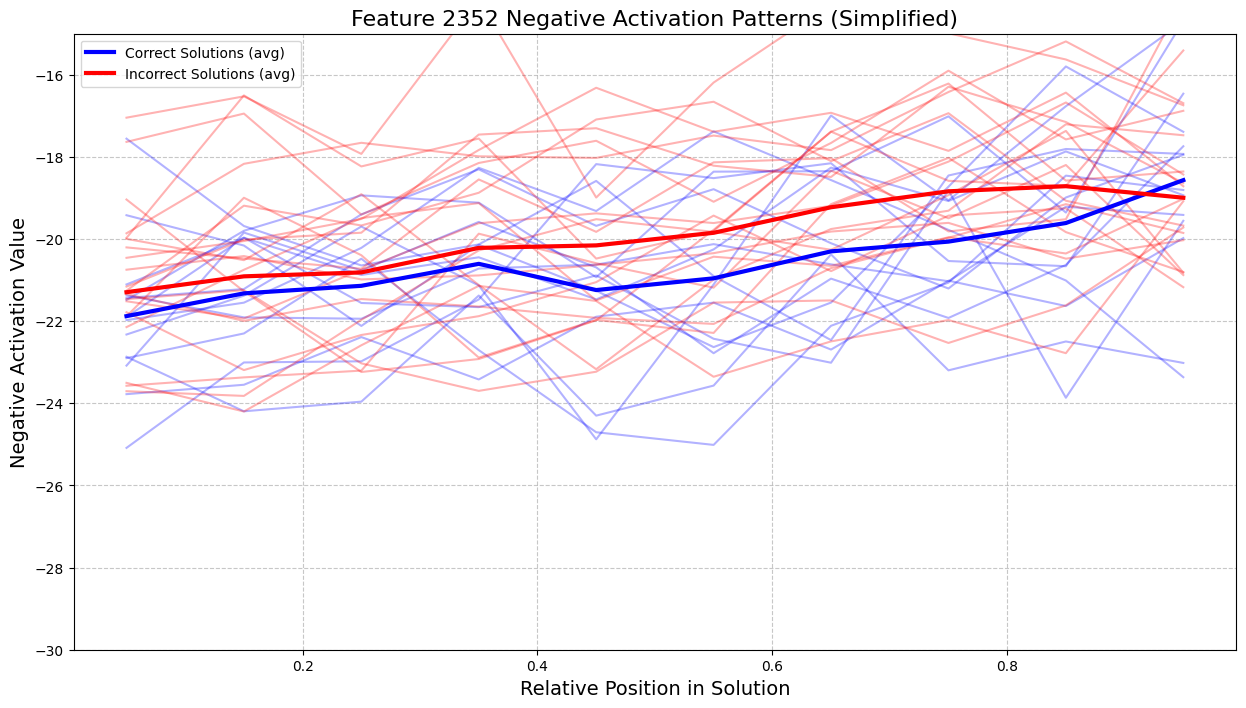

In [ ]:
# Simplified approach with fewer lines and clearer visualization
def analyze_feature_pattern_simplified(data, feature_id=2352):
    """Analyze the pattern of Feature 2352 activation with cleaner visualization."""
    # Extract data for all problems
    correct_activations = []
    incorrect_activations = []
    
    for result_idx, result in enumerate(data['results']):
        # Skip problems with too few steps
        if len(result['step_features']) < 10:
            continue
            
        # Create bins for this problem
        num_bins = 10
        bins = [[] for _ in range(num_bins)]
        
        # Collect activations by bin
        for step_idx, step_feature in enumerate(result['step_features']):
            bin_idx = min(int((step_idx / len(result['step_features'])) * num_bins), num_bins-1)
            
            # Check if feature is negative
            is_negative = False
            neg_value = 0
            
            if step_feature['min_feature']['index'] == feature_id:
                is_negative = True
                neg_value = step_feature['min_feature']['value']
            
            for feat in step_feature['top_negative_features']:
                if feat['index'] == feature_id:
                    is_negative = True
                    neg_value = min(neg_value, feat['value'])
            
            if is_negative:
                bins[bin_idx].append(neg_value)
        
        # Calculate average per bin
        bin_avgs = []
        for i, bin_values in enumerate(bins):
            if bin_values:
                bin_avgs.append((i/num_bins + 0.5/num_bins, np.mean(bin_values)))
        
        # Add to correct or incorrect list
        if result['matches_dataset']:
            correct_activations.append(bin_avgs)
        else:
            incorrect_activations.append(bin_avgs)
    
    return correct_activations, incorrect_activations

# Get simplified pattern analysis
correct_acts, incorrect_acts = analyze_feature_pattern_simplified(data)

# Plot with cleaner visualization
plt.figure(figsize=(15, 8))

# Plot individual problem patterns (limit to 20 of each for clarity)
for problem_acts in correct_acts[:20]:
    x, y = zip(*problem_acts) if problem_acts else ([], [])
    plt.plot(x, y, 'b-', alpha=0.3)

for problem_acts in incorrect_acts[:20]:
    x, y = zip(*problem_acts) if problem_acts else ([], [])
    plt.plot(x, y, 'r-', alpha=0.3)

# Calculate and plot overall averages
def calc_overall_avg(all_problem_acts, num_bins=10):
    all_bins = [[] for _ in range(num_bins)]
    for problem_acts in all_problem_acts:
        for x, y in problem_acts:
            bin_idx = min(int(x * num_bins), num_bins-1)
            all_bins[bin_idx].append(y)
    
    x_vals = [(i + 0.5)/num_bins for i in range(num_bins)]
    y_vals = [np.mean(bin_vals) if bin_vals else np.nan for bin_vals in all_bins]
    return x_vals, y_vals

correct_x, correct_y = calc_overall_avg(correct_acts)
incorrect_x, incorrect_y = calc_overall_avg(incorrect_acts)

plt.plot(correct_x, correct_y, 'b-', linewidth=3, label='Correct Solutions (avg)')
plt.plot(incorrect_x, incorrect_y, 'r-', linewidth=3, label='Incorrect Solutions (avg)')

plt.title('Feature 2352 Negative Activation Patterns (Simplified)', fontsize=16)
plt.xlabel('Relative Position in Solution', fontsize=14)
plt.ylabel('Negative Activation Value', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(-30, -15)  # Focus on the main range
plt.show()

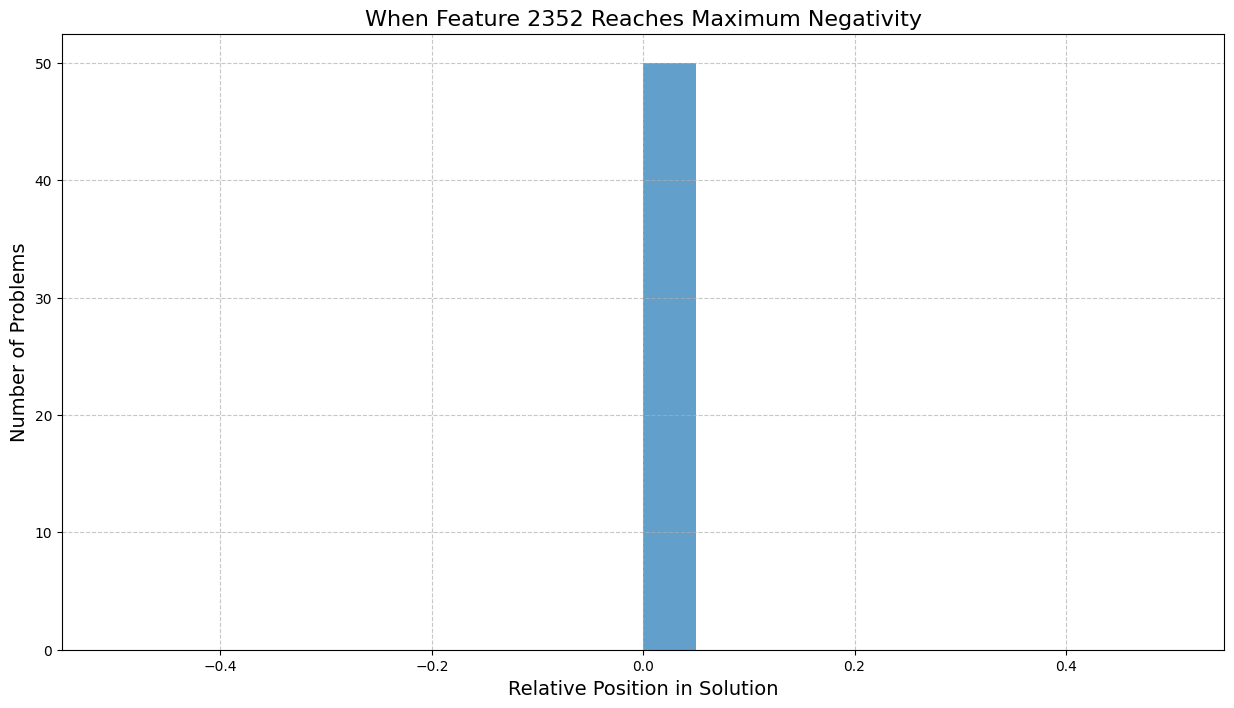

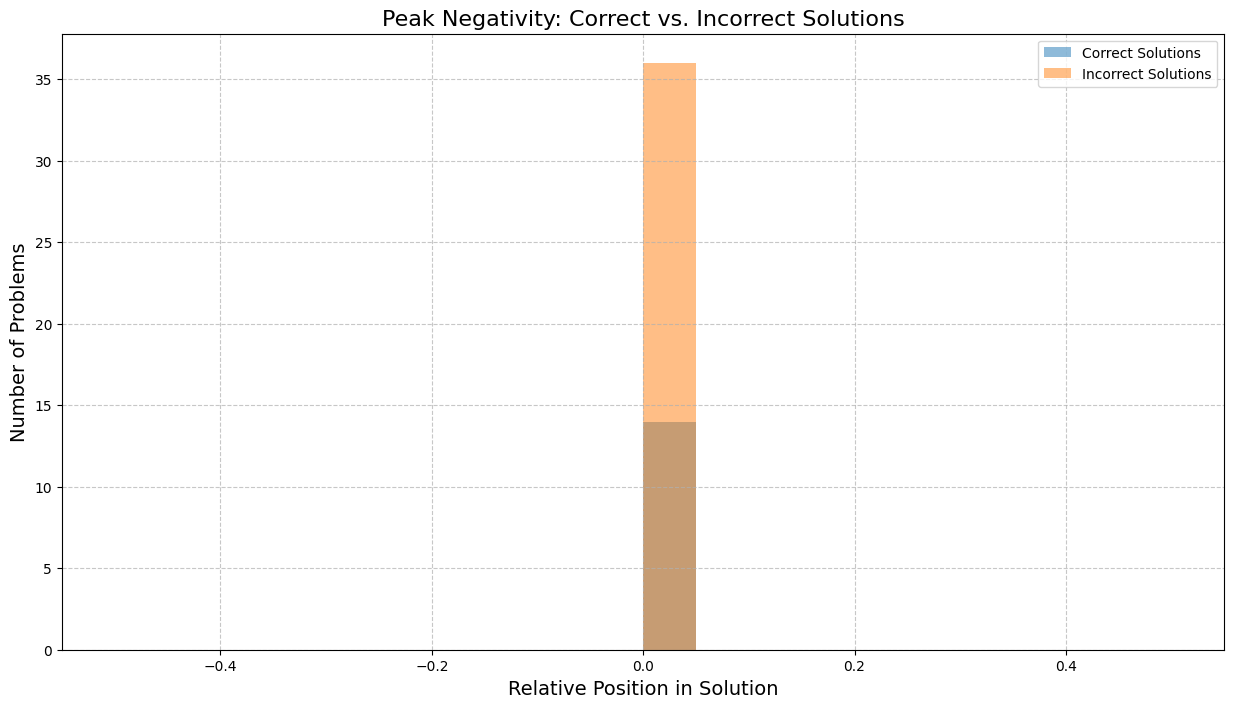

In [ ]:
# Analyze when Feature 2352 is most negative in each problem
def analyze_peak_negativity(data, feature_id=2352):
    """Find when Feature 2352 reaches its most negative value in each problem."""
    peak_data = []
    
    for result_idx, result in enumerate(data['results']):
        # Skip problems with too few steps
        if len(result['step_features']) < 10:
            continue
        
        # Find most negative activation
        most_negative = 0
        most_negative_idx = -1
        
        for step_idx, step_feature in enumerate(result['step_features']):
            # Check if feature is negative
            is_negative = False
            neg_value = 0
            
            if step_feature['min_feature']['index'] == feature_id:
                is_negative = True
                neg_value = step_feature['min_feature']['value']
            
            for feat in step_feature['top_negative_features']:
                if feat['index'] == feature_id:
                    is_negative = True
                    neg_value = min(neg_value, feat['value'])
            
            if is_negative and neg_value < most_negative:
                most_negative = neg_value
                most_negative_idx = step_idx
        
        # If we found a negative activation
        if most_negative_idx >= 0:
            peak_data.append({
                'problem_id': result_idx,
                'category': result['category'],
                'is_correct': result['matches_dataset'],
                'peak_step': most_negative_idx,
                'relative_pos': most_negative_idx / len(result['step_features']),
                'peak_value': most_negative
            })
    
    return pd.DataFrame(peak_data)

# Get peak negativity data
peak_df = analyze_peak_negativity(data)

# Plot histogram of when peaks occur
plt.figure(figsize=(15, 8))
plt.hist(peak_df['relative_pos'], bins=20, alpha=0.7)
plt.title('When Feature 2352 Reaches Maximum Negativity', fontsize=16)
plt.xlabel('Relative Position in Solution', fontsize=14)
plt.ylabel('Number of Problems', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Compare correct vs incorrect
plt.figure(figsize=(15, 8))
plt.hist(peak_df[peak_df['is_correct']]['relative_pos'], bins=20, alpha=0.5, label='Correct Solutions')
plt.hist(peak_df[~peak_df['is_correct']]['relative_pos'], bins=20, alpha=0.5, label='Incorrect Solutions')
plt.title('Peak Negativity: Correct vs. Incorrect Solutions', fontsize=16)
plt.xlabel('Relative Position in Solution', fontsize=14)
plt.ylabel('Number of Problems', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [12]:
import matplotlib.pyplot as plt

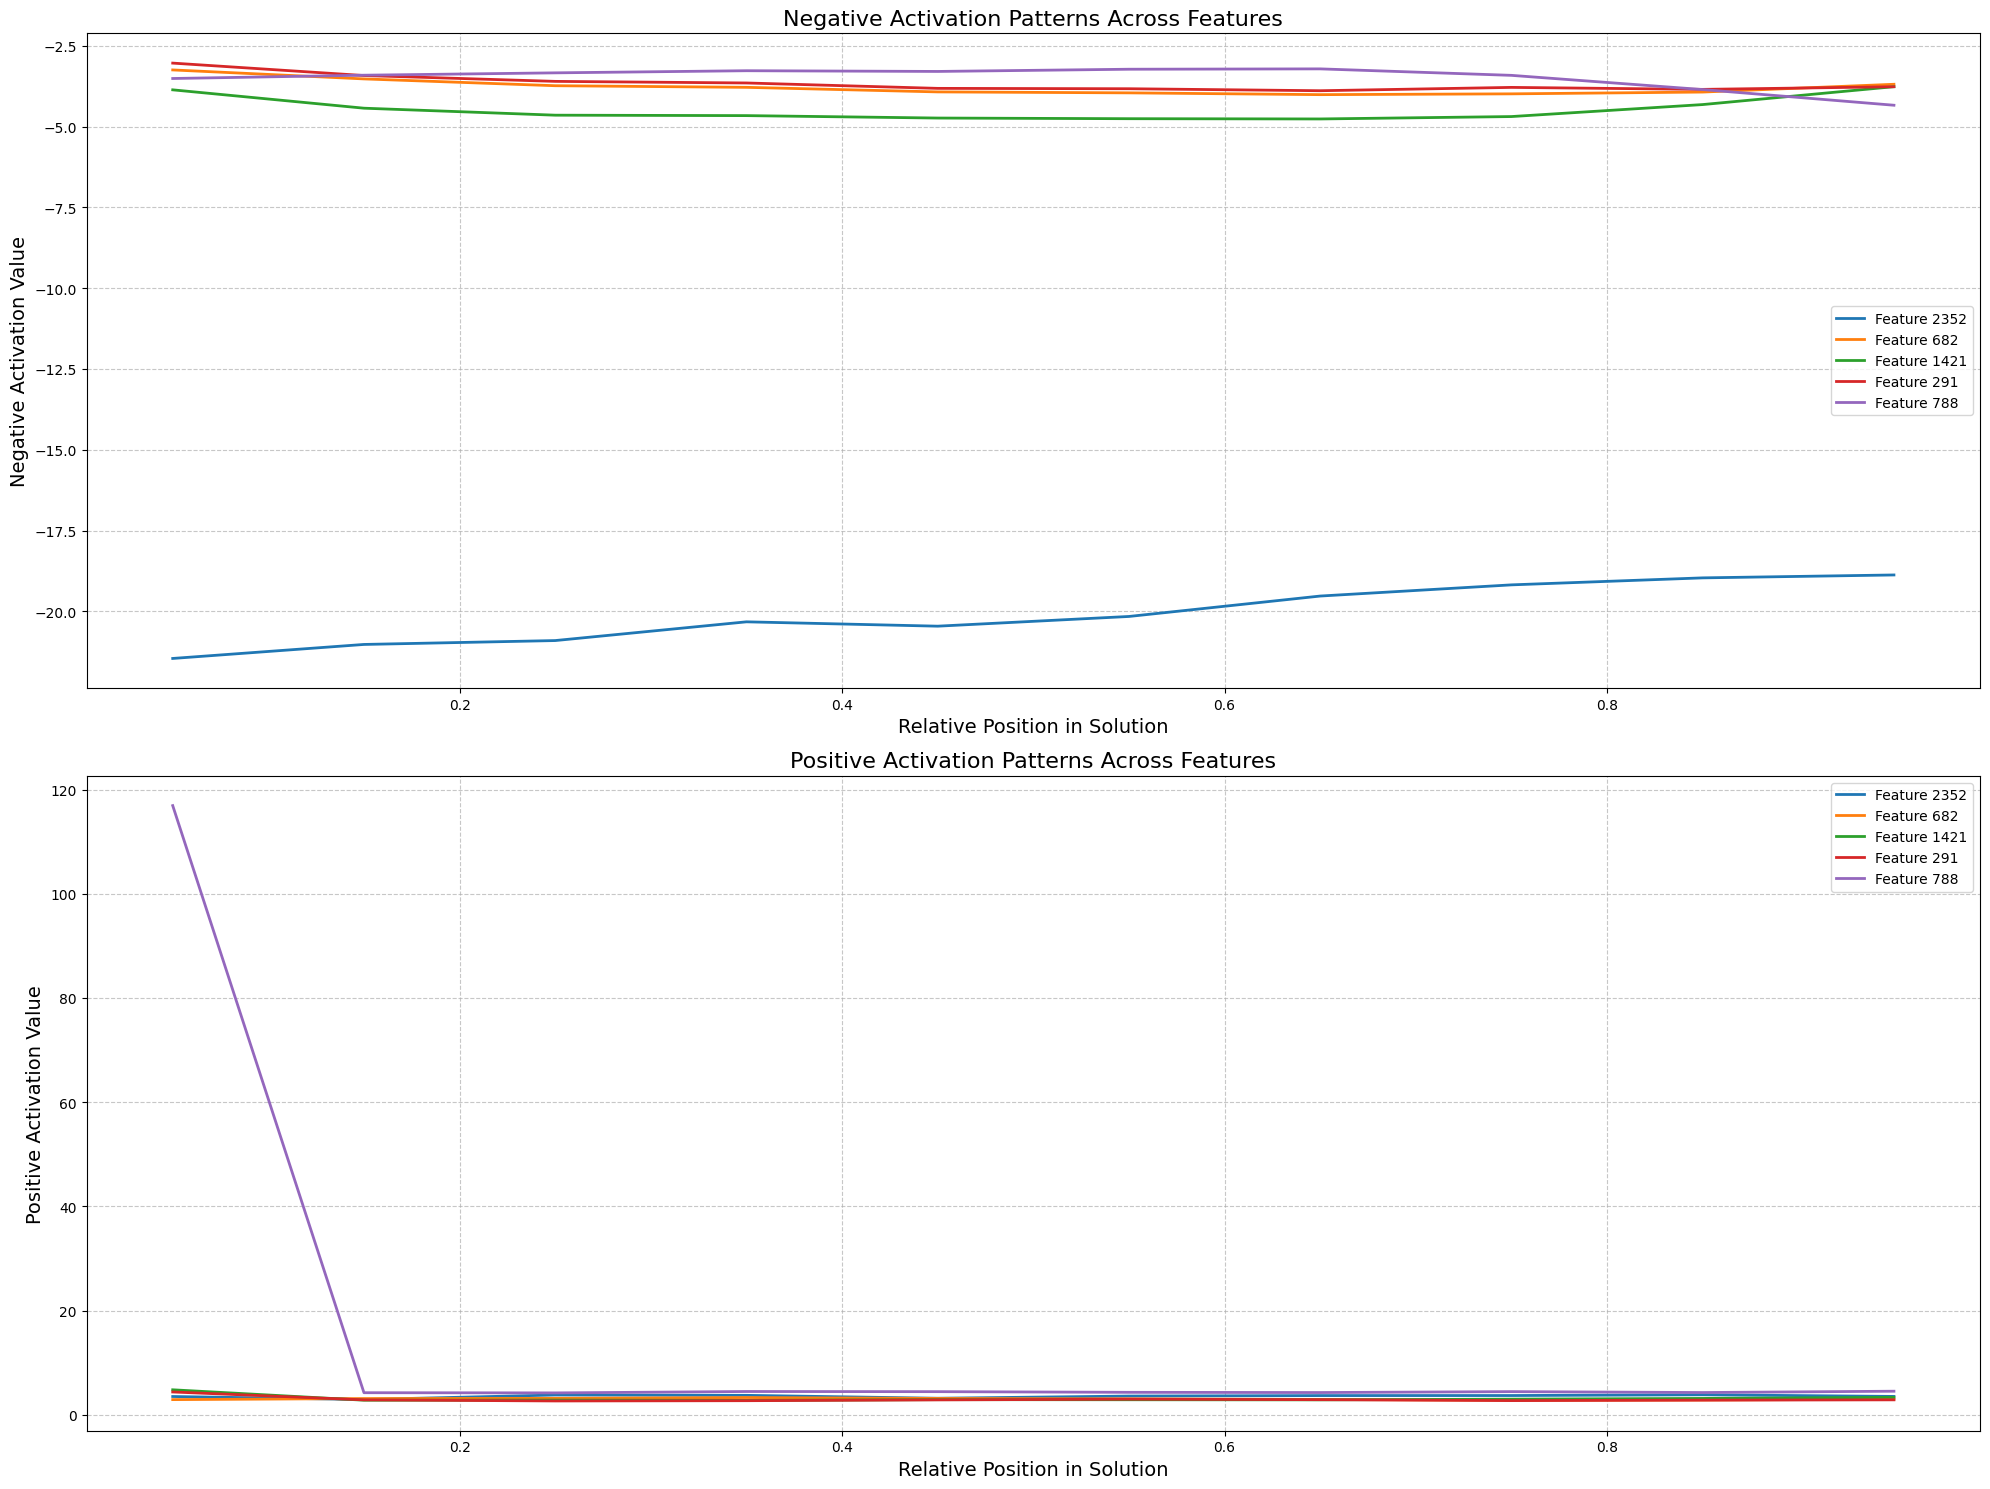

In [13]:
def analyze_multiple_features(data, feature_ids=[2352, 682, 1421, 291, 788]):
    """Compare activation patterns of multiple features."""
    feature_patterns = {}
    
    for feature_id in feature_ids:
        # Track negative and positive activations separately
        neg_activations = []
        pos_activations = []
        
        for result in data['results']:
            # Skip problems with too few steps
            if len(result['step_features']) < 10:
                continue
                
            # Create bins for this problem
            num_bins = 10
            neg_bins = [[] for _ in range(num_bins)]
            pos_bins = [[] for _ in range(num_bins)]
            
            # Collect activations by bin
            for step_idx, step_feature in enumerate(result['step_features']):
                bin_idx = min(int((step_idx / len(result['step_features'])) * num_bins), num_bins-1)
                
                # Check negative features
                for feat in step_feature['top_negative_features']:
                    if feat['index'] == feature_id:
                        neg_bins[bin_idx].append(feat['value'])
                
                # Check positive features
                for feat in step_feature['top_positive_features']:
                    if feat['index'] == feature_id:
                        pos_bins[bin_idx].append(feat['value'])
            
            # Calculate average per bin
            neg_avgs = []
            pos_avgs = []
            for i, (neg_vals, pos_vals) in enumerate(zip(neg_bins, pos_bins)):
                if neg_vals:
                    neg_avgs.append((i/num_bins + 0.5/num_bins, np.mean(neg_vals)))
                if pos_vals:
                    pos_avgs.append((i/num_bins + 0.5/num_bins, np.mean(pos_vals)))
            
            # Add to overall lists
            if neg_avgs:
                neg_activations.append(neg_avgs)
            if pos_avgs:
                pos_activations.append(pos_avgs)
        
        feature_patterns[feature_id] = {
            'negative': neg_activations,
            'positive': pos_activations
        }
    
    return feature_patterns

# Get patterns for multiple features
feature_patterns = analyze_multiple_features(data)

# Plot comparison of features
plt.figure(figsize=(20, 15))

# Plot negative activations
plt.subplot(2, 1, 1)
for feature_id, patterns in feature_patterns.items():
    # Calculate average across problems
    all_x = []
    all_y = []
    for problem_acts in patterns['negative']:
        for x, y in problem_acts:
            all_x.append(x)
            all_y.append(y)
    
    # Bin and average
    bins = np.linspace(0, 1, 11)
    bin_means = []
    bin_x = []
    for i in range(10):
        bin_vals = [y for x, y in zip(all_x, all_y) if bins[i] <= x < bins[i+1]]
        if bin_vals:
            bin_means.append(np.mean(bin_vals))
            bin_x.append((bins[i] + bins[i+1])/2)
    
    plt.plot(bin_x, bin_means, linewidth=2, label=f'Feature {feature_id}')

plt.title('Negative Activation Patterns Across Features', fontsize=16)
plt.xlabel('Relative Position in Solution', fontsize=14)
plt.ylabel('Negative Activation Value', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Plot positive activations
plt.subplot(2, 1, 2)
for feature_id, patterns in feature_patterns.items():
    # Calculate average across problems
    all_x = []
    all_y = []
    for problem_acts in patterns['positive']:
        for x, y in problem_acts:
            all_x.append(x)
            all_y.append(y)
    
    # Bin and average
    bins = np.linspace(0, 1, 11)
    bin_means = []
    bin_x = []
    for i in range(10):
        bin_vals = [y for x, y in zip(all_x, all_y) if bins[i] <= x < bins[i+1]]
        if bin_vals:
            bin_means.append(np.mean(bin_vals))
            bin_x.append((bins[i] + bins[i+1])/2)
    
    plt.plot(bin_x, bin_means, linewidth=2, label=f'Feature {feature_id}')

plt.title('Positive Activation Patterns Across Features', fontsize=16)
plt.xlabel('Relative Position in Solution', fontsize=14)
plt.ylabel('Positive Activation Value', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

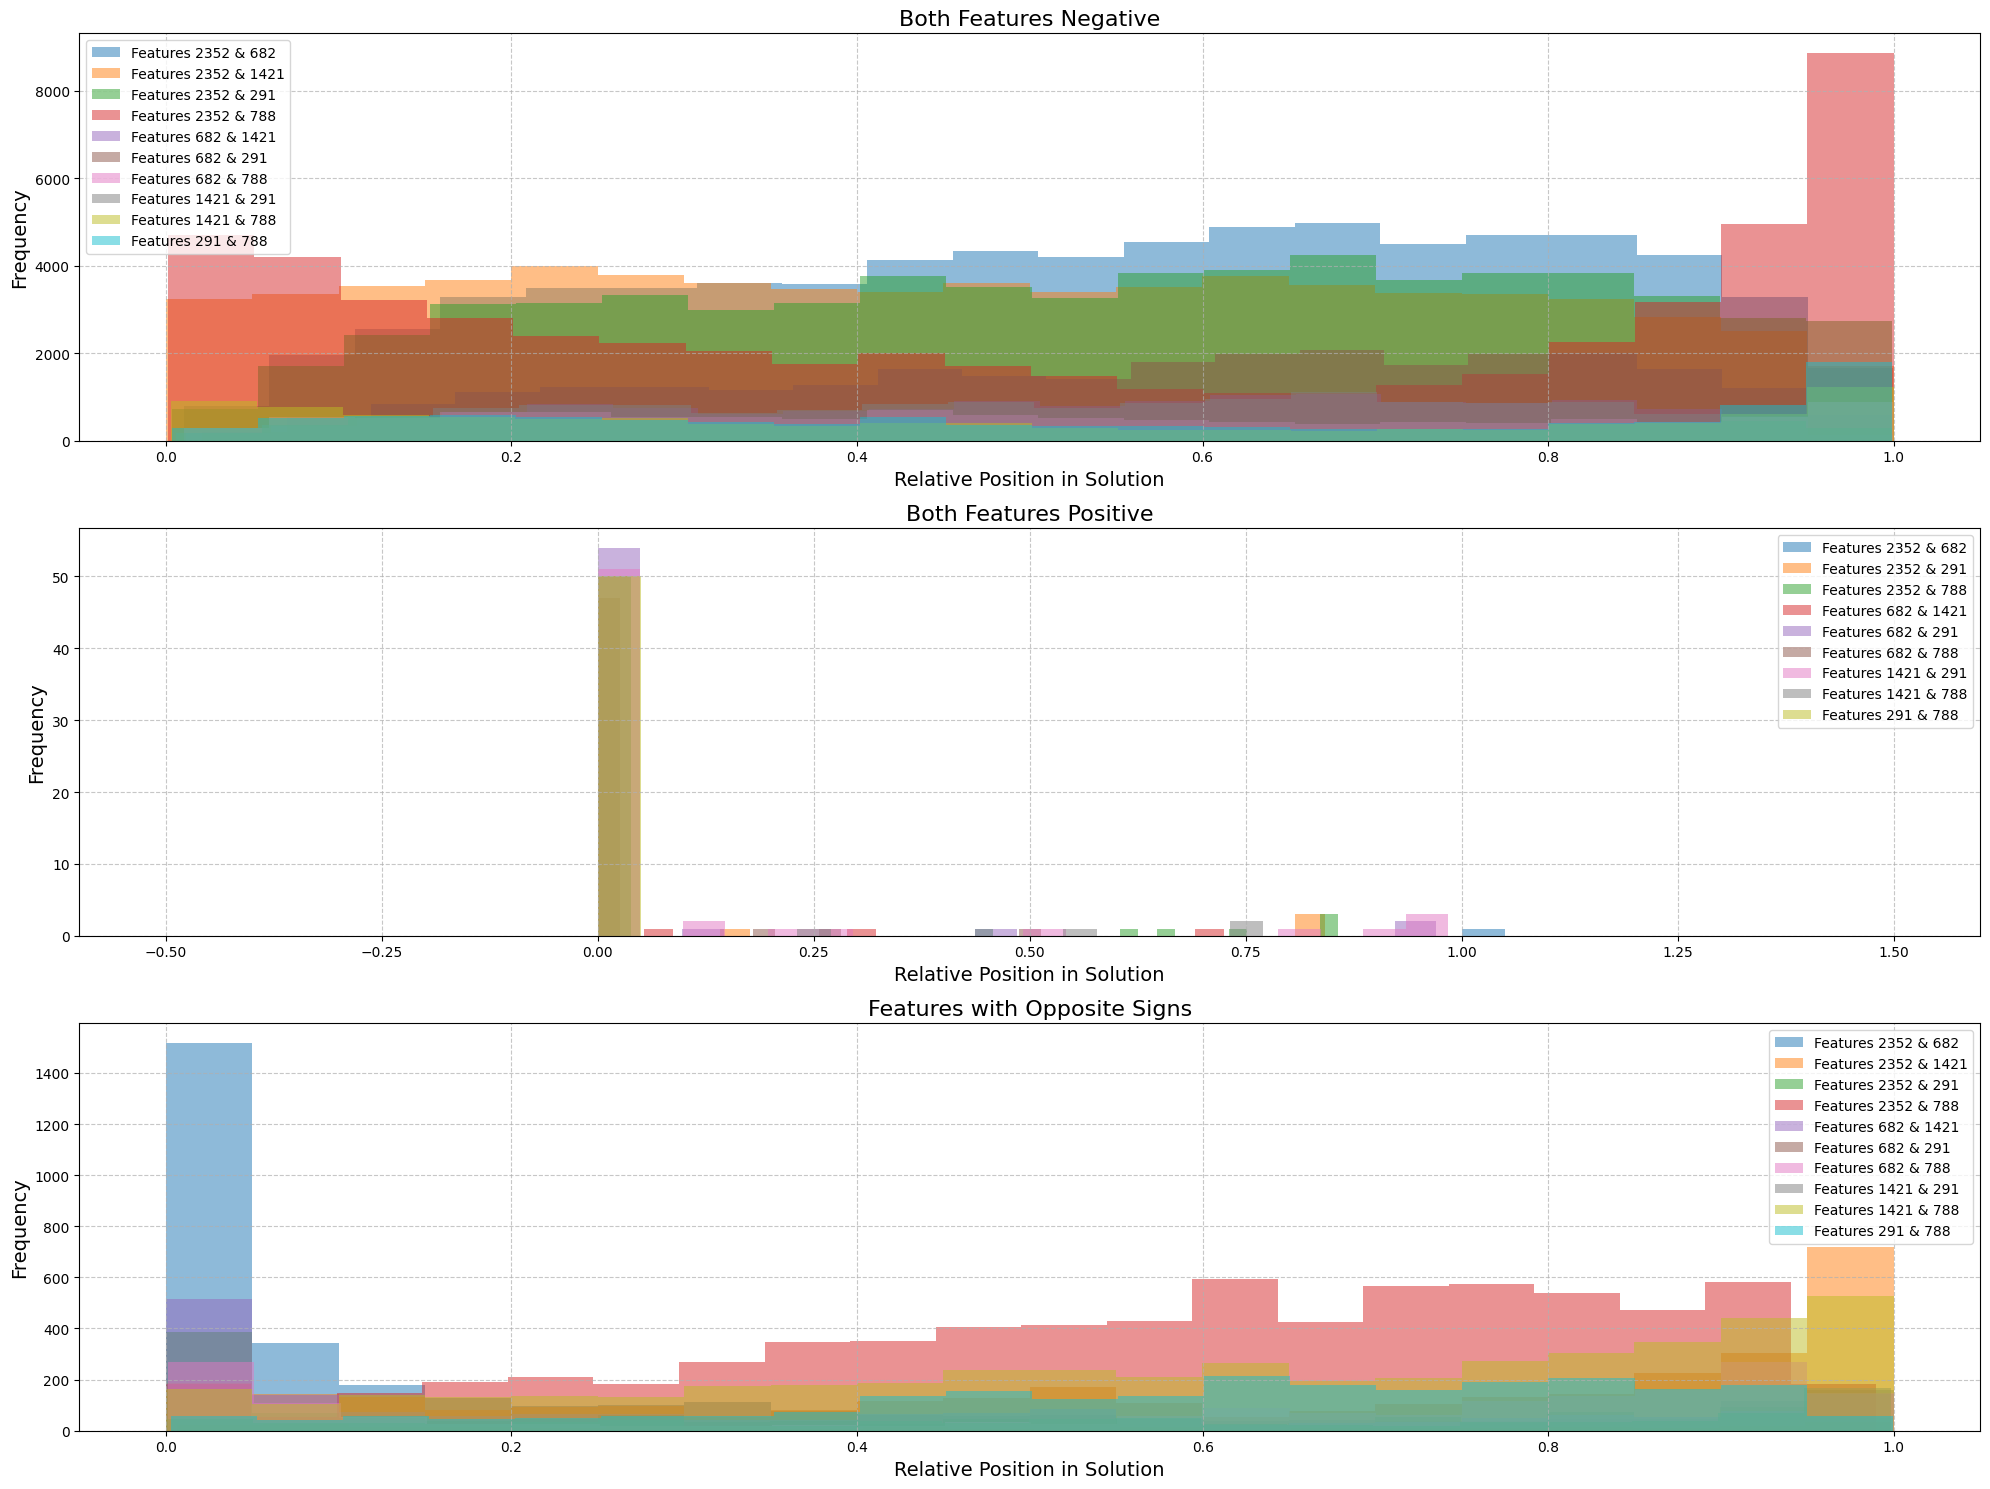

In [14]:
def analyze_feature_interactions(data, feature_ids=[2352, 682, 1421, 291, 788]):
    """Analyze how features interact with each other."""
    interactions = {}
    
    for i, feature1 in enumerate(feature_ids):
        for feature2 in feature_ids[i+1:]:
            key = f"{feature1}_{feature2}"
            interactions[key] = {
                'co_negative': [],  # Both negative
                'co_positive': [],  # Both positive
                'opposite': []      # One positive, one negative
            }
    
    for result in data['results']:
        for step_idx, step_feature in enumerate(result['step_features']):
            relative_pos = step_idx / len(result['step_features'])
            
            # Get active features
            neg_features = {f['index']: f['value'] for f in step_feature['top_negative_features']}
            pos_features = {f['index']: f['value'] for f in step_feature['top_positive_features']}
            
            # Check interactions
            for i, feature1 in enumerate(feature_ids):
                for feature2 in feature_ids[i+1:]:
                    key = f"{feature1}_{feature2}"
                    
                    # Both negative
                    if feature1 in neg_features and feature2 in neg_features:
                        interactions[key]['co_negative'].append(relative_pos)
                    
                    # Both positive
                    if feature1 in pos_features and feature2 in pos_features:
                        interactions[key]['co_positive'].append(relative_pos)
                    
                    # Opposite
                    if (feature1 in neg_features and feature2 in pos_features) or \
                       (feature1 in pos_features and feature2 in neg_features):
                        interactions[key]['opposite'].append(relative_pos)
    
    return interactions

# Get feature interactions
interactions = analyze_feature_interactions(data)

# Plot interactions
plt.figure(figsize=(20, 15))
interaction_types = ['co_negative', 'co_positive', 'opposite']
titles = ['Both Features Negative', 'Both Features Positive', 'Features with Opposite Signs']

for i, interaction_type in enumerate(interaction_types):
    plt.subplot(3, 1, i+1)
    
    for key, data in interactions.items():
        if data[interaction_type]:
            feature1, feature2 = key.split('_')
            plt.hist(data[interaction_type], bins=20, alpha=0.5, 
                     label=f'Features {feature1} & {feature2}')
    
    plt.title(titles[i], fontsize=16)
    plt.xlabel('Relative Position in Solution', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

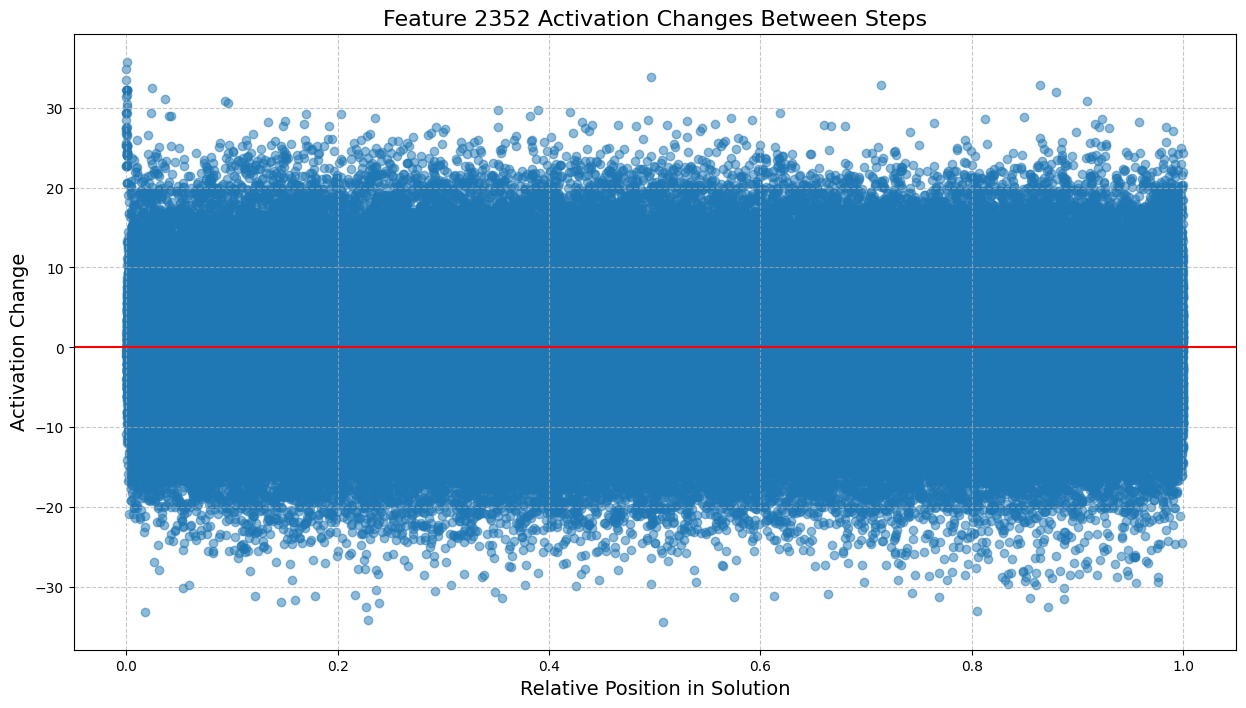

In [26]:
def analyze_activation_changes(data, feature_id=2352):
    """Analyze how feature activation changes between consecutive steps."""
    step_changes = []
    
    for result in data['results']:
        prev_activation = None
        
        for step_idx, step_feature in enumerate(result['step_features']):
            relative_pos = step_idx / len(result['step_features'])
            
            # Get current activation
            current_activation = None
            
            # Check negative features
            for feat in step_feature['top_negative_features']:
                if feat['index'] == feature_id:
                    current_activation = feat['value']
                    break
            
            # If we have both current and previous
            if current_activation is not None and prev_activation is not None:
                change = current_activation - prev_activation
                step_changes.append({
                    'relative_pos': relative_pos,
                    'change': change
                })
            
            prev_activation = current_activation
    
    return pd.DataFrame(step_changes)

# Get activation changes
changes_df = analyze_activation_changes(data)

# Plot changes
plt.figure(figsize=(15, 8))
plt.scatter(changes_df['relative_pos'], changes_df['change'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Feature 2352 Activation Changes Between Steps', fontsize=16)
plt.xlabel('Relative Position in Solution', fontsize=14)
plt.ylabel('Activation Change', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [5]:
# 1. Focus on Feature 788's unusual positive spike
def analyze_feature_788_spike(data):
    """Analyze Feature 788's dramatic positive spike at the beginning."""
    early_activations = []
    
    for result in data['results']:
        # Look at first 10% of steps
        early_steps = int(len(result['step_features']) * 0.1)
        if early_steps < 1:
            continue
            
        for step_idx in range(early_steps):
            step_feature = result['step_features'][step_idx]
            
            # Check if feature 788 is positive
            for feat in step_feature['top_positive_features']:
                if feat['index'] == 788:
                    early_activations.append({
                        'problem_id': result.get('problem_id', ''),
                        'category': result['category'],
                        'step_idx': step_idx,
                        'relative_pos': step_idx / len(result['step_features']),
                        'activation': feat['value'],
                        'is_correct': result['matches_dataset']
                    })
    
    return pd.DataFrame(early_activations)

# 2. Analyze Feature 2352 and 788 relationship
def analyze_feature_relationship(data, feature1=2352, feature2=788):
    """Analyze the relationship between two specific features."""
    relationship_data = []
    
    for result in data['results']:
        for step_idx, step_feature in enumerate(result['step_features']):
            relative_pos = step_idx / len(result['step_features'])
            
            # Get feature values
            feature1_val = None
            feature2_val = None
            
            # Check negative features
            for feat in step_feature['top_negative_features']:
                if feat['index'] == feature1:
                    feature1_val = feat['value']
                if feat['index'] == feature2:
                    feature2_val = feat['value']
            
            # Check positive features
            for feat in step_feature['top_positive_features']:
                if feat['index'] == feature1:
                    feature1_val = feat['value']
                if feat['index'] == feature2:
                    feature2_val = feat['value']
            
            # If both features are active
            if feature1_val is not None and feature2_val is not None:
                relationship_data.append({
                    'problem_id': result.get('problem_id', ''),
                    'category': result['category'],
                    'step_idx': step_idx,
                    'relative_pos': relative_pos,
                    'feature1_val': feature1_val,
                    'feature2_val': feature2_val,
                    'is_correct': result['matches_dataset']
                })
    
    return pd.DataFrame(relationship_data)

# 3. Refine feature interaction analysis
def refine_feature_interactions(data, feature_ids=[2352, 682, 1421, 291, 788]):
    """Create clearer visualization of feature interactions."""
    # Create interaction pairs
    pairs = []
    for i, f1 in enumerate(feature_ids):
        for f2 in feature_ids[i+1:]:
            pairs.append((f1, f2))
    
    # Track interactions by position
    interactions = {
        'co_negative': {pair: [0] * 10 for pair in pairs},
        'co_positive': {pair: [0] * 10 for pair in pairs},
        'opposite': {pair: [0] * 10 for pair in pairs}
    }
    
    for result in data['results']:
        for step_idx, step_feature in enumerate(result['step_features']):
            bin_idx = min(int((step_idx / len(result['step_features'])) * 10), 9)
            
            # Get active features
            neg_features = {f['index']: f['value'] for f in step_feature['top_negative_features']}
            pos_features = {f['index']: f['value'] for f in step_feature['top_positive_features']}
            
            # Check interactions
            for f1, f2 in pairs:
                # Both negative
                if f1 in neg_features and f2 in neg_features:
                    interactions['co_negative'][(f1, f2)][bin_idx] += 1
                
                # Both positive
                if f1 in pos_features and f2 in pos_features:
                    interactions['co_positive'][(f1, f2)][bin_idx] += 1
                
                # Opposite
                if (f1 in neg_features and f2 in pos_features) or \
                   (f1 in pos_features and f2 in neg_features):
                    interactions['opposite'][(f1, f2)][bin_idx] += 1
    
    return interactions

# 4. Analyze step types where Feature 2352 is most negative
def analyze_step_types_with_feature(data, feature_id=2352):
    """Analyze what types of steps have strong Feature 2352 activation."""
    step_types = {
        'setup': ['let', 'assume', 'given', 'first', 'start'],
        'calculation': ['=', '+', '-', '*', '/', 'calculate', 'compute'],
        'rule_recall': ['recall', 'note', 'observe', 'rule', 'formula'],
        'verification': ['check', 'verify', 'confirm', 'test', 'substitute'],
        'conclusion': ['therefore', 'thus', 'hence', 'answer', 'final']
    }
    
    step_data = []
    
    for result in data['results']:
        for step_idx, step_feature in enumerate(result['step_features']):
            # Skip if step_idx is out of range for steps
            if step_idx >= len(result['steps']):
                continue
                
            step_text = result['steps'][step_idx]
            relative_pos = step_idx / len(result['step_features'])
            
            # Determine step type
            step_type = 'other'
            for type_name, keywords in step_types.items():
                if any(keyword in step_text.lower() for keyword in keywords):
                    step_type = type_name
                    break
            
            # Check if feature is active
            feature_val = None
            is_negative = False
            
            # Check negative features
            for feat in step_feature['top_negative_features']:
                if feat['index'] == feature_id:
                    feature_val = feat['value']
                    is_negative = True
                    break
            
            # Check positive features if not found in negative
            if feature_val is None:
                for feat in step_feature['top_positive_features']:
                    if feat['index'] == feature_id:
                        feature_val = feat['value']
                        break
            
            # If feature is active
            if feature_val is not None:
                step_data.append({
                    'problem_id': result.get('problem_id', ''),
                    'category': result['category'],
                    'step_idx': step_idx,
                    'relative_pos': relative_pos,
                    'step_type': step_type,
                    'feature_val': feature_val,
                    'is_negative': is_negative,
                    'is_correct': result['matches_dataset']
                })
    
    return pd.DataFrame(step_data)

# Create visualizations
def create_refined_visualizations(feature_788_df, relationship_df, interactions, step_types_df):
    """Create refined visualizations for better insights."""
    plt.figure(figsize=(20, 15))
    
    # 1. Feature 788 early spike
    plt.subplot(2, 2, 1)
    plt.hist(feature_788_df['relative_pos'], bins=20, alpha=0.7)
    plt.title('Feature 788 Early Positive Activations', fontsize=16)
    plt.xlabel('Relative Position in Solution', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 2. Feature 2352 vs 788 relationship
    plt.subplot(2, 2, 2)
    plt.scatter(relationship_df['feature1_val'], relationship_df['feature2_val'], 
                c=relationship_df['relative_pos'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='Relative Position in Solution')
    plt.title('Feature 2352 vs 788 Relationship', fontsize=16)
    plt.xlabel('Feature 2352 Value', fontsize=14)
    plt.ylabel('Feature 788 Value', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 3. Refined feature interactions
    plt.subplot(2, 2, 3)
    x = np.linspace(0.05, 0.95, 10)  # Bin centers
    
    # Plot most interesting pairs
    key_pairs = [(2352, 788), (2352, 682), (682, 788)]
    for pair in key_pairs:
        plt.plot(x, interactions['opposite'][pair], 
                 label=f'Features {pair[0]} & {pair[1]} (opposite)', 
                 linewidth=2)
    
    plt.title('Feature Interactions (Opposite Signs)', fontsize=16)
    plt.xlabel('Relative Position in Solution', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 4. Step types with Feature 2352
    plt.subplot(2, 2, 4)
    step_type_counts = step_types_df.groupby(['step_type', 'is_negative']).size().unstack()
    step_type_counts.plot(kind='bar', ax=plt.gca())
    plt.title('Step Types with Feature 2352', fontsize=16)
    plt.xlabel('Step Type', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.legend(['Positive', 'Negative'])
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

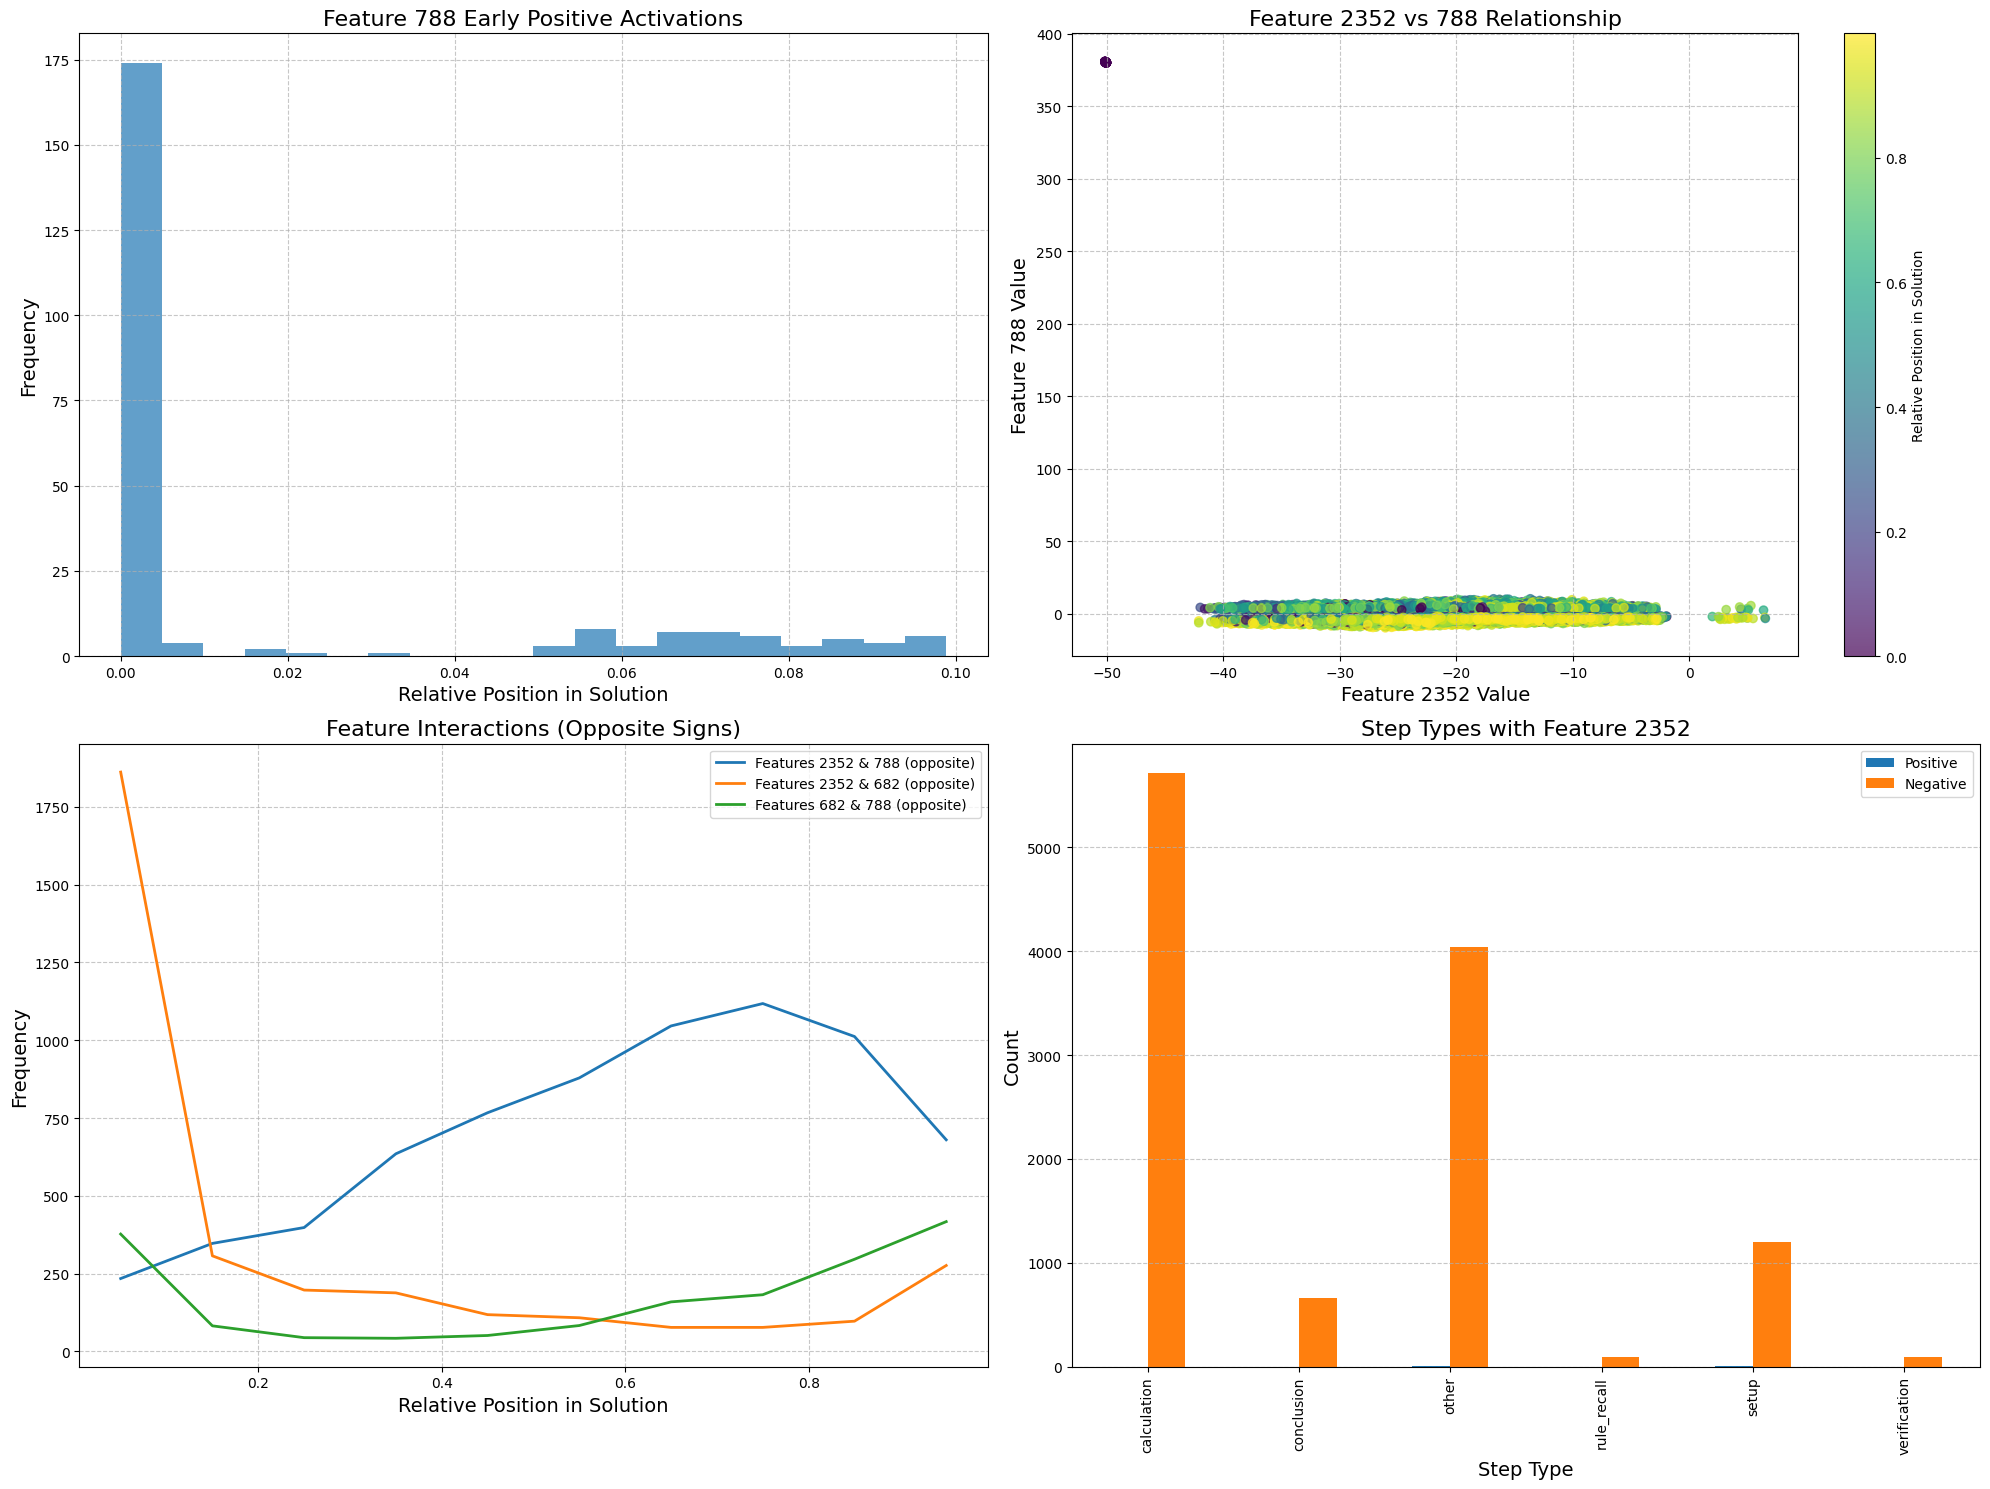

Feature 788 early activations: 234 instances
Feature 2352-788 co-activations: 61032 instances

Step types with Feature 2352:
is_negative   False   True 
step_type                  
calculation     NaN  5713.0
conclusion      NaN   661.0
other           1.0  4038.0
rule_recall     NaN    91.0
setup           1.0  1204.0
verification    NaN    88.0

Most negative Feature 2352 steps:
Problem , Step 0 (calculation): -50.1875
Problem , Step 0 (calculation): -50.1875
Problem , Step 0 (other): -50.1875
Problem , Step 0 (setup): -50.1875
Problem , Step 0 (verification): -50.1875


In [6]:
# Make sure we have the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load the data if not already loaded
with open('layer30_analysis.json', 'r') as f:
    data = json.load(f)

# Run the analyses (assuming you've defined the functions above)
# 1. Analyze Feature 788's early spike
feature_788_df = analyze_feature_788_spike(data)

# 2. Analyze relationship between Features 2352 and 788
relationship_df = analyze_feature_relationship(data, feature1=2352, feature2=788)

# 3. Refine feature interaction analysis
interactions = refine_feature_interactions(data, feature_ids=[2352, 682, 1421, 291, 788])

# 4. Analyze step types with Feature 2352
step_types_df = analyze_step_types_with_feature(data, feature_id=2352)

# Create the visualizations
create_refined_visualizations(feature_788_df, relationship_df, interactions, step_types_df)

# You can also look at individual results
print(f"Feature 788 early activations: {len(feature_788_df)} instances")
print(f"Feature 2352-788 co-activations: {len(relationship_df)} instances")

# Look at step types where Feature 2352 is active
step_type_counts = step_types_df.groupby(['step_type', 'is_negative']).size().unstack()
print("\nStep types with Feature 2352:")
print(step_type_counts)

# Check the most negative steps for Feature 2352
if not step_types_df.empty:
    most_negative = step_types_df[step_types_df['is_negative']].sort_values('feature_val').head(5)
    print("\nMost negative Feature 2352 steps:")
    for i, row in most_negative.iterrows():
        print(f"Problem {row['problem_id']}, Step {row['step_idx']} ({row['step_type']}): {row['feature_val']}")

In [ ]:
#This didn't work very well.. haha, see next cell
def analyze_interaction_dips(data, feature1=2352, feature2=682):
    """Analyze what happens at the dips in feature interactions."""
    # First dip around position 0.2-0.3
    first_dip_data = []
    # Second dip around position 0.5-0.6
    second_dip_data = []
    
    for result_idx, result in enumerate(data['results']):
        for step_idx, step_feature in enumerate(result['step_features']):
            relative_pos = step_idx / len(result['step_features'])
            
            # Check if we're in a dip region
            in_first_dip = 0.2 <= relative_pos <= 0.3
            in_second_dip = 0.5 <= relative_pos <= 0.6
            
            # Get feature values
            feature1_val = None
            feature2_val = None
            
            # Check negative features
            for feat in step_feature['top_negative_features']:
                if feat['index'] == feature1:
                    feature1_val = feat['value']
                if feat['index'] == feature2:
                    feature2_val = feat['value']
            
            # Check positive features
            for feat in step_feature['top_positive_features']:
                if feat['index'] == feature1:
                    feature1_val = feat['value']
                if feat['index'] == feature2:
                    feature2_val = feat['value']
            
            # If both features are active
            if feature1_val is not None and feature2_val is not None:
                step_data = {
                    'problem_id': result_idx,
                    'category': result['category'],
                    'step_idx': step_idx,
                    'relative_pos': relative_pos,
                    'feature1_val': feature1_val,
                    'feature2_val': feature2_val,
                    'step_text': result['steps'][step_idx] if step_idx < len(result['steps']) else '',
                    'is_correct': result['matches_dataset']
                }
                
                if in_first_dip:
                    first_dip_data.append(step_data)
                elif in_second_dip:
                    second_dip_data.append(step_data)
    
    return pd.DataFrame(first_dip_data), pd.DataFrame(second_dip_data)

# Analyze the dips
first_dip_df, second_dip_df = analyze_interaction_dips(data)

# Analyze step types in the dips
def categorize_step(text):
    """Categorize step type based on content."""
    text = text.lower()
    if any(w in text for w in ['therefore', 'thus', 'hence', 'answer', 'final']):
        return 'conclusion'
    if any(w in text for w in ['let', 'assume', 'given', 'first', 'start']):
        return 'setup'
    if any(w in text for w in ['=', '+', '-', '*', '/', 'calculate', 'compute']):
        return 'calculation'
    if any(w in text for w in ['recall', 'note', 'observe', 'rule', 'formula']):
        return 'rule_recall'
    if any(w in text for w in ['check', 'verify', 'confirm', 'test', 'substitute']):
        return 'verification'
    return 'other'

# Add step types
if not first_dip_df.empty:
    first_dip_df['step_type'] = first_dip_df['step_text'].apply(categorize_step)
if not second_dip_df.empty:
    second_dip_df['step_type'] = second_dip_df['step_text'].apply(categorize_step)

# Analyze step types in dips
print("Step types in first dip (0.2-0.3):")
print(first_dip_df['step_type'].value_counts())
print("\nStep types in second dip (0.5-0.6):")
print(second_dip_df['step_type'].value_counts())

# Look at example steps from each dip
print("\nExample steps from first dip:")
for i, row in first_dip_df.head(3).iterrows():
    print(f"\nProblem {row['problem_id']}, Step {row['step_idx']} ({row['step_type']}):")
    print(f"Feature {feature1} value: {row['feature1_val']}")
    print(f"Feature {feature2} value: {row['feature2_val']}")
    print(f"Text: {row['step_text'][:100]}...")

print("\nExample steps from second dip:")
for i, row in second_dip_df.head(3).iterrows():
    print(f"\nProblem {row['problem_id']}, Step {row['step_idx']} ({row['step_type']}):")
    print(f"Feature {feature1} value: {row['feature1_val']}")
    print(f"Feature {feature2} value: {row['feature2_val']}")
    print(f"Text: {row['step_text'][:100]}...")

Step types in first dip (0.2-0.3):
step_type
other    7244
Name: count, dtype: int64

Step types in second dip (0.5-0.6):
step_type
other    8839
Name: count, dtype: int64

Example steps from first dip:

Problem 0, Step 475 (other):
Feature 291 value: -26.0
Feature 788 value: -2.806640625
Text: ...

Problem 0, Step 476 (other):
Feature 291 value: -22.0
Feature 788 value: -3.64453125
Text: ...

Problem 0, Step 521 (other):
Feature 291 value: -19.78125
Feature 788 value: 4.55078125
Text: ...

Example steps from second dip:

Problem 0, Step 1179 (other):
Feature 291 value: -20.90625
Feature 788 value: -4.546875
Text: ...

Problem 0, Step 1180 (other):
Feature 291 value: -17.0
Feature 788 value: -4.55859375
Text: ...

Problem 0, Step 1181 (other):
Feature 291 value: -16.859375
Feature 788 value: -2.986328125
Text: ...


Average feature values by position:
              feature1_val  feature2_val  count
position_bin                                   
0.0-0.1         -27.528247     72.314927    266
0.1-0.2         -21.112663     -3.317639    420
0.2-0.3         -22.768947     -3.714416    769
0.3-0.4         -20.859368     -3.475876    849
0.4-0.5         -21.594327     -3.626356    708
0.5-0.6         -22.007910     -3.364230    562
0.6-0.7         -21.391504     -3.421133    420
0.7-0.8         -22.484511     -3.583038    258
0.8-0.9         -20.096116     -3.556553    156
0.9-1.0         -22.129366     -3.631204     34

Step type distribution by position:
step_type     calculation  conclusion  other  rule_recall  setup  verification
position_bin                                                                  
0.0-0.1                81          94     61            0     29             1
0.1-0.2               137         136    116            1     30             0
0.2-0.3               258         1

/var/folders/f9/q60hmfgd2lx3_mpq6kwg9_980000gn/T/ipykernel_90140/962477305.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_by_position = df.groupby('position_bin').agg({
/var/folders/f9/q60hmfgd2lx3_mpq6kwg9_980000gn/T/ipykernel_90140/962477305.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  step_types_by_position = df.groupby(['position_bin', 'step_type']).size().unstack(fill_value=0)


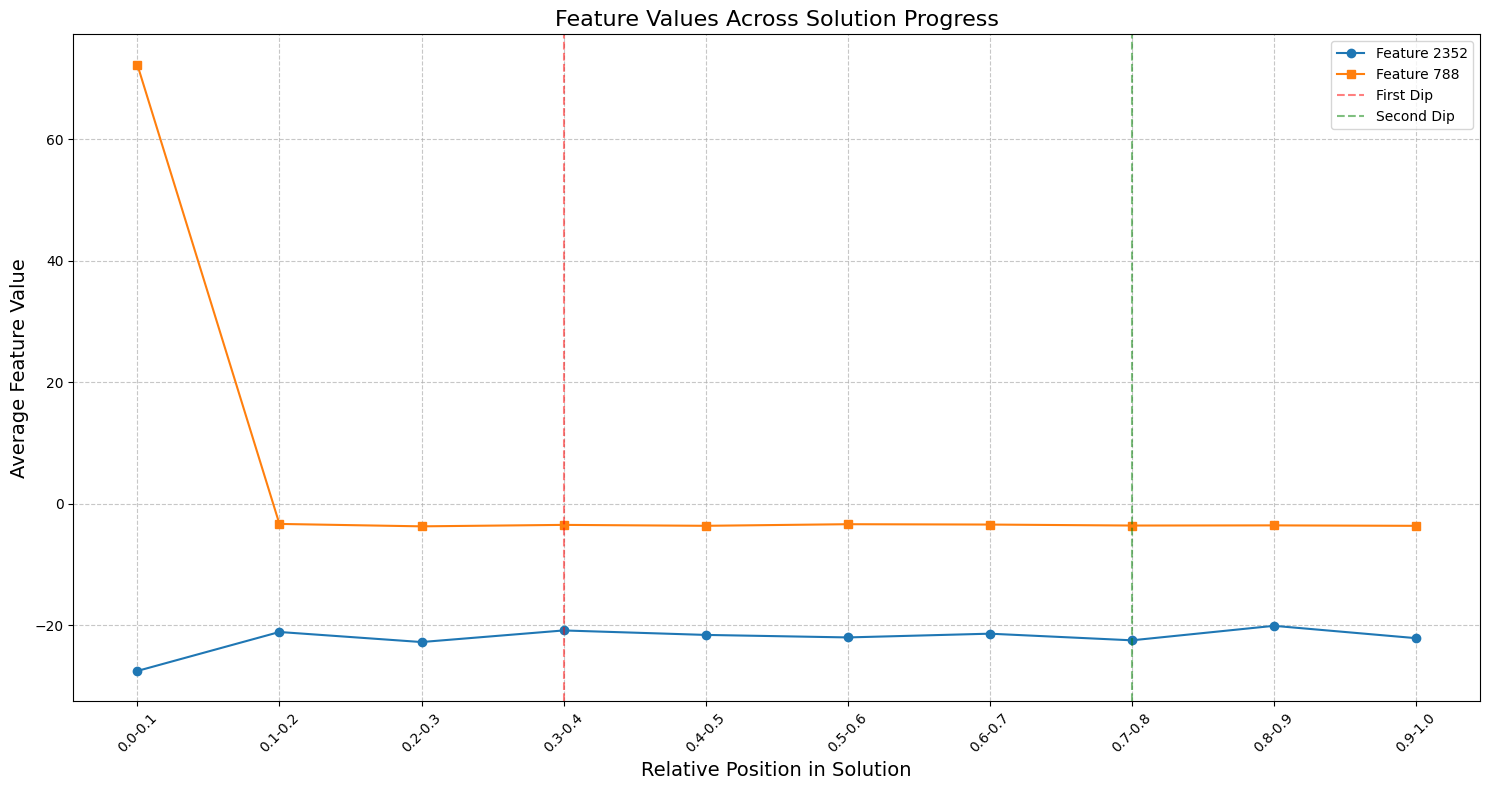

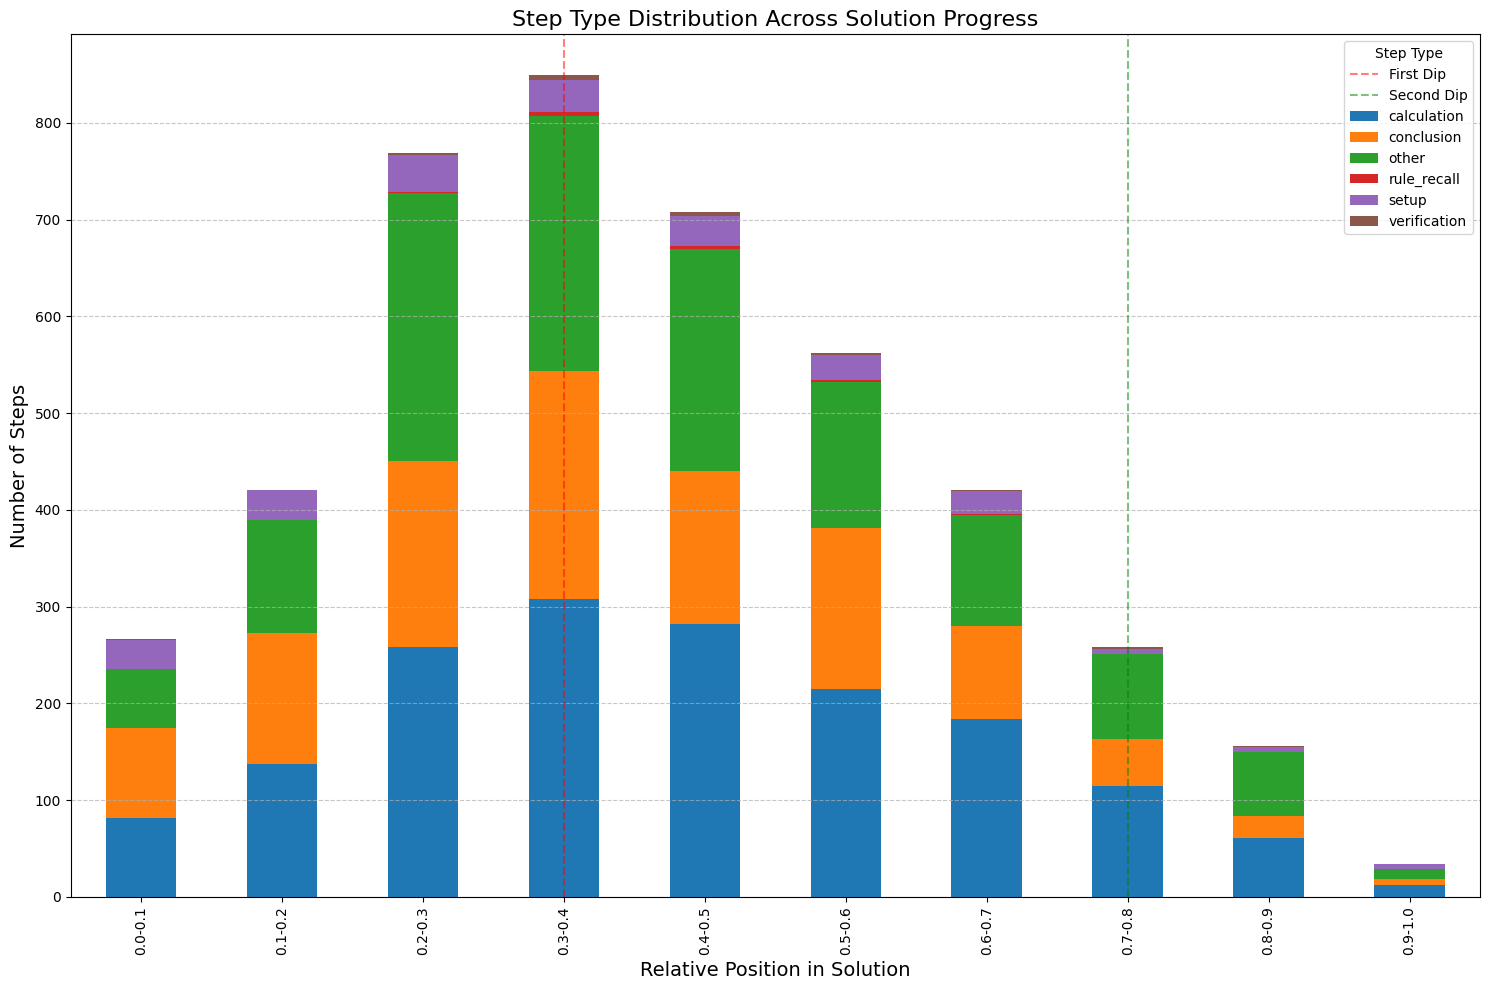

In [ ]:
# Let's analyze the dips in the 2352 & 788 interaction specifically
# Also looking at specific type of phrases
def analyze_dips_better(data, feature1=2352, feature2=788):
    """Better analysis of what happens at the dips in feature interactions."""
    # Track data by position
    position_data = []
    
    for result_idx, result in enumerate(data['results']):
        for step_idx, step_feature in enumerate(result['step_features']):
            # Skip if step_idx is out of range for steps
            if step_idx >= len(result['steps']):
                continue
                
            relative_pos = step_idx / len(result['step_features'])
            
            # Get feature values
            feature1_val = None
            feature2_val = None
            
            # Check negative features
            for feat in step_feature['top_negative_features']:
                if feat['index'] == feature1:
                    feature1_val = feat['value']
                if feat['index'] == feature2:
                    feature2_val = feat['value']
            
            # Check positive features
            for feat in step_feature['top_positive_features']:
                if feat['index'] == feature1:
                    feature1_val = feat['value']
                if feat['index'] == feature2:
                    feature2_val = feat['value']
            
            # If both features are active
            if feature1_val is not None and feature2_val is not None:
                # Get step text
                step_text = result['steps'][step_idx]
                
                # Determine step type more carefully
                step_type = 'other'
                if any(w in step_text.lower() for w in ['therefore', 'thus', 'hence', 'so', 'answer']):
                    step_type = 'conclusion'
                elif any(w in step_text.lower() for w in ['let', 'assume', 'given', 'first']):
                    step_type = 'setup'
                elif any(w in step_text.lower() for w in ['=', '+', '-', '*', '/', 'calculate', 'compute']):
                    step_type = 'calculation'
                elif any(w in step_text.lower() for w in ['recall', 'note', 'observe', 'rule']):
                    step_type = 'rule_recall'
                elif any(w in step_text.lower() for w in ['check', 'verify', 'confirm', 'test']):
                    step_type = 'verification'
                
                position_data.append({
                    'problem_id': result_idx,
                    'category': result['category'],
                    'step_idx': step_idx,
                    'relative_pos': relative_pos,
                    'feature1_val': feature1_val,
                    'feature2_val': feature2_val,
                    'step_text': step_text,
                    'step_type': step_type,
                    'is_correct': result['matches_dataset']
                })
    
    # Convert to DataFrame
    df = pd.DataFrame(position_data)
    
    # Bin by position
    df['position_bin'] = pd.cut(df['relative_pos'], bins=10, labels=[f"{i/10:.1f}-{(i+1)/10:.1f}" for i in range(10)])
    
    # Calculate average feature values by position
    avg_by_position = df.groupby('position_bin').agg({
        'feature1_val': 'mean',
        'feature2_val': 'mean',
        'problem_id': 'count'
    }).rename(columns={'problem_id': 'count'})
    
    # Calculate step type distribution by position
    step_types_by_position = df.groupby(['position_bin', 'step_type']).size().unstack(fill_value=0)
    
    return df, avg_by_position, step_types_by_position

# Run the improved analysis
dip_df, avg_by_position, step_types_by_position = analyze_dips_better(data)

# Print average feature values by position
print("Average feature values by position:")
print(avg_by_position)

# Print step type distribution by position
print("\nStep type distribution by position:")
print(step_types_by_position)

# Identify the dips
print("\nAnalyzing specific position bins:")
for bin_name in ['0.3-0.4', '0.7-0.8']:
    bin_data = dip_df[dip_df['position_bin'] == bin_name]
    print(f"\nPosition {bin_name}:")
    print(f"Number of steps: {len(bin_data)}")
    print(f"Average Feature 2352 value: {bin_data['feature1_val'].mean():.2f}")
    print(f"Average Feature 788 value: {bin_data['feature2_val'].mean():.2f}")
    print("Step types:")
    print(bin_data['step_type'].value_counts())
    
    # Show examples of each step type
    for step_type in bin_data['step_type'].unique():
        type_examples = bin_data[bin_data['step_type'] == step_type].head(2)
        print(f"\nExamples of {step_type} steps:")
        for i, row in type_examples.iterrows():
            print(f"Problem {row['problem_id']}, Step {row['step_idx']}:")
            print(f"Feature 2352: {row['feature1_val']:.2f}, Feature 788: {row['feature2_val']:.2f}")
            print(f"Text: {row['step_text'][:100]}..." if len(row['step_text']) > 100 else f"Text: {row['step_text']}")
            print()

# Visualize the feature values across positions
plt.figure(figsize=(15, 8))
plt.plot(avg_by_position.index, avg_by_position['feature1_val'], label='Feature 2352', marker='o')
plt.plot(avg_by_position.index, avg_by_position['feature2_val'], label='Feature 788', marker='s')
plt.axvline(x='0.3-0.4', color='r', linestyle='--', alpha=0.5, label='First Dip')
plt.axvline(x='0.7-0.8', color='g', linestyle='--', alpha=0.5, label='Second Dip')
plt.title('Feature Values Across Solution Progress', fontsize=16)
plt.xlabel('Relative Position in Solution', fontsize=14)
plt.ylabel('Average Feature Value', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize step type distribution
plt.figure(figsize=(15, 10))
step_types_by_position.plot(kind='bar', stacked=True, ax=plt.gca())
plt.axvline(x=3, color='r', linestyle='--', alpha=0.5, label='First Dip')
plt.axvline(x=7, color='g', linestyle='--', alpha=0.5, label='Second Dip')
plt.title('Step Type Distribution Across Solution Progress', fontsize=16)
plt.xlabel('Relative Position in Solution', fontsize=14)
plt.ylabel('Number of Steps', fontsize=14)
plt.legend(title='Step Type')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [2]:
import json
# First, let's identify which problems the model got correct
def find_correct_problems(data):
    """Find problems where the model's answer matched the ground truth."""
    correct_problems = []
    
    for i, result in enumerate(data['results']):
        if result['matches_dataset']:
            correct_problems.append({
                'problem_id': i,
                'prompt': result['prompt'],
                'category': result['category'],
                #'generated_text': result['generated_text'],
                'ground_truth': result['ground_truth']
            })
    
    return correct_problems

# Load the data
with open('layer30_analysis.json', 'r') as f:
    data = json.load(f)

# Find correct problems
correct_problems = find_correct_problems(data)

print(f"Found {len(correct_problems)} correctly solved problems out of {len(data['results'])}.")
with open('correct_problems.json', 'w') as f:
    json.dump(correct_problems, f, indent=2)
# Display a few examples
for i, problem in enumerate(correct_problems):
    print(f"\nProblem {i+1}: {problem['prompt'][:100]}...")
    print(f"Category: {problem['category']}")

Found 14 correctly solved problems out of 50.

Problem 1: Given that the area of a square is equal to the sum of the areas of two squares with side lengths of...
Category: Geometry

Problem 2: Mary had planted 8 potatoes in the garden. The rabbits ate some of the newly grown potatoes, leaving...
Category: Arithmetic

Problem 3: After 10 minutes, A, B, and C were in that order in a cycle race. Thereafter, the leader changed 19 ...
Category: Algebra

Problem 4: Given \( A, B \in [0, 1] \) and the equations \( ax^2 + bxy + cy^2 \equiv (Ax + (1 - A)y)^2 \) and \...
Category: Algebra

Problem 5: What is the value of $0.\overline{234} - 0.\overline{567} + 0.\overline{891}$? Express your answer a...
Category: Decimal Representation and Operations

Problem 6: Calculate $\frac{1}{5} \cdot \frac{2}{6} \cdot \frac{3}{7} \cdot \frac{4}{8} \cdots \frac{49}{53} \c...
Category: Fractions

Problem 7: The ratio of the number of students in grades 10, 11, and 12 of a certain high school is $4:4:5$. Us..


=== Feature Activation Analysis for Problem ===
Given that the area of a square is equal to the sum of the areas of two squares with side lengths of...

Most frequent positive features in baseline:
  Feature 290: 109 appearances
  Feature 2252: 53 appearances
  Feature 2485: 50 appearances
  Feature 1658: 46 appearances
  Feature 2992: 30 appearances

Most frequent negative features in baseline:
  Feature 2352: 132 appearances
  Feature 1421: 62 appearances
  Feature 912: 61 appearances
  Feature 788: 61 appearances
  Feature 1189: 35 appearances


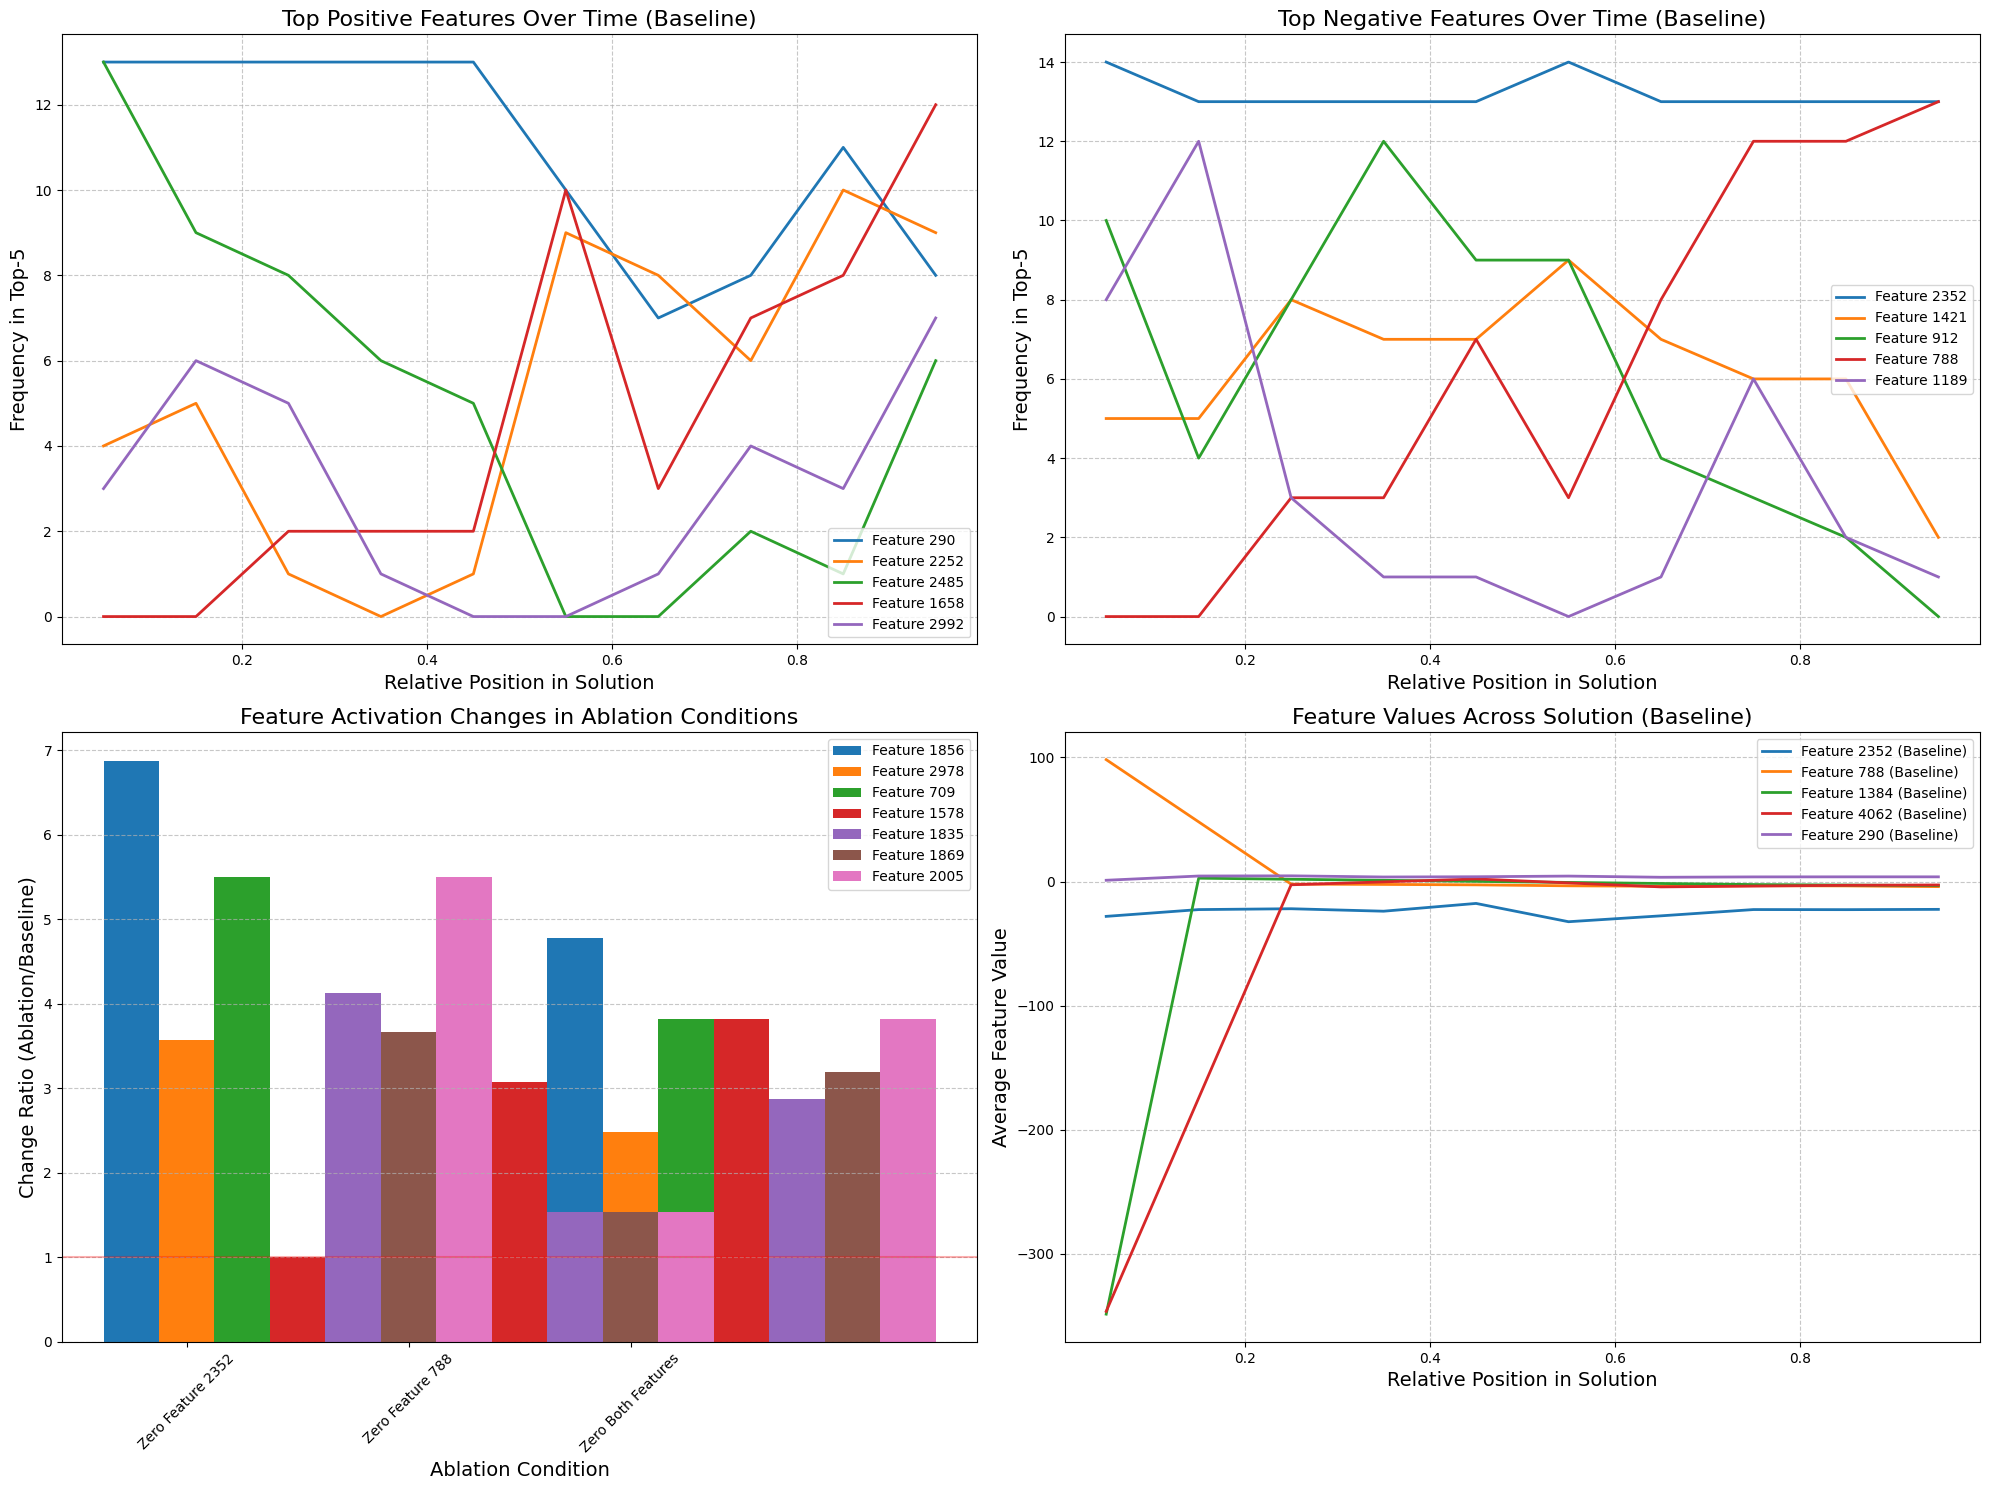

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import json
def analyze_feature_activations(results_file):
    """
    Analyze how feature activations change across different ablation conditions.
    
    Args:
        results_file: Path to the JSON file with ablation results
    """
    # Load the results
    with open(results_file, 'r') as f:
        all_results = json.load(f)
    
    # Process each problem
    for prompt, problem_results in all_results.items():
        print(f"\n=== Feature Activation Analysis for Problem ===")
        print(prompt[:100] + "...")
        
        # Get baseline result
        baseline = problem_results.get('Baseline (No Ablation)')
        if not baseline or 'step_features' not in baseline:
            print("Baseline step features not found!")
            continue
        
        # Track top features across steps
        baseline_top_features = {
            'positive': {},
            'negative': {}
        }
        
        # Process baseline features
        for step_idx, step_feature in enumerate(baseline['step_features']):
            # Track relative position
            relative_pos = step_idx / len(baseline['step_features'])
            pos_bin = int(relative_pos * 10)  # 0-9 bins
            
            # Process top positive features
            for feat in step_feature['top_positive_features']:
                feat_idx = feat['index']
                if feat_idx not in baseline_top_features['positive']:
                    baseline_top_features['positive'][feat_idx] = [0] * 10  # 10 bins
                baseline_top_features['positive'][feat_idx][pos_bin] += 1
            
            # Process top negative features
            for feat in step_feature['top_negative_features']:
                feat_idx = feat['index']
                if feat_idx not in baseline_top_features['negative']:
                    baseline_top_features['negative'][feat_idx] = [0] * 10  # 10 bins
                baseline_top_features['negative'][feat_idx][pos_bin] += 1
        
        # Find most frequent features
        top_pos_features = sorted(
            [(k, sum(v)) for k, v in baseline_top_features['positive'].items()],
            key=lambda x: x[1],
            reverse=True
        )[:5]
        
        top_neg_features = sorted(
            [(k, sum(v)) for k, v in baseline_top_features['negative'].items()],
            key=lambda x: x[1],
            reverse=True
        )[:5]
        
        print("\nMost frequent positive features in baseline:")
        for feat_idx, count in top_pos_features:
            print(f"  Feature {feat_idx}: {count} appearances")
        
        print("\nMost frequent negative features in baseline:")
        for feat_idx, count in top_neg_features:
            print(f"  Feature {feat_idx}: {count} appearances")
        
        # Create plots
        plt.figure(figsize=(20, 15))
        
        # 1. Top Positive Features Over Time (Baseline)
        plt.subplot(2, 2, 1)
        x = np.linspace(0.05, 0.95, 10)  # Bin centers
        
        for feat_idx, _ in top_pos_features:
            plt.plot(x, baseline_top_features['positive'][feat_idx], 
                     label=f'Feature {feat_idx}', linewidth=2)
        
        plt.title('Top Positive Features Over Time (Baseline)', fontsize=16)
        plt.xlabel('Relative Position in Solution', fontsize=14)
        plt.ylabel('Frequency in Top-5', fontsize=14)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # 2. Top Negative Features Over Time (Baseline)
        plt.subplot(2, 2, 2)
        
        for feat_idx, _ in top_neg_features:
            plt.plot(x, baseline_top_features['negative'][feat_idx], 
                     label=f'Feature {feat_idx}', linewidth=2)
        
        plt.title('Top Negative Features Over Time (Baseline)', fontsize=16)
        plt.xlabel('Relative Position in Solution', fontsize=14)
        plt.ylabel('Frequency in Top-5', fontsize=14)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # 3. Feature Compensation Analysis
        plt.subplot(2, 2, 3)
        
        # Compare feature activations across conditions
        conditions = [
            'Zero Feature 2352',
            'Zero Feature 788',
            'Zero Both Features'
        ]
        
        # Track feature changes
        feature_changes = {}
        
        for condition in conditions:
            if condition not in problem_results:
                continue
                
            result = problem_results[condition]
            if 'step_features' not in result:
                continue
                
            # Track top features for this condition
            condition_top_features = {
                'positive': {},
                'negative': {}
            }
            
            # Process features
            for step_idx, step_feature in enumerate(result['step_features']):
                # Track relative position
                relative_pos = step_idx / len(result['step_features'])
                pos_bin = int(relative_pos * 10)  # 0-9 bins
                
                # Process top positive features
                for feat in step_feature['top_positive_features']:
                    feat_idx = feat['index']
                    if feat_idx not in condition_top_features['positive']:
                        condition_top_features['positive'][feat_idx] = [0] * 10
                    condition_top_features['positive'][feat_idx][pos_bin] += 1
                
                # Process top negative features
                for feat in step_feature['top_negative_features']:
                    feat_idx = feat['index']
                    if feat_idx not in condition_top_features['negative']:
                        condition_top_features['negative'][feat_idx] = [0] * 10
                    condition_top_features['negative'][feat_idx][pos_bin] += 1
            
            # Find features that became more prominent
            for feat_type in ['positive', 'negative']:
                for feat_idx, counts in condition_top_features[feat_type].items():
                    # Skip zeroed features
                    if (feat_idx == 2352 and '2352' in condition) or \
                       (feat_idx == 788 and '788' in condition):
                        continue
                        
                    # Get baseline counts for this feature
                    baseline_counts = baseline_top_features[feat_type].get(feat_idx, [0] * 10)
                    
                    # Calculate change
                    total_baseline = sum(baseline_counts)
                    total_condition = sum(counts)
                    
                    if feat_idx not in feature_changes:
                        feature_changes[feat_idx] = {
                            'type': feat_type,
                            'changes': {}
                        }
                    
                    # Store normalized change
                    if total_baseline > 0 and total_condition > 0:
                        # Normalize by number of steps
                        baseline_norm = [c / len(baseline['step_features']) for c in baseline_counts]
                        condition_norm = [c / len(result['step_features']) for c in counts]
                        
                        # Calculate change ratio
                        change_ratio = sum(condition_norm) / sum(baseline_norm)
                        feature_changes[feat_idx]['changes'][condition] = change_ratio
        
        # Find features with biggest changes
        significant_changes = []
        for feat_idx, data in feature_changes.items():
            for condition, change_ratio in data['changes'].items():
                if change_ratio > 1.5 or change_ratio < 0.5:  # 50% change threshold
                    significant_changes.append((feat_idx, data['type'], condition, change_ratio))
        
        # Sort by magnitude of change
        significant_changes.sort(key=lambda x: abs(x[3] - 1), reverse=True)
        
        # Plot feature changes
        features_to_plot = set()
        for feat_idx, _, _, _ in significant_changes[:10]:  # Top 10 changes
            features_to_plot.add(feat_idx)
        
        # Prepare data for plotting
        plot_data = []
        for feat_idx in features_to_plot:
            for condition in conditions:
                if condition in problem_results:
                    change_ratio = feature_changes.get(feat_idx, {}).get('changes', {}).get(condition, 1.0)
                    plot_data.append((feat_idx, condition, change_ratio))
        
        # Group by feature
        by_feature = {}
        for feat_idx, condition, change_ratio in plot_data:
            if feat_idx not in by_feature:
                by_feature[feat_idx] = []
            by_feature[feat_idx].append((condition, change_ratio))
        
        # Plot
        for i, (feat_idx, changes) in enumerate(by_feature.items()):
            x_pos = np.arange(len(changes))
            conditions = [c[0] for c in changes]
            ratios = [c[1] for c in changes]
            
            plt.bar(x_pos + i*0.25, ratios, width=0.25, 
                    label=f'Feature {feat_idx}')
        
        plt.axhline(y=1.0, color='r', linestyle='-', alpha=0.3)
        plt.title('Feature Activation Changes in Ablation Conditions', fontsize=16)
        plt.xlabel('Ablation Condition', fontsize=14)
        plt.ylabel('Change Ratio (Ablation/Baseline)', fontsize=14)
        plt.xticks(np.arange(len(conditions)) + 0.25, conditions, rotation=45)
        plt.legend()
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        
        # 4. Feature Value Analysis
        plt.subplot(2, 2, 4)
        
        # Track feature values
        feature_values = {
            'baseline': {},
            'zero_2352': {},
            'zero_788': {},
            'zero_both': {}
        }
        
        # Process baseline
        for step_idx, step_feature in enumerate(baseline['step_features']):
            relative_pos = step_idx / len(baseline['step_features'])
            pos_bin = int(relative_pos * 10)
            
            # Process all features
            for feat_type in ['positive', 'negative']:
                feat_list = step_feature['top_positive_features'] if feat_type == 'positive' else step_feature['top_negative_features']
                
                for feat in feat_list:
                    feat_idx = feat['index']
                    feat_val = feat['value']
                    
                    if feat_idx not in feature_values['baseline']:
                        feature_values['baseline'][feat_idx] = {
                            'type': feat_type,
                            'values': [[] for _ in range(10)]
                        }
                    
                    feature_values['baseline'][feat_idx]['values'][pos_bin].append(feat_val)
        
        # Process ablation conditions
        condition_keys = {
            'Zero Feature 2352': 'zero_2352',
            'Zero Feature 788': 'zero_788',
            'Zero Both Features': 'zero_both'
        }
        
        for condition, key in condition_keys.items():
            if condition not in problem_results:
                continue
                
            result = problem_results[condition]
            if 'step_features' not in result:
                continue
                
            for step_idx, step_feature in enumerate(result['step_features']):
                relative_pos = step_idx / len(result['step_features'])
                pos_bin = int(relative_pos * 10)
                
                # Process all features
                for feat_type in ['positive', 'negative']:
                    feat_list = step_feature['top_positive_features'] if feat_type == 'positive' else step_feature['top_negative_features']
                    
                    for feat in feat_list:
                        feat_idx = feat['index']
                        feat_val = feat['value']
                        
                        if feat_idx not in feature_values[key]:
                            feature_values[key][feat_idx] = {
                                'type': feat_type,
                                'values': [[] for _ in range(10)]
                            }
                        
                        feature_values[key][feat_idx]['values'][pos_bin].append(feat_val)
        
        # Plot feature values for key features
        key_features = [2352, 788, 1384, 4062, 290]  # Top features from initial state
        
        for feat_idx in key_features:
            if feat_idx in feature_values['baseline']:
                # Calculate average values per bin
                baseline_vals = feature_values['baseline'][feat_idx]['values']
                baseline_avgs = []
                
                for bin_idx, vals in enumerate(baseline_vals):
                    if vals:
                        baseline_avgs.append((bin_idx/10 + 0.05, np.mean(vals)))
                
                if baseline_avgs:
                    x, y = zip(*baseline_avgs)
                    plt.plot(x, y, label=f'Feature {feat_idx} (Baseline)', linewidth=2)
        
        plt.title('Feature Values Across Solution (Baseline)', fontsize=16)
        plt.xlabel('Relative Position in Solution', fontsize=14)
        plt.ylabel('Average Feature Value', fontsize=14)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()

# Run the analysis
analyze_feature_activations('ablation_results_first_correct_seed_42.json')

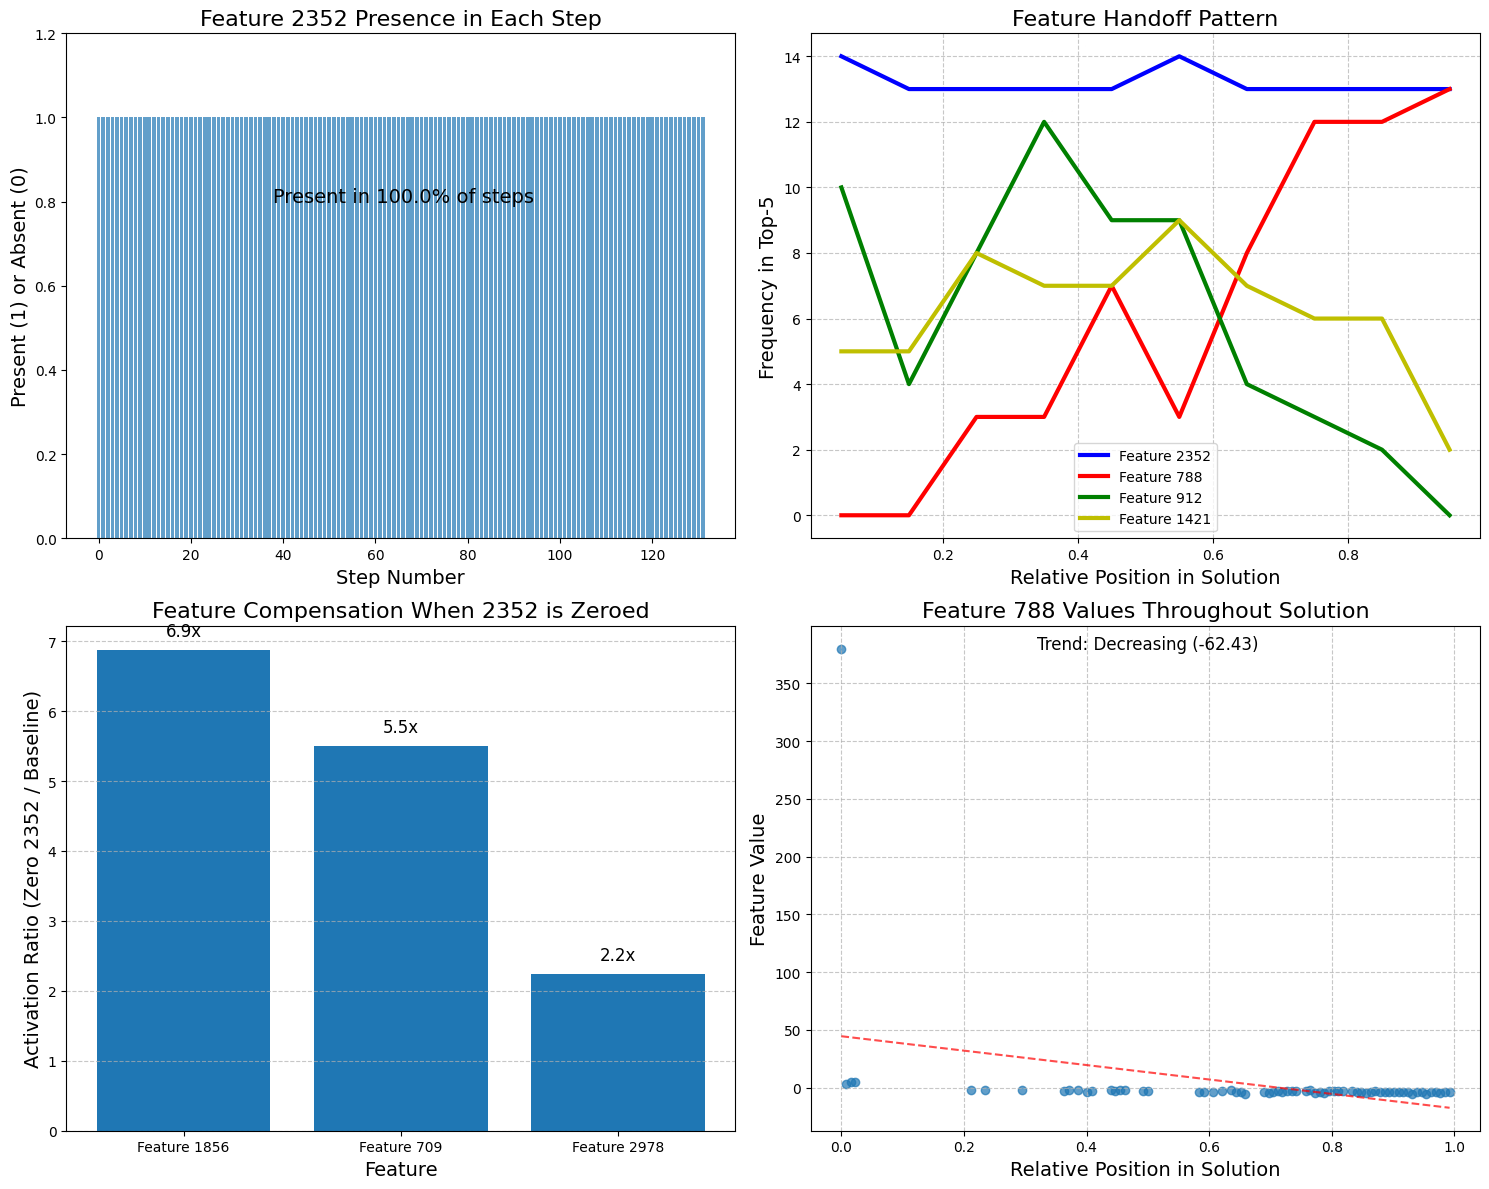

In [4]:
# focus on the specific vis in abalation of 2352
def create_focused_visualization(results_file):
    """Create a clearer, more focused visualization of the key patterns."""
    # Load the results
    with open(results_file, 'r') as f:
        all_results = json.load(f)
    
    # Get the first problem
    prompt, problem_results = next(iter(all_results.items()))
    
    # Get baseline result
    baseline = problem_results.get('Baseline (No Ablation)')
    if not baseline or 'step_features' not in baseline:
        print("Baseline step features not found!")
        return
    
    # Create a figure
    plt.figure(figsize=(15, 12))
    
    # 1. Feature 2352 Presence
    plt.subplot(2, 2, 1)
    
    # Track 2352 appearances
    steps = len(baseline['step_features'])
    feature_2352_present = [0] * steps
    feature_2352_values = [0] * steps
    
    for step_idx, step_feature in enumerate(baseline['step_features']):
        # Check if 2352 is in top negative features
        for feat in step_feature['top_negative_features']:
            if feat['index'] == 2352:
                feature_2352_present[step_idx] = 1
                feature_2352_values[step_idx] = feat['value']
                break
    
    # Plot presence
    plt.bar(range(steps), feature_2352_present, alpha=0.7)
    plt.title('Feature 2352 Presence in Each Step', fontsize=16)
    plt.xlabel('Step Number', fontsize=14)
    plt.ylabel('Present (1) or Absent (0)', fontsize=14)
    plt.ylim(0, 1.2)
    
    # Add text showing percentage
    presence_pct = sum(feature_2352_present) / steps * 100
    plt.text(steps/2, 0.8, f"Present in {presence_pct:.1f}% of steps", 
             horizontalalignment='center', fontsize=14)
    
    # 2. Feature Handoff Pattern
    plt.subplot(2, 2, 2)
    
    # Track key features
    key_features = [2352, 788, 912, 1421]
    feature_counts = {feat: [0] * 10 for feat in key_features}  # 10 bins
    
    for step_idx, step_feature in enumerate(baseline['step_features']):
        # Calculate bin
        bin_idx = min(int(step_idx / steps * 10), 9)
        
        # Check negative features
        for feat in step_feature['top_negative_features']:
            if feat['index'] in key_features:
                feature_counts[feat['index']][bin_idx] += 1
    
    # Plot handoff pattern
    x = np.linspace(0.05, 0.95, 10)  # Bin centers
    
    plt.plot(x, feature_counts[2352], 'b-', linewidth=3, label='Feature 2352')
    plt.plot(x, feature_counts[788], 'r-', linewidth=3, label='Feature 788')
    plt.plot(x, feature_counts[912], 'g-', linewidth=3, label='Feature 912')
    plt.plot(x, feature_counts[1421], 'y-', linewidth=3, label='Feature 1421')
    
    plt.title('Feature Handoff Pattern', fontsize=16)
    plt.xlabel('Relative Position in Solution', fontsize=14)
    plt.ylabel('Frequency in Top-5', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 3. Feature Compensation
    plt.subplot(2, 2, 3)
    
    # Get the top compensating features
    compensating_features = [1856, 709, 2978]  # From previous analysis
    
    # Prepare data
    conditions = ['Baseline', 'Zero Feature 2352']
    feature_data = {feat: [0, 0] for feat in compensating_features}  # [baseline, zero_2352]
    
    # Get baseline data
    for step_feature in baseline['step_features']:
        for feat_list in [step_feature['top_positive_features'], step_feature['top_negative_features']]:
            for feat in feat_list:
                if feat['index'] in compensating_features:
                    feature_data[feat['index']][0] += 1
    
    # Get zero_2352 data
    zero_2352 = problem_results.get('Zero Feature 2352')
    if zero_2352 and 'step_features' in zero_2352:
        for step_feature in zero_2352['step_features']:
            for feat_list in [step_feature['top_positive_features'], step_feature['top_negative_features']]:
                for feat in feat_list:
                    if feat['index'] in compensating_features:
                        feature_data[feat['index']][1] += 1
    
    # Normalize by number of steps
    baseline_steps = len(baseline['step_features'])
    zero_2352_steps = len(zero_2352['step_features']) if zero_2352 else 0
    
    if baseline_steps > 0 and zero_2352_steps > 0:
        for feat in compensating_features:
            feature_data[feat][0] /= baseline_steps
            feature_data[feat][1] /= zero_2352_steps
    
    # Calculate ratios
    ratios = {feat: data[1]/data[0] if data[0] > 0 else 0 for feat, data in feature_data.items()}
    
    # Plot
    plt.bar(range(len(compensating_features)), list(ratios.values()))
    plt.xticks(range(len(compensating_features)), [f"Feature {f}" for f in compensating_features])
    plt.title('Feature Compensation When 2352 is Zeroed', fontsize=16)
    plt.xlabel('Feature', fontsize=14)
    plt.ylabel('Activation Ratio (Zero 2352 / Baseline)', fontsize=14)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add text showing ratios
    for i, (feat, ratio) in enumerate(ratios.items()):
        plt.text(i, ratio + 0.2, f"{ratio:.1f}x", 
                 horizontalalignment='center', fontsize=12)
    
    # 4. Feature 788 Value Pattern
    plt.subplot(2, 2, 4)
    
    # Track Feature 788 values
    feature_788_values = []
    
    for step_idx, step_feature in enumerate(baseline['step_features']):
        relative_pos = step_idx / steps
        
        # Check positive features
        for feat in step_feature['top_positive_features']:
            if feat['index'] == 788:
                feature_788_values.append((relative_pos, feat['value']))
                break
                
        # Check negative features
        for feat in step_feature['top_negative_features']:
            if feat['index'] == 788:
                feature_788_values.append((relative_pos, feat['value']))
                break
    
    # Plot values
    if feature_788_values:
        x, y = zip(*feature_788_values)
        plt.scatter(x, y, alpha=0.7)
        
        # Add trend line
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x), "r--", alpha=0.7)
        
        plt.title('Feature 788 Values Throughout Solution', fontsize=16)
        plt.xlabel('Relative Position in Solution', fontsize=14)
        plt.ylabel('Feature Value', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Add text showing trend
        slope = z[0]
        plt.text(0.5, max(y), f"Trend: {'Increasing' if slope > 0 else 'Decreasing'} ({slope:.2f})", 
                 horizontalalignment='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Run the focused visualization
create_focused_visualization('ablation_results_first_correct_seed_42.json')

# Analysis of data from abalation experiments

=== Aggregated Feature Activation Analysis Across All Problems ===
Total problems: 14

Most frequent positive features across all problems:
  Feature 290: 1675 appearances, present in 100.0% of problems
  Feature 2252: 834 appearances, present in 100.0% of problems
  Feature 2485: 756 appearances, present in 100.0% of problems
  Feature 761: 747 appearances, present in 100.0% of problems
  Feature 1658: 607 appearances, present in 100.0% of problems
  Feature 133: 524 appearances, present in 100.0% of problems
  Feature 2992: 390 appearances, present in 100.0% of problems
  Feature 682: 324 appearances, present in 100.0% of problems
  Feature 2261: 292 appearances, present in 100.0% of problems
  Feature 2219: 279 appearances, present in 92.9% of problems

Most frequent negative features across all problems:
  Feature 2352: 2380 appearances, present in 100.0% of problems
  Feature 912: 1009 appearances, present in 100.0% of problems
  Feature 788: 873 appearances, present in 100.0% of 

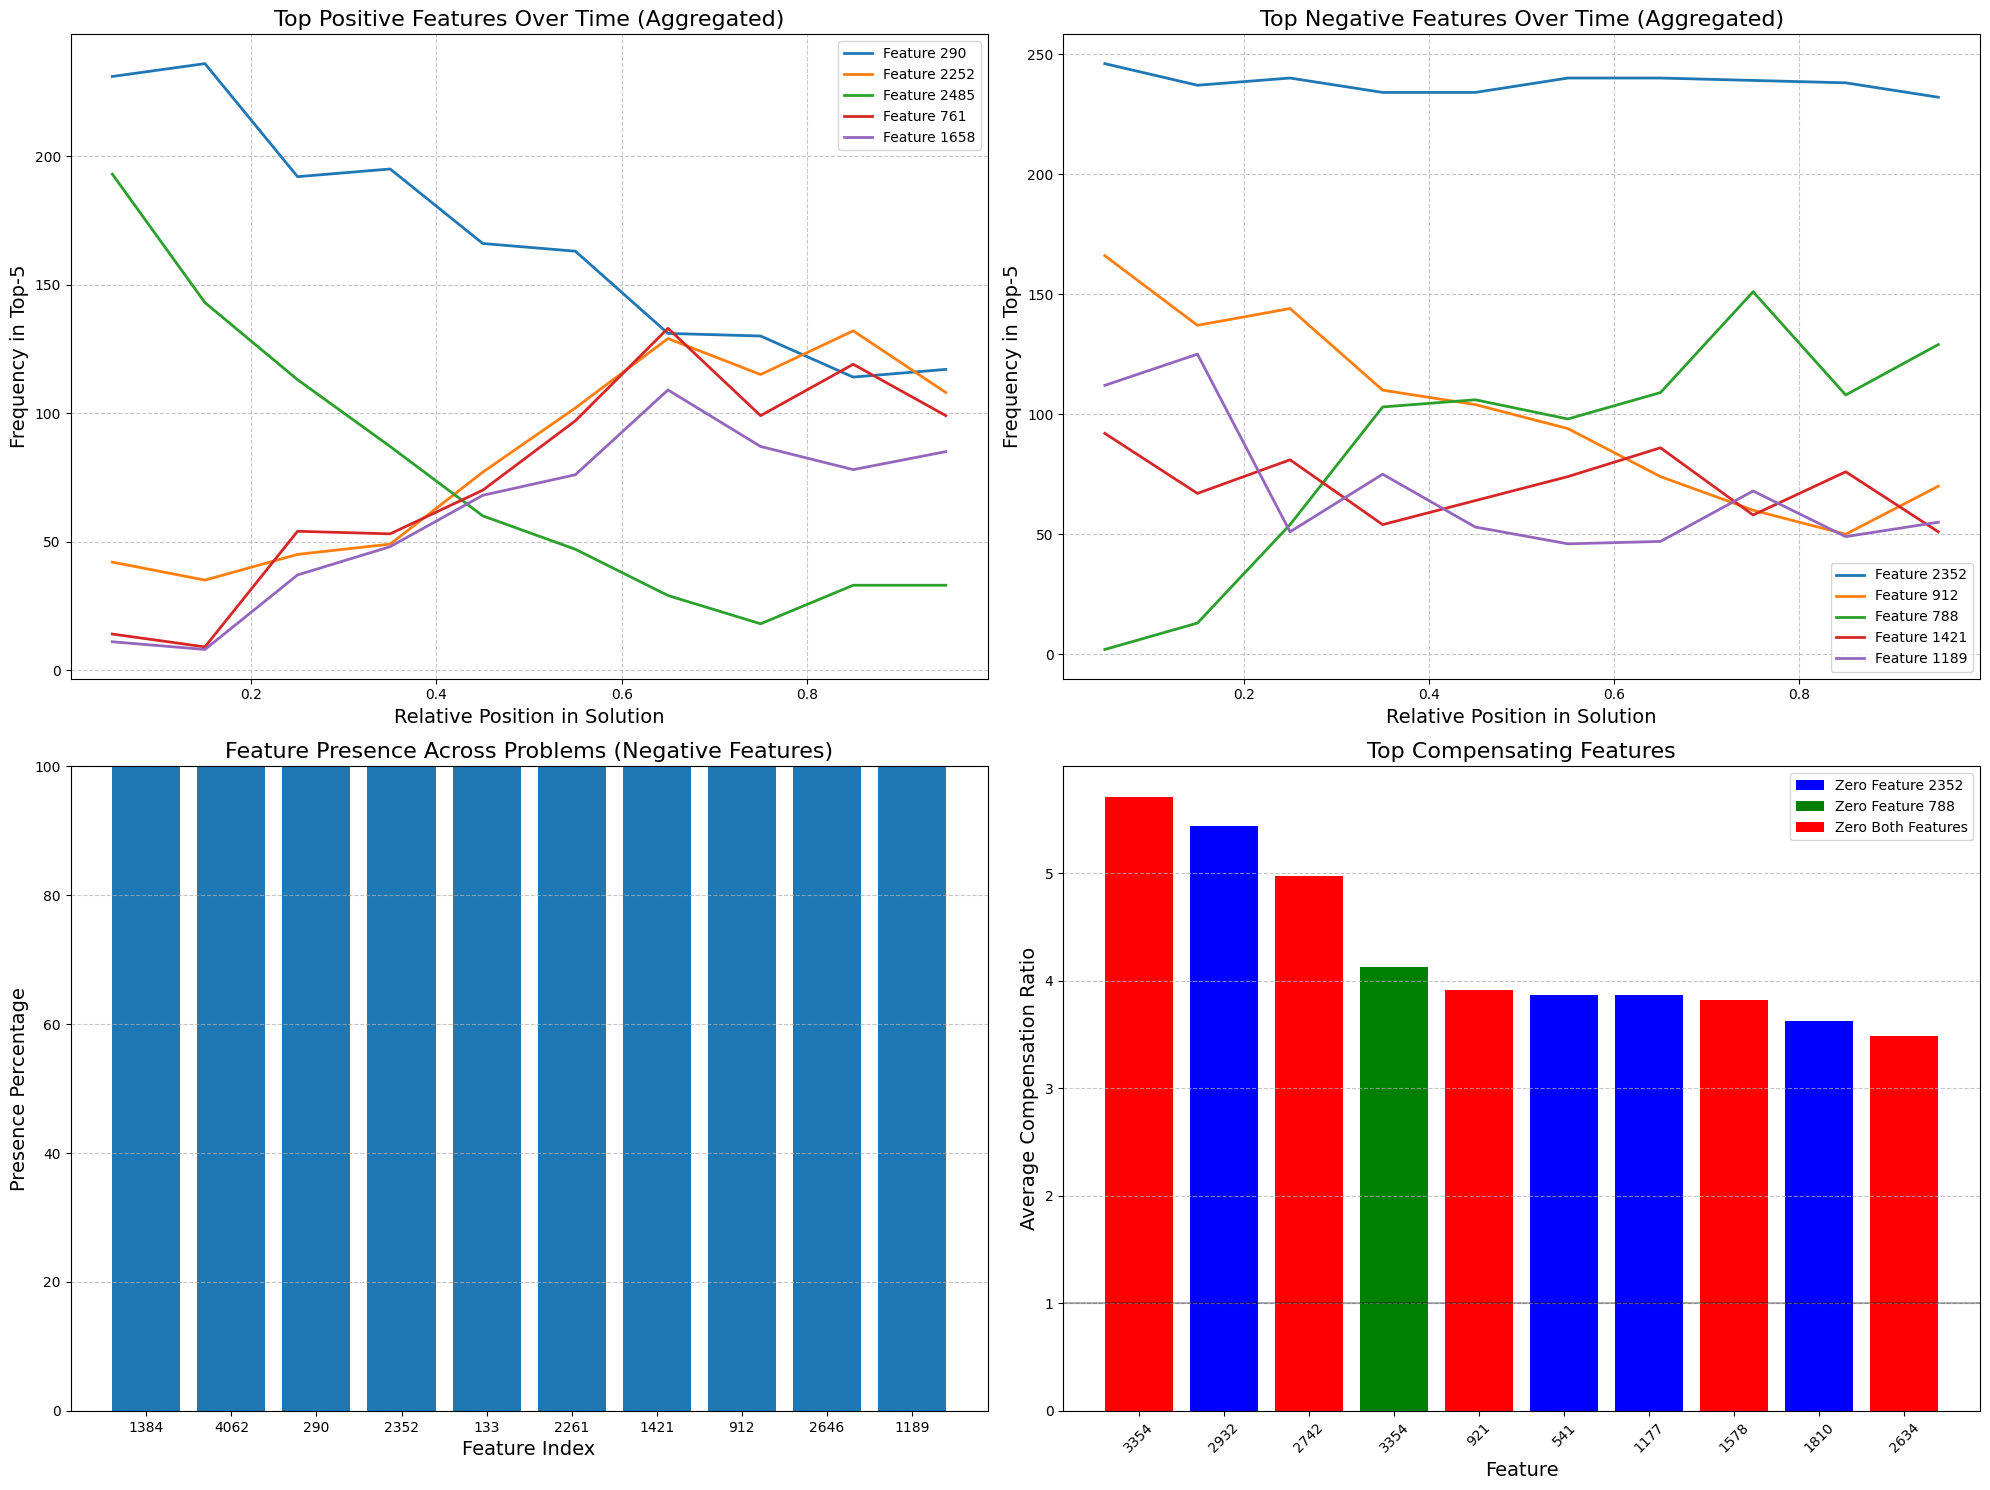

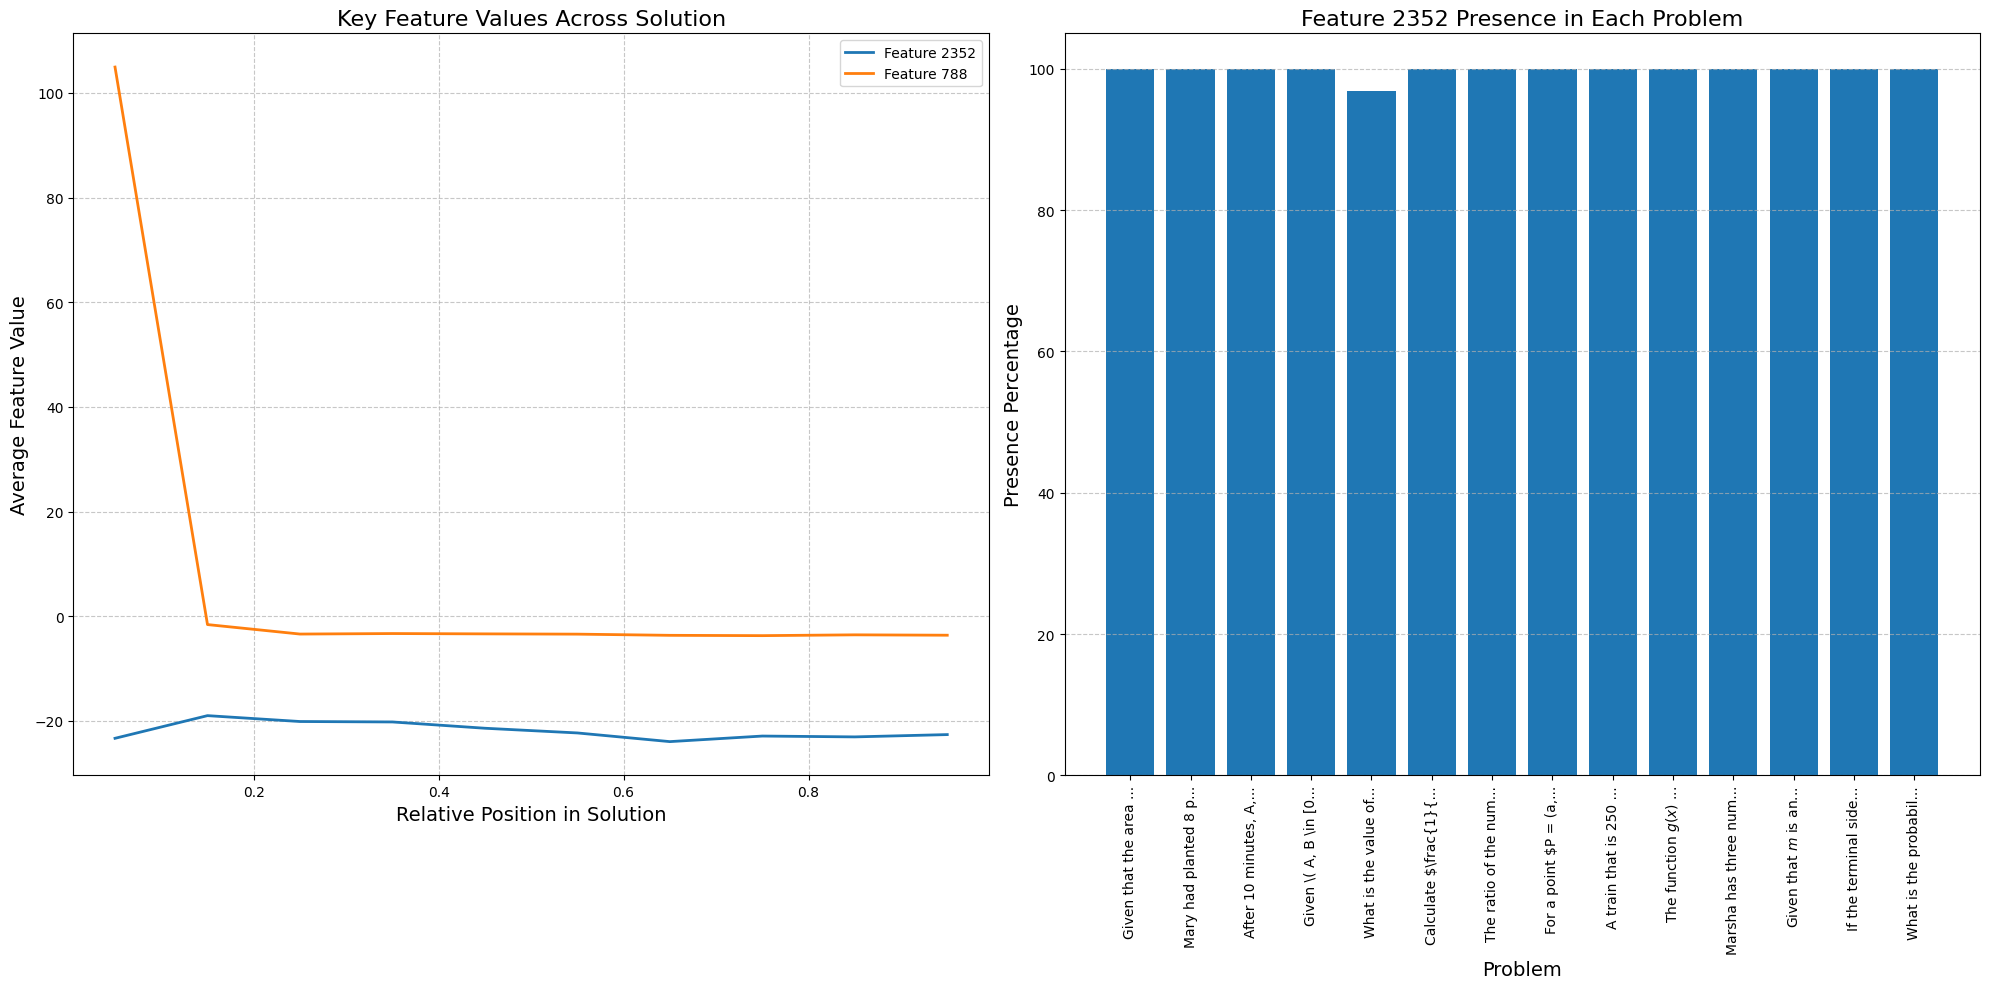

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

def analyze_aggregated_feature_activations(results_file):
    """
    Analyze how feature activations change across different ablation conditions,
    aggregated across all problems.
    
    Args:
        results_file: Path to the JSON file with ablation results
    """
    # Load the results
    with open(results_file, 'r') as f:
        all_results = json.load(f)
    
    print(f"=== Aggregated Feature Activation Analysis Across All Problems ===")
    print(f"Total problems: {len(all_results)}")
    
    # Aggregate data structures
    all_top_features = {
        'positive': {},
        'negative': {}
    }
    
    # Track feature presence across problems
    feature_presence = {
        'positive': {},
        'negative': {}
    }
    
    # Track feature values across all problems
    all_feature_values = {}
    
    # Track compensation patterns
    all_feature_changes = {}
    
    # Process each problem
    problem_count = 0
    for prompt, problem_results in all_results.items():
        # Get baseline result
        baseline = problem_results.get('Baseline (No Ablation)')
        if not baseline or 'step_features' not in baseline:
            continue
            
        problem_count += 1
        
        # Process baseline features
        for step_idx, step_feature in enumerate(baseline['step_features']):
            # Track relative position
            relative_pos = step_idx / len(baseline['step_features'])
            pos_bin = int(relative_pos * 10)  # 0-9 bins
            
            # Process top positive features
            for feat in step_feature['top_positive_features']:
                feat_idx = feat['index']
                
                # Track in aggregated counts
                if feat_idx not in all_top_features['positive']:
                    all_top_features['positive'][feat_idx] = [0] * 10  # 10 bins
                all_top_features['positive'][feat_idx][pos_bin] += 1
                
                # Track presence across problems
                if feat_idx not in feature_presence['positive']:
                    feature_presence['positive'][feat_idx] = set()
                feature_presence['positive'][feat_idx].add(prompt)
                
                # Track feature values
                if feat_idx not in all_feature_values:
                    all_feature_values[feat_idx] = {
                        'type': 'positive',
                        'values': [[] for _ in range(10)]
                    }
                all_feature_values[feat_idx]['values'][pos_bin].append(feat['value'])
            
            # Process top negative features
            for feat in step_feature['top_negative_features']:
                feat_idx = feat['index']
                
                # Track in aggregated counts
                if feat_idx not in all_top_features['negative']:
                    all_top_features['negative'][feat_idx] = [0] * 10  # 10 bins
                all_top_features['negative'][feat_idx][pos_bin] += 1
                
                # Track presence across problems
                if feat_idx not in feature_presence['negative']:
                    feature_presence['negative'][feat_idx] = set()
                feature_presence['negative'][feat_idx].add(prompt)
                
                # Track feature values
                if feat_idx not in all_feature_values:
                    all_feature_values[feat_idx] = {
                        'type': 'negative',
                        'values': [[] for _ in range(10)]
                    }
                all_feature_values[feat_idx]['values'][pos_bin].append(feat['value'])
        
        # Process compensation patterns
        conditions = [
            'Zero Feature 2352',
            'Zero Feature 788',
            'Zero Both Features'
        ]
        
        for condition in conditions:
            if condition not in problem_results:
                continue
                
            result = problem_results[condition]
            if 'step_features' not in result:
                continue
                
            # Track top features for this condition
            condition_top_features = {
                'positive': {},
                'negative': {}
            }
            
            # Process features
            for step_idx, step_feature in enumerate(result['step_features']):
                # Process top positive features
                for feat in step_feature['top_positive_features']:
                    feat_idx = feat['index']
                    if feat_idx not in condition_top_features['positive']:
                        condition_top_features['positive'][feat_idx] = 0
                    condition_top_features['positive'][feat_idx] += 1
                
                # Process top negative features
                for feat in step_feature['top_negative_features']:
                    feat_idx = feat['index']
                    if feat_idx not in condition_top_features['negative']:
                        condition_top_features['negative'][feat_idx] = 0
                    condition_top_features['negative'][feat_idx] += 1
            
            # Get baseline counts for comparison
            baseline_top_features = {
                'positive': {},
                'negative': {}
            }
            
            for step_feature in baseline['step_features']:
                # Process top positive features
                for feat in step_feature['top_positive_features']:
                    feat_idx = feat['index']
                    if feat_idx not in baseline_top_features['positive']:
                        baseline_top_features['positive'][feat_idx] = 0
                    baseline_top_features['positive'][feat_idx] += 1
                
                # Process top negative features
                for feat in step_feature['top_negative_features']:
                    feat_idx = feat['index']
                    if feat_idx not in baseline_top_features['negative']:
                        baseline_top_features['negative'][feat_idx] = 0
                    baseline_top_features['negative'][feat_idx] += 1
            
            # Find features that became more prominent
            for feat_type in ['positive', 'negative']:
                for feat_idx, count in condition_top_features[feat_type].items():
                    # Skip zeroed features
                    if (feat_idx == 2352 and '2352' in condition) or \
                       (feat_idx == 788 and '788' in condition):
                        continue
                        
                    # Get baseline count for this feature
                    baseline_count = baseline_top_features[feat_type].get(feat_idx, 0)
                    
                    # Calculate change ratio
                    if baseline_count > 0:
                        # Normalize by number of steps
                        baseline_norm = baseline_count / len(baseline['step_features'])
                        condition_norm = count / len(result['step_features'])
                        
                        # Calculate change ratio
                        change_ratio = condition_norm / baseline_norm
                        
                        # Store in aggregated changes
                        if feat_idx not in all_feature_changes:
                            all_feature_changes[feat_idx] = {
                                'type': feat_type,
                                'changes': {condition: [] for condition in conditions}
                            }
                        
                        all_feature_changes[feat_idx]['changes'][condition].append(change_ratio)
    
    # Find most frequent features across all problems
    top_pos_features = sorted(
        [(k, sum(v)) for k, v in all_top_features['positive'].items()],
        key=lambda x: x[1],
        reverse=True
    )[:10]
    
    top_neg_features = sorted(
        [(k, sum(v)) for k, v in all_top_features['negative'].items()],
        key=lambda x: x[1],
        reverse=True
    )[:10]
    
    # Calculate feature presence percentages
    pos_presence = {k: len(v) / problem_count * 100 for k, v in feature_presence['positive'].items()}
    neg_presence = {k: len(v) / problem_count * 100 for k, v in feature_presence['negative'].items()}
    
    print("\nMost frequent positive features across all problems:")
    for feat_idx, count in top_pos_features:
        presence = pos_presence.get(feat_idx, 0)
        print(f"  Feature {feat_idx}: {count} appearances, present in {presence:.1f}% of problems")
    
    print("\nMost frequent negative features across all problems:")
    for feat_idx, count in top_neg_features:
        presence = neg_presence.get(feat_idx, 0)
        print(f"  Feature {feat_idx}: {count} appearances, present in {presence:.1f}% of problems")
    
    # Create plots
    plt.figure(figsize=(20, 15))
    
    # 1. Top Positive Features Over Time (Aggregated)
    plt.subplot(2, 2, 1)
    x = np.linspace(0.05, 0.95, 10)  # Bin centers
    
    for feat_idx, _ in top_pos_features[:5]:  # Top 5 for clarity
        plt.plot(x, all_top_features['positive'][feat_idx], 
                 label=f'Feature {feat_idx}', linewidth=2)
    
    plt.title('Top Positive Features Over Time (Aggregated)', fontsize=16)
    plt.xlabel('Relative Position in Solution', fontsize=14)
    plt.ylabel('Frequency in Top-5', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 2. Top Negative Features Over Time (Aggregated)
    plt.subplot(2, 2, 2)
    
    for feat_idx, _ in top_neg_features[:5]:  # Top 5 for clarity
        plt.plot(x, all_top_features['negative'][feat_idx], 
                 label=f'Feature {feat_idx}', linewidth=2)
    
    plt.title('Top Negative Features Over Time (Aggregated)', fontsize=16)
    plt.xlabel('Relative Position in Solution', fontsize=14)
    plt.ylabel('Frequency in Top-5', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 3. Feature Presence Across Problems
    plt.subplot(2, 2, 3)
    
    # Select top features by presence
    top_presence_features = sorted(
        [(k, v) for k, v in neg_presence.items()],
        key=lambda x: x[1],
        reverse=True
    )[:10]
    
    # Plot presence percentages
    feat_indices = [str(k) for k, _ in top_presence_features]
    presence_values = [v for _, v in top_presence_features]
    
    plt.bar(feat_indices, presence_values)
    plt.title('Feature Presence Across Problems (Negative Features)', fontsize=16)
    plt.xlabel('Feature Index', fontsize=14)
    plt.ylabel('Presence Percentage', fontsize=14)
    plt.ylim(0, 100)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 4. Feature Compensation Analysis
    plt.subplot(2, 2, 4)
    
    # Calculate average compensation ratios
    avg_compensation = {}
    for feat_idx, data in all_feature_changes.items():
        avg_compensation[feat_idx] = {}
        for condition, ratios in data['changes'].items():
            if ratios:
                avg_compensation[feat_idx][condition] = sum(ratios) / len(ratios)
    
    # Find features with biggest average changes
    significant_changes = []
    for feat_idx, condition_data in avg_compensation.items():
        for condition, ratio in condition_data.items():
            if ratio > 1.5 or ratio < 0.5:  # 50% change threshold
                significant_changes.append((feat_idx, condition, ratio))
    
    # Sort by magnitude of change
    significant_changes.sort(key=lambda x: abs(x[2] - 1), reverse=True)
    
    # Plot top compensating features
    if significant_changes:
        top_compensating = significant_changes[:10]  # Top 10 for clarity
        
        feat_labels = [f"{x[0]}" for x in top_compensating]
        condition_labels = [x[1] for x in top_compensating]
        ratios = [x[2] for x in top_compensating]
        
        # Create color mapping for conditions
        condition_colors = {
            'Zero Feature 2352': 'blue',
            'Zero Feature 788': 'green',
            'Zero Both Features': 'red'
        }
        
        colors = [condition_colors.get(label, 'gray') for label in condition_labels]
        
        plt.bar(range(len(top_compensating)), ratios, color=colors)
        plt.axhline(y=1.0, color='black', linestyle='-', alpha=0.3)
        plt.title('Top Compensating Features', fontsize=16)
        plt.xlabel('Feature', fontsize=14)
        plt.ylabel('Average Compensation Ratio', fontsize=14)
        plt.xticks(range(len(top_compensating)), feat_labels, rotation=45)
        
        # Add condition legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=color, label=cond) 
                          for cond, color in condition_colors.items()]
        plt.legend(handles=legend_elements)
        
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('aggregated_feature_analysis.png')
    plt.show()
    
    # Create additional plots for key features
    plt.figure(figsize=(20, 10))
    
    # 1. Feature 2352 and 788 Values Across Solution
    plt.subplot(1, 2, 1)
    
    key_features = [2352, 788]
    for feat_idx in key_features:
        if feat_idx in all_feature_values:
            # Calculate average values per bin
            feat_vals = all_feature_values[feat_idx]['values']
            feat_avgs = []
            
            for bin_idx, vals in enumerate(feat_vals):
                if vals:
                    feat_avgs.append((bin_idx/10 + 0.05, np.mean(vals)))
            
            if feat_avgs:
                x, y = zip(*feat_avgs)
                plt.plot(x, y, label=f'Feature {feat_idx}', linewidth=2)
    
    plt.title('Key Feature Values Across Solution', fontsize=16)
    plt.xlabel('Relative Position in Solution', fontsize=14)
    plt.ylabel('Average Feature Value', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 2. Feature 2352 Presence in Each Problem
    plt.subplot(1, 2, 2)
    
    # Calculate 2352 presence percentage for each problem
    feature_2352_presence = []
    problem_labels = []
    
    for prompt, problem_results in all_results.items():
        baseline = problem_results.get('Baseline (No Ablation)')
        if not baseline or 'step_features' not in baseline:
            continue
            
        # Count 2352 appearances
        feature_2352_count = 0
        total_steps = len(baseline['step_features'])
        
        for step_feature in baseline['step_features']:
            for feat in step_feature['top_negative_features']:
                if feat['index'] == 2352:
                    feature_2352_count += 1
                    break
        
        if total_steps > 0:
            presence_pct = feature_2352_count / total_steps * 100
            feature_2352_presence.append(presence_pct)
            problem_labels.append(prompt[:20] + "...")
    
    # Plot presence percentages
    plt.bar(range(len(feature_2352_presence)), feature_2352_presence)
    plt.title('Feature 2352 Presence in Each Problem', fontsize=16)
    plt.xlabel('Problem', fontsize=14)
    plt.ylabel('Presence Percentage', fontsize=14)
    plt.xticks(range(len(problem_labels)), problem_labels, rotation=90)
    plt.ylim(0, 105)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('key_features_analysis.png')
    plt.show()
    
    return {
        'top_pos_features': top_pos_features,
        'top_neg_features': top_neg_features,
        'pos_presence': pos_presence,
        'neg_presence': neg_presence,
        'all_feature_changes': all_feature_changes
    }

# Run the aggregated analysis
aggregated_results = analyze_aggregated_feature_activations('ablation_results_all_correct_seed_42.json')

In [ ]:
#This is where we look for the looping behaviors in the outputs, we use step increases for this.
def analyze_infinite_loop(results_file, problem_index=None):
    """
    Analyze the infinite loop pattern in detail.
    
    Args:
        results_file: Path to the results JSON file
        problem_index: Optional index of the problem to analyze
    """
    # Load the results
    with open(results_file, 'r') as f:
        all_results = json.load(f)
    
    # Find problems with potential loops
    loop_problems = []
    
    for prompt, problem_results in all_results.items():
        baseline = problem_results.get('Baseline (No Ablation)')
        zero_2352 = problem_results.get('Zero Feature 2352')
        
        if not baseline or not zero_2352 or 'steps' not in baseline or 'steps' not in zero_2352:
            continue
        
        baseline_steps = len(baseline['steps'])
        zero_2352_steps = len(zero_2352['steps'])
        
        # Check if zeroing 2352 caused a significant increase in steps
        if zero_2352_steps > baseline_steps * 2:
            loop_problems.append((prompt, baseline_steps, zero_2352_steps))
    
    # Sort by step increase ratio
    loop_problems.sort(key=lambda x: x[2]/x[1], reverse=True)
    
    print(f"Found {len(loop_problems)} problems with potential loops")
    for i, (prompt, baseline_steps, zero_2352_steps) in enumerate(loop_problems):
        print(f"{i+1}. {prompt[:50]}... - Baseline: {baseline_steps} steps, Zero 2352: {zero_2352_steps} steps ({zero_2352_steps/baseline_steps:.1f}x)")
    
    # If problem_index is provided, analyze that specific problem
    if problem_index is not None and 0 <= problem_index < len(loop_problems):
        prompt, _, _ = loop_problems[problem_index]
        
        # Get the problem results
        problem_results = all_results[prompt]
        baseline = problem_results['Baseline (No Ablation)']
        zero_2352 = problem_results['Zero Feature 2352']
        
        # Find repeating sequences in the zeroed steps
        steps = zero_2352['steps']
        
        # Look for repeating sequences
        repetitions = []
        
        for seq_length in range(1, min(10, len(steps) // 2)):
            for i in range(len(steps) - seq_length * 2):
                sequence = steps[i:i+seq_length]
                next_sequence = steps[i+seq_length:i+seq_length*2]
                
                if sequence == next_sequence:
                    # Found a repeating sequence
                    repetition = {
                        'sequence': sequence,
                        'length': seq_length,
                        'start_index': i,
                        'repetitions': 1
                    }
                    
                    # Count how many times it repeats
                    j = i + seq_length * 2
                    while j + seq_length <= len(steps) and steps[j:j+seq_length] == sequence:
                        repetition['repetitions'] += 1
                        j += seq_length
                    
                    repetitions.append(repetition)
        
        # Sort by number of repetitions
        repetitions.sort(key=lambda x: x['repetitions'], reverse=True)
        
        if repetitions:
            # Analyze the top repetition
            top_rep = repetitions[0]
            
            print(f"\n=== Infinite Loop Analysis ===")
            print(f"Problem: {prompt[:100]}...")
            print(f"Loop starts at step {top_rep['start_index'] + 1}")
            print(f"Loop length: {top_rep['length']} steps")
            print(f"Number of repetitions: {top_rep['repetitions']}")
            
            # Print the loop sequence
            print("\nLoop sequence:")
            for i, step in enumerate(top_rep['sequence']):
                print(f"{i+1}. {step}")
            
            # Look for stuttering before the loop
            if top_rep['start_index'] > 0:
                pre_loop_steps = steps[:top_rep['start_index']]
                
                # Look for repeated words
                stuttering = []
                for i, step in enumerate(pre_loop_steps):
                    words = step.split()
                    for j in range(len(words) - 3):
                        if words[j] == words[j+1] == words[j+2]:
                            stuttering.append((i, j, words[j]))
                
                if stuttering:
                    print("\nStuttering detected before the loop:")
                    for step_idx, word_idx, word in stuttering:
                        print(f"Step {step_idx+1}, Word {word_idx+1}: '{word} {word} {word}...'")
                    
                    # Print the step with stuttering
                    for step_idx, word_idx, word in stuttering[:1]:  # Just show the first instance
                        print(f"\nStep with stuttering:")
                        print(pre_loop_steps[step_idx])
            
            # Compare with baseline solution
            baseline_steps = baseline['steps']
            
            # Find where the solutions diverge
            divergence_point = None
            for i in range(min(len(baseline_steps), top_rep['start_index'])):
                if baseline_steps[i] != steps[i]:
                    divergence_point = i
                    break
            
            if divergence_point is not None:
                print(f"\nSolutions diverge at step {divergence_point+1}:")
                print(f"Baseline: {baseline_steps[divergence_point]}")
                print(f"Zero 2352: {steps[divergence_point]}")
            
            # Create visualization
            plt.figure(figsize=(15, 10))
            
            # 1. Step count comparison
            plt.subplot(2, 2, 1)
            plt.bar(['Baseline', 'Zero Feature 2352'], [len(baseline_steps), len(steps)])
            plt.title('Step Count Comparison', fontsize=16)
            plt.ylabel('Number of Steps', fontsize=14)
            plt.grid(True, axis='y', linestyle='--', alpha=0.7)
            
            # 2. Loop visualization
            plt.subplot(2, 2, 2)
            
            # Create a circular layout for the loop
            import networkx as nx
            G = nx.DiGraph()
            
            # Add nodes for each step in the loop
            for i in range(top_rep['length']):
                G.add_node(i)
            
            # Add edges to form the loop
            for i in range(top_rep['length']):
                G.add_edge(i, (i+1) % top_rep['length'])
            
            # Draw the graph
            pos = nx.circular_layout(G)
            nx.draw(G, pos, with_labels=True, node_color='lightblue', 
                    node_size=1000, font_size=12, arrows=True)
            plt.title('Loop Structure', fontsize=16)
            
            # 3. Feature activation comparison
            plt.subplot(2, 2, 3)
            
            # Get feature activations
            baseline_features = baseline['step_features']
            zero_features = zero_2352['step_features']
            
            # Track Feature 2352 in baseline
            feature_2352_values = []
            for step_feature in baseline_features:
                found = False
                for feat in step_feature['top_negative_features']:
                    if feat['index'] == 2352:
                        feature_2352_values.append(feat['value'])
                        found = True
                        break
                if not found:
                    feature_2352_values.append(0)
            
            # Plot Feature 2352 values
            plt.plot(range(len(feature_2352_values)), feature_2352_values, 'b-', label='Feature 2352 (Baseline)')
            plt.axvline(x=divergence_point, color='r', linestyle='--', label='Divergence Point')
            plt.axvline(x=top_rep['start_index'], color='g', linestyle='--', label='Loop Start')
            plt.title('Feature 2352 Activation in Baseline', fontsize=16)
            plt.xlabel('Step Number', fontsize=14)
            plt.ylabel('Feature Value', fontsize=14)
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.7)
            
            # 4. Text comparison
            plt.subplot(2, 2, 4)
            plt.axis('off')
            
            # Create a text box comparing key steps
            text = "Key Steps Comparison:\n\n"
            
            # Add divergence point
            if divergence_point is not None:
                text += f"Divergence (Step {divergence_point+1}):\n"
                text += f"Baseline: {baseline_steps[divergence_point][:50]}...\n"
                text += f"Zero 2352: {steps[divergence_point][:50]}...\n\n"
            
            # Add loop start
            text += f"Loop Start (Step {top_rep['start_index']+1}):\n"
            text += f"{steps[top_rep['start_index']][:50]}...\n\n"
            
            # Add loop sequence
            text += f"Loop Sequence ({top_rep['length']} steps, {top_rep['repetitions']} repetitions):\n"
            for i, step in enumerate(top_rep['sequence']):
                text += f"{i+1}. {step[:30]}...\n"
            
            plt.text(0, 1, text, fontsize=10, verticalalignment='top')
            plt.title('Text Analysis', fontsize=16)
            
            plt.tight_layout()
            plt.savefig('infinite_loop_analysis.png')
            plt.show()
            
            return {
                'prompt': prompt,
                'loop_start': top_rep['start_index'],
                'loop_length': top_rep['length'],
                'repetitions': top_rep['repetitions'],
                'loop_sequence': top_rep['sequence'],
                'divergence_point': divergence_point
            }
        else:
            print(f"No clear repeating patterns found in the steps.")
    
    return None

# Run the analysis
loop_problems = analyze_infinite_loop('ablation_results_all_correct_seed_42.json')

# If you find problems with potential loops, analyze the first one
if loop_problems and len(loop_problems) > 0:
    loop_analysis = analyze_infinite_loop('ablation_results_all_correct_seed_42.json', 0)

Found 5 problems with potential loops
1. After 10 minutes, A, B, and C were in that order i... - Baseline: 304 steps, Zero 2352: 5280 steps (17.4x)
2. Given that $m$ is any real number, point $A(m, m^{... - Baseline: 73 steps, Zero 2352: 439 steps (6.0x)
3. A train that is 250 meters long is running at a sp... - Baseline: 83 steps, Zero 2352: 283 steps (3.4x)
4. The function $g(x)$ satisfies 
\[ g(xy) = \frac{g(... - Baseline: 62 steps, Zero 2352: 182 steps (2.9x)
5. What is the probability that Andrew gets fewer hea... - Baseline: 48 steps, Zero 2352: 124 steps (2.6x)


Analyzing problem: After 10 minutes, A, B, and C were in that order in a cycle race. Thereafter, the leader changed 19 ...
Baseline: 304 steps
Zero Feature 2352: 5280 steps (17.4x increase)

=== Loop Analysis ===
Loop starts at step 418
Loop length: 2 steps
Number of repetitions: 120

Loop sequence:
1. Thus, spot rider falls further.
2. Thus, spot rider is being overtaken again.

Solutions diverge at step 1:
Baseline: After 10 minutes, A, B, and C were in that order in a cycle race. Thereafter, the leader changed 19 times, and the rider in third place changed 17 times. At no time were all three riders abreast. B finished third. Who finished first? The answer is not among the initial positions; it's someone else.
Zero 2352: After 10 minutes, A, B, and C were in that order in a cycle race. Thereafter, the leader changed 19 times, and the rider in third place changed 17 times. At no time were all three riders abreast. B finished third. Who finished first?


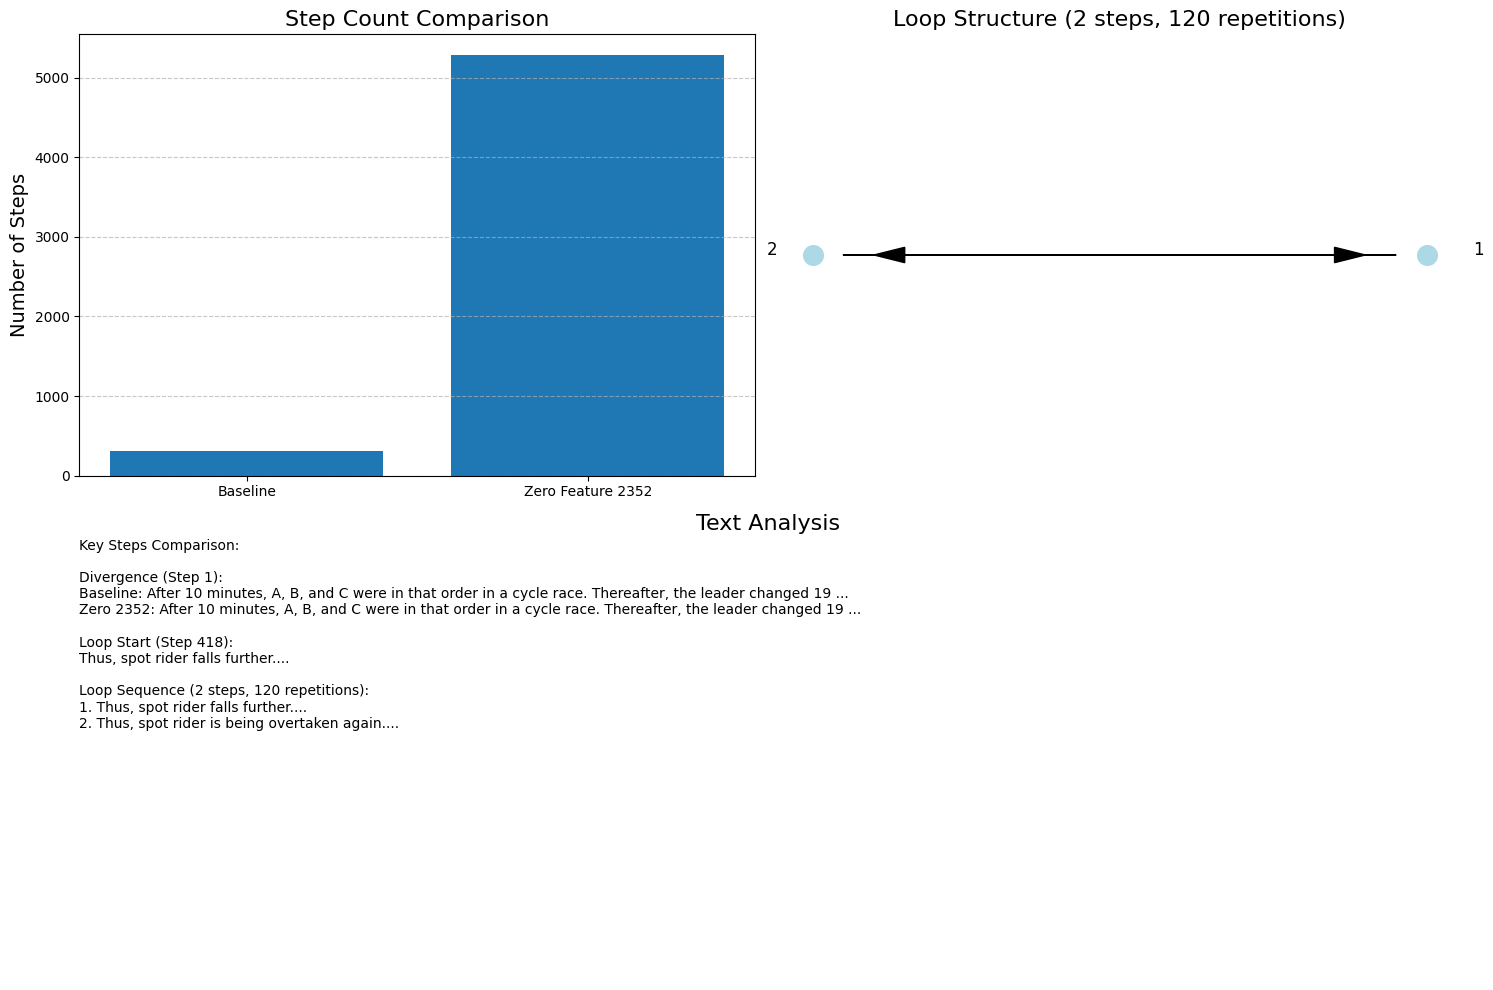

In [ ]:
#This was the infinite loop problem, it reached 50000 tokens and stopped.
def analyze_first_loop_problem(results_file):
    """
    Analyze the first problem with a potential infinite loop in detail.
    """
    # Load the results
    with open(results_file, 'r') as f:
        all_results = json.load(f)
    
    # Find problems with potential loops
    loop_problems = []
    
    for prompt, problem_results in all_results.items():
        baseline = problem_results.get('Baseline (No Ablation)')
        zero_2352 = problem_results.get('Zero Feature 2352')
        
        if not baseline or not zero_2352 or 'steps' not in baseline or 'steps' not in zero_2352:
            continue
        
        baseline_steps = len(baseline['steps'])
        zero_2352_steps = len(zero_2352['steps'])
        
        # Check if zeroing 2352 caused a significant increase in steps
        if zero_2352_steps > baseline_steps * 2:
            loop_problems.append((prompt, problem_results))
    
    # Sort by step increase ratio
    loop_problems.sort(key=lambda x: len(x[1]['Zero Feature 2352']['steps'])/len(x[1]['Baseline (No Ablation)']['steps']), reverse=True)
    
    if not loop_problems:
        print("No problems with potential loops found.")
        return
    
    # Analyze the first problem (with the most dramatic step increase)
    prompt, problem_results = loop_problems[0]
    
    print(f"Analyzing problem: {prompt[:100]}...")
    
    baseline = problem_results['Baseline (No Ablation)']
    zero_2352 = problem_results['Zero Feature 2352']
    
    baseline_steps = baseline['steps']
    zero_steps = zero_2352['steps']
    
    print(f"Baseline: {len(baseline_steps)} steps")
    print(f"Zero Feature 2352: {len(zero_steps)} steps ({len(zero_steps)/len(baseline_steps):.1f}x increase)")
    
    # Find repeating sequences in the zeroed steps
    repetitions = []
    
    for seq_length in range(1, min(10, len(zero_steps) // 2)):
        for i in range(len(zero_steps) - seq_length * 2):
            sequence = zero_steps[i:i+seq_length]
            next_sequence = zero_steps[i+seq_length:i+seq_length*2]
            
            if sequence == next_sequence:
                # Found a repeating sequence
                repetition = {
                    'sequence': sequence,
                    'length': seq_length,
                    'start_index': i,
                    'repetitions': 1
                }
                
                # Count how many times it repeats
                j = i + seq_length * 2
                while j + seq_length <= len(zero_steps) and zero_steps[j:j+seq_length] == sequence:
                    repetition['repetitions'] += 1
                    j += seq_length
                
                repetitions.append(repetition)
    
    # Sort by number of repetitions
    repetitions.sort(key=lambda x: x['repetitions'], reverse=True)
    
    if repetitions:
        # Analyze the top repetition
        top_rep = repetitions[0]
        
        print(f"\n=== Loop Analysis ===")
        print(f"Loop starts at step {top_rep['start_index'] + 1}")
        print(f"Loop length: {top_rep['length']} steps")
        print(f"Number of repetitions: {top_rep['repetitions']}")
        
        # Print the loop sequence
        print("\nLoop sequence:")
        for i, step in enumerate(top_rep['sequence']):
            print(f"{i+1}. {step}")
        
        # Look for stuttering before the loop
        if top_rep['start_index'] > 0:
            pre_loop_steps = zero_steps[:top_rep['start_index']]
            
            # Look for repeated words
            stuttering = []
            for i, step in enumerate(pre_loop_steps):
                words = step.split()
                for j in range(len(words) - 3):
                    if j+2 < len(words) and words[j] == words[j+1] == words[j+2]:
                        stuttering.append((i, j, words[j]))
            
            if stuttering:
                print("\nStuttering detected before the loop:")
                for step_idx, word_idx, word in stuttering:
                    print(f"Step {step_idx+1}, Word {word_idx+1}: '{word} {word} {word}...'")
                
                # Print the step with stuttering
                for step_idx, word_idx, word in stuttering[:1]:  # Just show the first instance
                    print(f"\nStep with stuttering:")
                    print(pre_loop_steps[step_idx])
        
        # Compare with baseline solution
        # Find where the solutions diverge
        divergence_point = None
        for i in range(min(len(baseline_steps), top_rep['start_index'])):
            if baseline_steps[i] != zero_steps[i]:
                divergence_point = i
                break
        
        if divergence_point is not None:
            print(f"\nSolutions diverge at step {divergence_point+1}:")
            print(f"Baseline: {baseline_steps[divergence_point]}")
            print(f"Zero 2352: {zero_steps[divergence_point]}")
        
        # Create visualizations
        plt.figure(figsize=(15, 10))
        
        # 1. Step count comparison
        plt.subplot(2, 2, 1)
        plt.bar(['Baseline', 'Zero Feature 2352'], [len(baseline_steps), len(zero_steps)])
        plt.title('Step Count Comparison', fontsize=16)
        plt.ylabel('Number of Steps', fontsize=14)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        
        # 2. Loop visualization
        plt.subplot(2, 2, 2)
        
        # Create a simple visualization of the loop
        loop_length = top_rep['length']
        repetitions = top_rep['repetitions']
        
        # Create a circular layout
        theta = np.linspace(0, 2*np.pi, loop_length, endpoint=False)
        x = np.cos(theta)
        y = np.sin(theta)
        
        plt.scatter(x, y, s=200, c='lightblue')
        
        # Add step numbers
        for i in range(loop_length):
            plt.text(x[i]*1.15, y[i]*1.15, str(i+1), fontsize=12)
        
        # Add arrows between points
        for i in range(loop_length):
            next_i = (i + 1) % loop_length
            plt.arrow(x[i]*0.9, y[i]*0.9, (x[next_i]-x[i])*0.8, (y[next_i]-y[i])*0.8, 
                     head_width=0.05, head_length=0.1, fc='black', ec='black')
        
        plt.title(f'Loop Structure ({loop_length} steps, {repetitions} repetitions)', fontsize=16)
        plt.axis('equal')
        plt.axis('off')
        
        # 3. Text comparison
        plt.subplot(2, 1, 2)
        plt.axis('off')
        
        # Create a text box comparing key steps
        text = "Key Steps Comparison:\n\n"
        
        # Add divergence point
        if divergence_point is not None:
            text += f"Divergence (Step {divergence_point+1}):\n"
            text += f"Baseline: {baseline_steps[divergence_point][:100]}...\n"
            text += f"Zero 2352: {zero_steps[divergence_point][:100]}...\n\n"
        
        # Add loop start
        text += f"Loop Start (Step {top_rep['start_index']+1}):\n"
        text += f"{zero_steps[top_rep['start_index']][:100]}...\n\n"
        
        # Add loop sequence
        text += f"Loop Sequence ({top_rep['length']} steps, {top_rep['repetitions']} repetitions):\n"
        for i, step in enumerate(top_rep['sequence']):
            text += f"{i+1}. {step[:50]}...\n"
        
        plt.text(0, 1, text, fontsize=10, verticalalignment='top')
        plt.title('Text Analysis', fontsize=16)
        
        plt.tight_layout()
        plt.savefig('loop_analysis.png')
        plt.show()
        
        return {
            'prompt': prompt,
            'loop_start': top_rep['start_index'],
            'loop_length': top_rep['length'],
            'repetitions': top_rep['repetitions'],
            'loop_sequence': top_rep['sequence'],
            'divergence_point': divergence_point
        }
    else:
        print(f"No clear repeating patterns found in the steps.")
    
    return None

# Run the analysis
loop_analysis = analyze_first_loop_problem('ablation_results_all_correct_seed_42.json')

In [ ]:
# Let's check the second loop problem
def analyze_loop_problem(results_file, problem_index):
    """
    Analyze a specific problem with a potential infinite loop.
    
    Args:
        results_file: Path to the results JSON file
        problem_index: Index of the problem to analyze (0-based)
    """
    # Load the results
    with open(results_file, 'r') as f:
        all_results = json.load(f)
    
    # Find problems with potential loops
    loop_problems = []
    
    for prompt, problem_results in all_results.items():
        baseline = problem_results.get('Baseline (No Ablation)')
        zero_2352 = problem_results.get('Zero Feature 2352')
        
        if not baseline or not zero_2352 or 'steps' not in baseline or 'steps' not in zero_2352:
            continue
        
        baseline_steps = len(baseline['steps'])
        zero_2352_steps = len(zero_2352['steps'])
        
        # Check if zeroing 2352 caused a significant increase in steps
        if zero_2352_steps > baseline_steps * 2:
            loop_problems.append((prompt, problem_results))
    
    # Sort by step increase ratio
    loop_problems.sort(key=lambda x: len(x[1]['Zero Feature 2352']['steps'])/len(x[1]['Baseline (No Ablation)']['steps']), reverse=True)
    
    if not loop_problems or problem_index >= len(loop_problems):
        print(f"Problem index {problem_index} out of range. Only {len(loop_problems)} problems found.")
        return
    
    # Analyze the specified problem
    prompt, problem_results = loop_problems[problem_index]
    
    print(f"Analyzing problem {problem_index+1}: {prompt[:100]}...")
    
    baseline = problem_results['Baseline (No Ablation)']
    zero_2352 = problem_results['Zero Feature 2352']
    
    baseline_steps = baseline['steps']
    zero_steps = zero_2352['steps']
    
    print(f"Baseline: {len(baseline_steps)} steps")
    print(f"Zero Feature 2352: {len(zero_steps)} steps ({len(zero_steps)/len(baseline_steps):.1f}x increase)")
    
    # Find repeating sequences in the zeroed steps
    repetitions = []
    
    for seq_length in range(1, min(10, len(zero_steps) // 2)):
        for i in range(len(zero_steps) - seq_length * 2):
            sequence = zero_steps[i:i+seq_length]
            next_sequence = zero_steps[i+seq_length:i+seq_length*2]
            
            if sequence == next_sequence:
                # Found a repeating sequence
                repetition = {
                    'sequence': sequence,
                    'length': seq_length,
                    'start_index': i,
                    'repetitions': 1
                }
                
                # Count how many times it repeats
                j = i + seq_length * 2
                while j + seq_length <= len(zero_steps) and zero_steps[j:j+seq_length] == sequence:
                    repetition['repetitions'] += 1
                    j += seq_length
                
                repetitions.append(repetition)
    
    # Sort by number of repetitions
    repetitions.sort(key=lambda x: x['repetitions'], reverse=True)
    
    if repetitions:
        # Analyze the top repetition
        top_rep = repetitions[0]
        
        print(f"\n=== Loop Analysis ===")
        print(f"Loop starts at step {top_rep['start_index'] + 1}")
        print(f"Loop length: {top_rep['length']} steps")
        print(f"Number of repetitions: {top_rep['repetitions']}")
        
        # Print the loop sequence
        print("\nLoop sequence:")
        for i, step in enumerate(top_rep['sequence']):
            print(f"{i+1}. {step}")
        
        # Find where the solutions diverge
        divergence_point = None
        for i in range(min(len(baseline_steps), len(zero_steps))):
            if baseline_steps[i] != zero_steps[i]:
                divergence_point = i
                break
        
        if divergence_point is not None:
            print(f"\nSolutions diverge at step {divergence_point+1}:")
            print(f"Baseline: {baseline_steps[divergence_point]}")
            print(f"Zero 2352: {zero_steps[divergence_point]}")
        
        return {
            'prompt': prompt,
            'loop_start': top_rep['start_index'],
            'loop_length': top_rep['length'],
            'repetitions': top_rep['repetitions'],
            'loop_sequence': top_rep['sequence'],
            'divergence_point': divergence_point
        }
    else:
        print(f"No clear repeating patterns found in the steps.")
    
    return None

# Check the second loop problem
for i in range(1, 5):
    second_loop = analyze_loop_problem('ablation_results_all_correct_seed_42.json', i)

Analyzing problem 2: Given that $m$ is any real number, point $A(m, m^{2}+1)$ is not in which quadrant?

A: Quadrants I a...
Baseline: 73 steps
Zero Feature 2352: 439 steps (6.0x increase)
No clear repeating patterns found in the steps.
Analyzing problem 3: A train that is 250 meters long is running at a speed of 36 km/hour. It takes 45 seconds to pass a s...
Baseline: 83 steps
Zero Feature 2352: 283 steps (3.4x increase)
No clear repeating patterns found in the steps.
Analyzing problem 4: The function $g(x)$ satisfies 
\[ g(xy) = \frac{g(x)}{y} \]
for all positive real numbers $x$ and $y...
Baseline: 62 steps
Zero Feature 2352: 182 steps (2.9x increase)
No clear repeating patterns found in the steps.
Analyzing problem 5: What is the probability that Andrew gets fewer heads than tails if he flips 8 coins?...
Baseline: 48 steps
Zero Feature 2352: 124 steps (2.6x increase)
No clear repeating patterns found in the steps.


In [17]:
def analyze_reasoning_changes(results_file, problem_index):
    """
    Analyze how the reasoning changes when Feature 2352 is zeroed,
    even if there's no clear loop.
    """
    # Load the results
    with open(results_file, 'r') as f:
        all_results = json.load(f)
    
    # Find problems with significant step increases
    step_increase_problems = []
    
    for prompt, problem_results in all_results.items():
        baseline = problem_results.get('Baseline (No Ablation)')
        zero_2352 = problem_results.get('Zero Feature 2352')
        
        if not baseline or not zero_2352 or 'steps' not in baseline or 'steps' not in zero_2352:
            continue
        
        baseline_steps = len(baseline['steps'])
        zero_2352_steps = len(zero_2352['steps'])
        
        # Check if zeroing 2352 caused a significant increase in steps
        if zero_2352_steps > baseline_steps * 2:
            step_increase_problems.append((prompt, problem_results))
    
    # Sort by step increase ratio
    step_increase_problems.sort(key=lambda x: len(x[1]['Zero Feature 2352']['steps'])/len(x[1]['Baseline (No Ablation)']['steps']), reverse=True)
    
    if not step_increase_problems or problem_index >= len(step_increase_problems):
        print(f"Problem index {problem_index} out of range. Only {len(step_increase_problems)} problems found.")
        return
    
    # Analyze the specified problem
    prompt, problem_results = step_increase_problems[problem_index]
    
    print(f"Analyzing problem {problem_index+1}: {prompt[:100]}...")
    
    baseline = problem_results['Baseline (No Ablation)']
    zero_2352 = problem_results['Zero Feature 2352']
    
    baseline_steps = baseline['steps']
    zero_steps = zero_2352['steps']
    
    print(f"Baseline: {len(baseline_steps)} steps")
    print(f"Zero Feature 2352: {len(zero_steps)} steps ({len(zero_steps)/len(baseline_steps):.1f}x increase)")
    
    # Find where the solutions diverge
    divergence_point = None
    for i in range(min(len(baseline_steps), len(zero_steps))):
        if baseline_steps[i] != zero_steps[i]:
            divergence_point = i
            break
    
    if divergence_point is not None:
        print(f"\nSolutions diverge at step {divergence_point+1}:")
        print(f"Baseline: {baseline_steps[divergence_point]}")
        print(f"Zero 2352: {zero_steps[divergence_point]}")
    
    # Look for repetitive patterns (not necessarily perfect loops)
    print("\nAnalyzing reasoning patterns:")
    
    # Count step types
    baseline_step_types = {}
    zero_step_types = {}
    
    for step in baseline_steps:
        # Get first few words as step type
        step_type = ' '.join(step.split()[:3])
        baseline_step_types[step_type] = baseline_step_types.get(step_type, 0) + 1
    
    for step in zero_steps:
        # Get first few words as step type
        step_type = ' '.join(step.split()[:3])
        zero_step_types[step_type] = zero_step_types.get(step_type, 0) + 1
    
    # Find step types that are much more frequent in the zeroed version
    print("\nStep types with increased frequency when Feature 2352 is zeroed:")
    for step_type, count in sorted(zero_step_types.items(), key=lambda x: x[1], reverse=True):
        baseline_count = baseline_step_types.get(step_type, 0)
        if count > baseline_count * 2 and count > 5:  # At least 2x increase and appears at least 5 times
            print(f"  '{step_type}...': {baseline_count} → {count} (+{count-baseline_count})")
    
    # Look for backtracking phrases
    backtracking_phrases = ["let's try", "let me try", "I made a mistake", "that's not right", 
                           "let's reconsider", "I need to recalculate", "let's start over"]
    
    baseline_backtracking = 0
    zero_backtracking = 0
    
    for step in baseline_steps:
        if any(phrase in step.lower() for phrase in backtracking_phrases):
            baseline_backtracking += 1
    
    for step in zero_steps:
        if any(phrase in step.lower() for phrase in backtracking_phrases):
            zero_backtracking += 1
    
    print(f"\nBacktracking phrases:")
    print(f"  Baseline: {baseline_backtracking} instances")
    print(f"  Zero 2352: {zero_backtracking} instances")
    
    # Check if the answer is correct
    baseline_correct = baseline.get('matches_ground_truth', False)
    zero_correct = zero_2352.get('matches_ground_truth', False)
    
    print(f"\nAnswer correctness:")
    print(f"  Baseline: {'Correct' if baseline_correct else 'Incorrect'}")
    print(f"  Zero 2352: {'Correct' if zero_correct else 'Incorrect'}")
    
    # Sample some steps from the middle of the zeroed solution
    mid_point = len(zero_steps) // 2
    print(f"\nSample steps from middle of zeroed solution (around step {mid_point}):")
    for i in range(max(0, mid_point-2), min(len(zero_steps), mid_point+3)):
        print(f"  Step {i+1}: {zero_steps[i]}")
    
    return {
        'prompt': prompt,
        'baseline_steps': len(baseline_steps),
        'zero_steps': len(zero_steps),
        'divergence_point': divergence_point,
        'baseline_correct': baseline_correct,
        'zero_correct': zero_correct
    }

for i in range(1, 5):
    second_problem_analysis = analyze_reasoning_changes('ablation_results_all_correct_seed_42.json', i)

Analyzing problem 2: Given that $m$ is any real number, point $A(m, m^{2}+1)$ is not in which quadrant?

A: Quadrants I a...
Baseline: 73 steps
Zero Feature 2352: 439 steps (6.0x increase)

Solutions diverge at step 6:
Baseline: Let me think. So the question says, given a point A with coordinates (m, m² + 1), where m can be any real number, we need to figure out which quadrants this point isn't in. The options are combinations of different quadrants.
Zero 2352: Okay, so here's the problem we need to solve. It says:

Analyzing reasoning patterns:

Step types with increased frequency when Feature 2352 is zeroed:
  'Therefore, the answer...': 0 → 18 (+18)
  'Therefore, the dot...': 0 → 10 (+10)
  'But given the...': 0 → 9 (+9)

Backtracking phrases:
  Baseline: 0 instances
  Zero 2352: 0 instances

Answer correctness:
  Baseline: Correct
  Zero 2352: Correct

Sample steps from middle of zeroed solution (around step 219):
  Step 218: Requires both coordinates to be positive. So, if m > 0, 

=== Repetitive Pattern Analysis When Feature 2352 is Zeroed ===
Analyzing 14 problems

=== Problems Sorted by Token Increase ===

1. Given that $m$ is any real number, point $A(m, m^{...
   Baseline: 1195 tokens, Zero 2352: 6813 tokens (5.7x)
   Steps: 73 → 439 (6.0x)
   Correct answer: Yes
   Phrase repetition: 'the answer is' appears 57 times
   Most frequent patterns:
     'Therefore, the answer...' appears 18 times
     'Therefore, the dot...' appears 10 times
     'But given the...' appears 9 times
     'Given confusion, perhaps...' appears 5 times
     '- \( x...' appears 4 times

2. After 10 minutes, A, B, and C were in that order i...
   Baseline: 6365 tokens, Zero 2352: 35198 tokens (5.5x)
   Steps: 304 → 5280 (17.4x)
   Correct answer: No
   Phrase repetition: 'Thus, spot rider' appears 4868 times
   Most frequent patterns:
     'Thus, spot rider...' appears 4867 times
     'Similarly, the rider...' appears 6 times
     'But in the...' appears 6 times
     'Thus, the spot...'

/var/folders/f9/q60hmfgd2lx3_mpq6kwg9_980000gn/T/ipykernel_65706/2100864110.py:211: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_increases, incorrect_increases], labels=['Correct', 'Incorrect'])


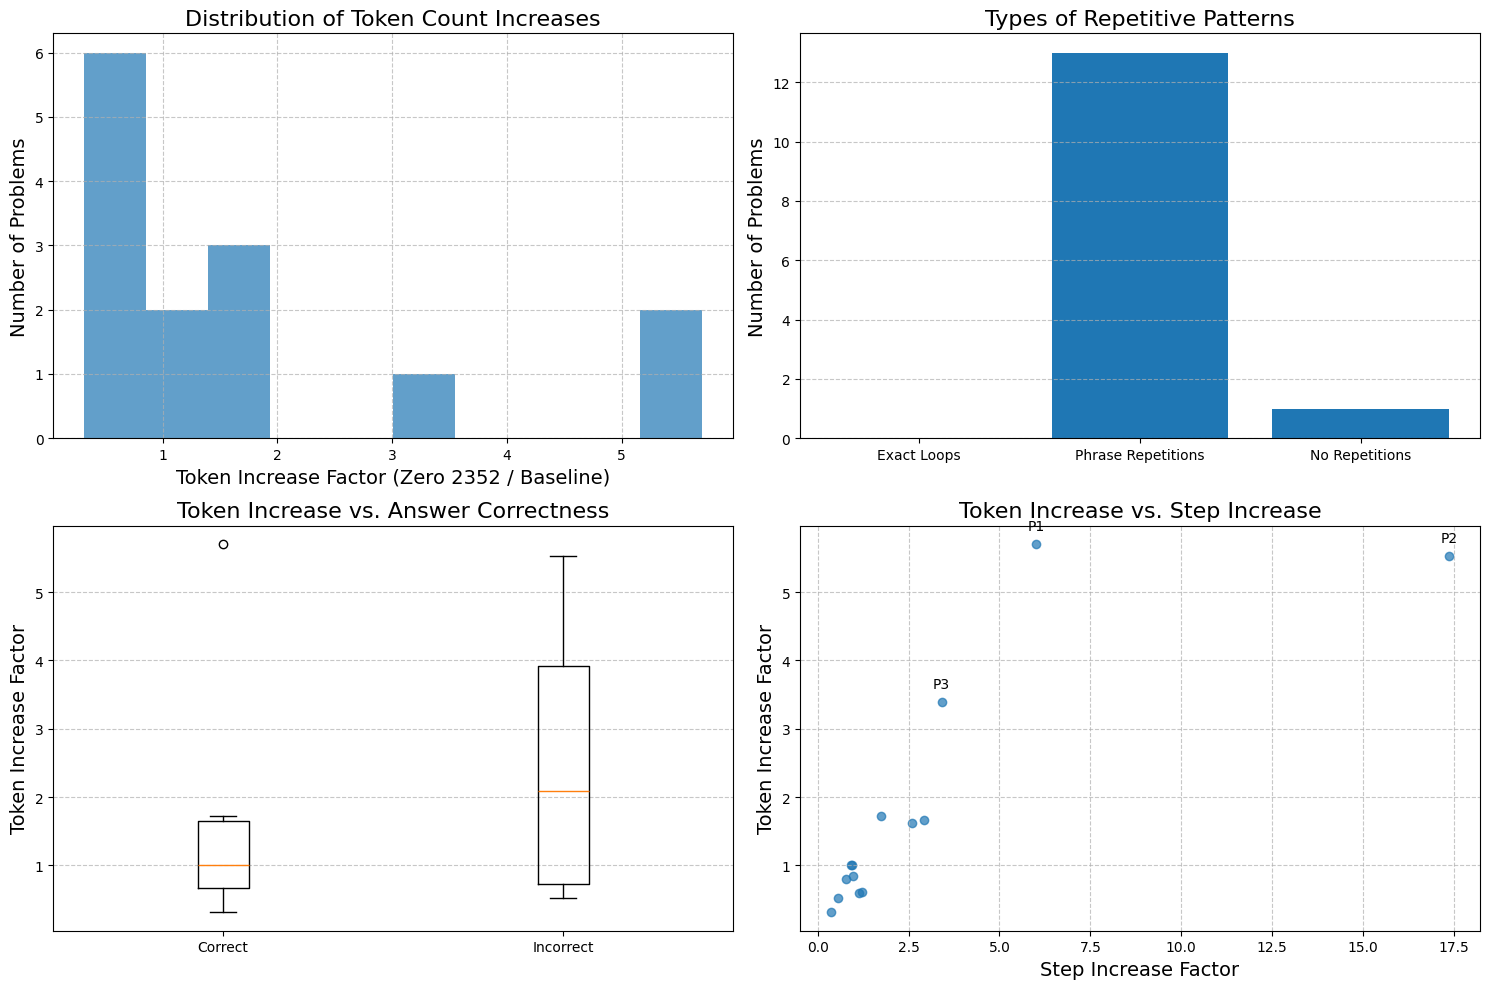

In [ ]:
#Look into repetitive patterns and token count analysis
def analyze_repetitive_patterns_across_problems(results_file):
    """
    Analyze repetitive text patterns across all problems when Feature 2352 is zeroed.
    Uses more sensitive detection methods and includes token count analysis.
    """
    # Load the results
    with open(results_file, 'r') as f:
        all_results = json.load(f)
    
    print(f"=== Repetitive Pattern Analysis When Feature 2352 is Zeroed ===")
    print(f"Analyzing {len(all_results)} problems")
    
    # Track patterns across all problems
    all_patterns = {}
    problem_stats = []
    
    # Process each problem
    for prompt_idx, (prompt, problem_results) in enumerate(all_results.items()):
        baseline = problem_results.get('Baseline (No Ablation)')
        zero_2352 = problem_results.get('Zero Feature 2352')
        
        if not baseline or not zero_2352 or 'steps' not in baseline or 'steps' not in zero_2352:
            continue
        
        baseline_steps = baseline['steps']
        zero_steps = zero_2352['steps']
        
        # Get token counts if available
        baseline_tokens = len(baseline.get('generated_text', '').split())
        zero_tokens = len(zero_2352.get('generated_text', '').split())
        
        # Calculate increases
        step_increase = len(zero_steps) / len(baseline_steps) if len(baseline_steps) > 0 else 0
        token_increase = zero_tokens / baseline_tokens if baseline_tokens > 0 else 0
        
        # Track problem stats
        problem_stat = {
            'prompt': prompt[:50] + "...",
            'baseline_steps': len(baseline_steps),
            'zero_steps': len(zero_steps),
            'baseline_tokens': baseline_tokens,
            'zero_tokens': zero_tokens,
            'step_increase': step_increase,
            'token_increase': token_increase,
            'correct': zero_2352.get('matches_ground_truth', False)
        }
        
        # Find repeating sequences (more sensitive detection)
        repetitions = []
        
        # 1. Look for exact repetitions (as before)
        for seq_length in range(1, min(10, len(zero_steps) // 2)):
            for i in range(len(zero_steps) - seq_length * 2):
                sequence = zero_steps[i:i+seq_length]
                next_sequence = zero_steps[i+seq_length:i+seq_length*2]
                
                if sequence == next_sequence:
                    # Found a repeating sequence
                    repetition = {
                        'sequence': sequence,
                        'length': seq_length,
                        'start_index': i,
                        'repetitions': 1,
                        'type': 'exact'
                    }
                    
                    # Count how many times it repeats
                    j = i + seq_length * 2
                    while j + seq_length <= len(zero_steps) and zero_steps[j:j+seq_length] == sequence:
                        repetition['repetitions'] += 1
                        j += seq_length
                    
                    repetitions.append(repetition)
        
        # 2. Look for phrase repetitions (more sensitive)
        phrase_counts = {}
        for step in zero_steps:
            # Get phrases (3-grams of words)
            words = step.split()
            for i in range(len(words) - 2):
                phrase = ' '.join(words[i:i+3])
                phrase_counts[phrase] = phrase_counts.get(phrase, 0) + 1
        
        # Find phrases that repeat significantly
        for phrase, count in phrase_counts.items():
            if count >= 5:  # Lower threshold to catch more patterns
                repetitions.append({
                    'sequence': [phrase],
                    'length': 1,
                    'repetitions': count,
                    'type': 'phrase',
                    'phrase': phrase
                })
        
        # Sort by number of repetitions
        repetitions.sort(key=lambda x: x['repetitions'], reverse=True)
        
        if repetitions:
            # Get top repetition
            top_rep = repetitions[0]
            problem_stat['has_repetition'] = True
            problem_stat['repetition_type'] = top_rep['type']
            
            if top_rep['type'] == 'exact':
                problem_stat['loop_length'] = top_rep['length']
                problem_stat['loop_repetitions'] = top_rep['repetitions']
                problem_stat['loop_sequence'] = [s[:30] + "..." for s in top_rep['sequence']]
            else:
                problem_stat['repeated_phrase'] = top_rep['phrase']
                problem_stat['phrase_repetitions'] = top_rep['repetitions']
        else:
            problem_stat['has_repetition'] = False
        
        # Count step types (first 3 words of each step)
        step_types = {}
        
        for step in zero_steps:
            # Get first few words as step type
            words = step.split()
            if len(words) >= 3:
                step_type = ' '.join(words[:3])
                step_types[step_type] = step_types.get(step_type, 0) + 1
                
                # Track across all problems
                if step_type not in all_patterns:
                    all_patterns[step_type] = {
                        'total_occurrences': 0,
                        'problem_occurrences': 0,
                        'problems': []
                    }
                
                all_patterns[step_type]['total_occurrences'] += 1
                
                if prompt_idx not in all_patterns[step_type]['problems']:
                    all_patterns[step_type]['problems'].append(prompt_idx)
                    all_patterns[step_type]['problem_occurrences'] += 1
        
        # Find most frequent step types
        frequent_types = sorted(step_types.items(), key=lambda x: x[1], reverse=True)
        if frequent_types:
            problem_stat['most_frequent_type'] = frequent_types[0][0]
            problem_stat['most_frequent_count'] = frequent_types[0][1]
            problem_stat['frequent_types'] = [(t, c) for t, c in frequent_types[:5] if c >= 3]  # Lower threshold
        
        problem_stats.append(problem_stat)
    
    # Sort problems by token increase
    problem_stats.sort(key=lambda x: x['token_increase'], reverse=True)
    
    # Print problem stats
    print("\n=== Problems Sorted by Token Increase ===")
    for i, stat in enumerate(problem_stats):
        print(f"\n{i+1}. {stat['prompt']}")
        print(f"   Baseline: {stat['baseline_tokens']} tokens, Zero 2352: {stat['zero_tokens']} tokens ({stat['token_increase']:.1f}x)")
        print(f"   Steps: {stat['baseline_steps']} → {stat['zero_steps']} ({stat['step_increase']:.1f}x)")
        print(f"   Correct answer: {'Yes' if stat['correct'] else 'No'}")
        
        if stat['has_repetition']:
            if stat['repetition_type'] == 'exact':
                print(f"   Loop detected: {stat['loop_length']} steps repeating {stat['loop_repetitions']} times")
                print(f"   Loop sequence: {' → '.join(stat['loop_sequence'])}")
            else:
                print(f"   Phrase repetition: '{stat['repeated_phrase']}' appears {stat['phrase_repetitions']} times")
        
        if 'frequent_types' in stat:
            print(f"   Most frequent patterns:")
            for t, c in stat['frequent_types']:
                print(f"     '{t}...' appears {c} times")
    
    # Find patterns that appear across multiple problems
    common_patterns = {k: v for k, v in all_patterns.items() 
                      if v['problem_occurrences'] > 1 and v['total_occurrences'] >= 5}  # Lower threshold
    
    # Sort by number of problems they appear in
    common_patterns = sorted(common_patterns.items(), 
                            key=lambda x: (x[1]['problem_occurrences'], x[1]['total_occurrences']), 
                            reverse=True)
    
    print("\n=== Common Patterns Across Problems ===")
    for pattern, stats in common_patterns[:20]:  # Top 20 patterns
        print(f"'{pattern}...' appears in {stats['problem_occurrences']} problems, {stats['total_occurrences']} total occurrences")
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # 1. Token Increase Distribution
    plt.subplot(2, 2, 1)
    token_increases = [stat['token_increase'] for stat in problem_stats]
    plt.hist(token_increases, bins=10, alpha=0.7)
    plt.title('Distribution of Token Count Increases', fontsize=16)
    plt.xlabel('Token Increase Factor (Zero 2352 / Baseline)', fontsize=14)
    plt.ylabel('Number of Problems', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 2. Repetition Types
    plt.subplot(2, 2, 2)
    exact_loops = sum(1 for stat in problem_stats if stat.get('has_repetition') and stat.get('repetition_type') == 'exact')
    phrase_reps = sum(1 for stat in problem_stats if stat.get('has_repetition') and stat.get('repetition_type') == 'phrase')
    no_reps = len(problem_stats) - exact_loops - phrase_reps
    
    plt.bar(['Exact Loops', 'Phrase Repetitions', 'No Repetitions'], [exact_loops, phrase_reps, no_reps])
    plt.title('Types of Repetitive Patterns', fontsize=16)
    plt.ylabel('Number of Problems', fontsize=14)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 3. Token Increase vs. Correctness
    plt.subplot(2, 2, 3)
    correct_increases = [stat['token_increase'] for stat in problem_stats if stat['correct']]
    incorrect_increases = [stat['token_increase'] for stat in problem_stats if not stat['correct']]
    
    plt.boxplot([correct_increases, incorrect_increases], labels=['Correct', 'Incorrect'])
    plt.title('Token Increase vs. Answer Correctness', fontsize=16)
    plt.ylabel('Token Increase Factor', fontsize=14)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 4. Token vs. Step Increase
    plt.subplot(2, 2, 4)
    plt.scatter([stat['step_increase'] for stat in problem_stats], 
                [stat['token_increase'] for stat in problem_stats], 
                alpha=0.7)
    
    # Add labels for points with high increases
    for stat in problem_stats:
        if stat['token_increase'] > 3 or stat['step_increase'] > 3:
            plt.annotate(f"P{problem_stats.index(stat)+1}", 
                        (stat['step_increase'], stat['token_increase']),
                        textcoords="offset points", 
                        xytext=(0,10), 
                        ha='center')
    
    plt.title('Token Increase vs. Step Increase', fontsize=16)
    plt.xlabel('Step Increase Factor', fontsize=14)
    plt.ylabel('Token Increase Factor', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('repetitive_patterns_analysis.png')
    plt.show()
    
    return {
        'problem_stats': problem_stats,
        'common_patterns': common_patterns
    }

# Run the analysis
pattern_analysis = analyze_repetitive_patterns_across_problems('ablation_results_all_correct_seed_42.json')

=== Repetitive Pattern Analysis When Feature 2352 is Zeroed ===
Analyzing 14 problems

=== Problems Sorted by Phrase Repetition Increase ===

1. After 10 minutes, A, B, and C were in that order i...
   Baseline: 304 steps, 6365 tokens
   Zero 2352: 5280 steps (17.4x), 35198 tokens (5.5x)
   Correct answer when 2352 zeroed: No
   Phrase repetition increase: 8.2x
   Baseline top phrase: 'the number of' appears 34 times
   Zero 2352 top phrase: 'Thus, spot rider' appears 4868 times
   Exact loop detected: 2 steps repeating 120 times
   Loop sequence: Thus, spot rider falls further... → Thus, spot rider is being over...
   Baseline most frequent patterns:
     'Given that the...' appears 5 times
     'But the problem...' appears 5 times
     'Alternatively, perhaps the...' appears 4 times
     'Given that rider...' appears 4 times
     'Alternatively, maybe the...' appears 4 times
   Zero 2352 most frequent patterns:
     'Thus, spot rider...' appears 4867 times
     'Similarly, the rider.

/var/folders/f9/q60hmfgd2lx3_mpq6kwg9_980000gn/T/ipykernel_65706/252693630.py:254: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_increases, incorrect_increases], labels=['Correct', 'Incorrect'])


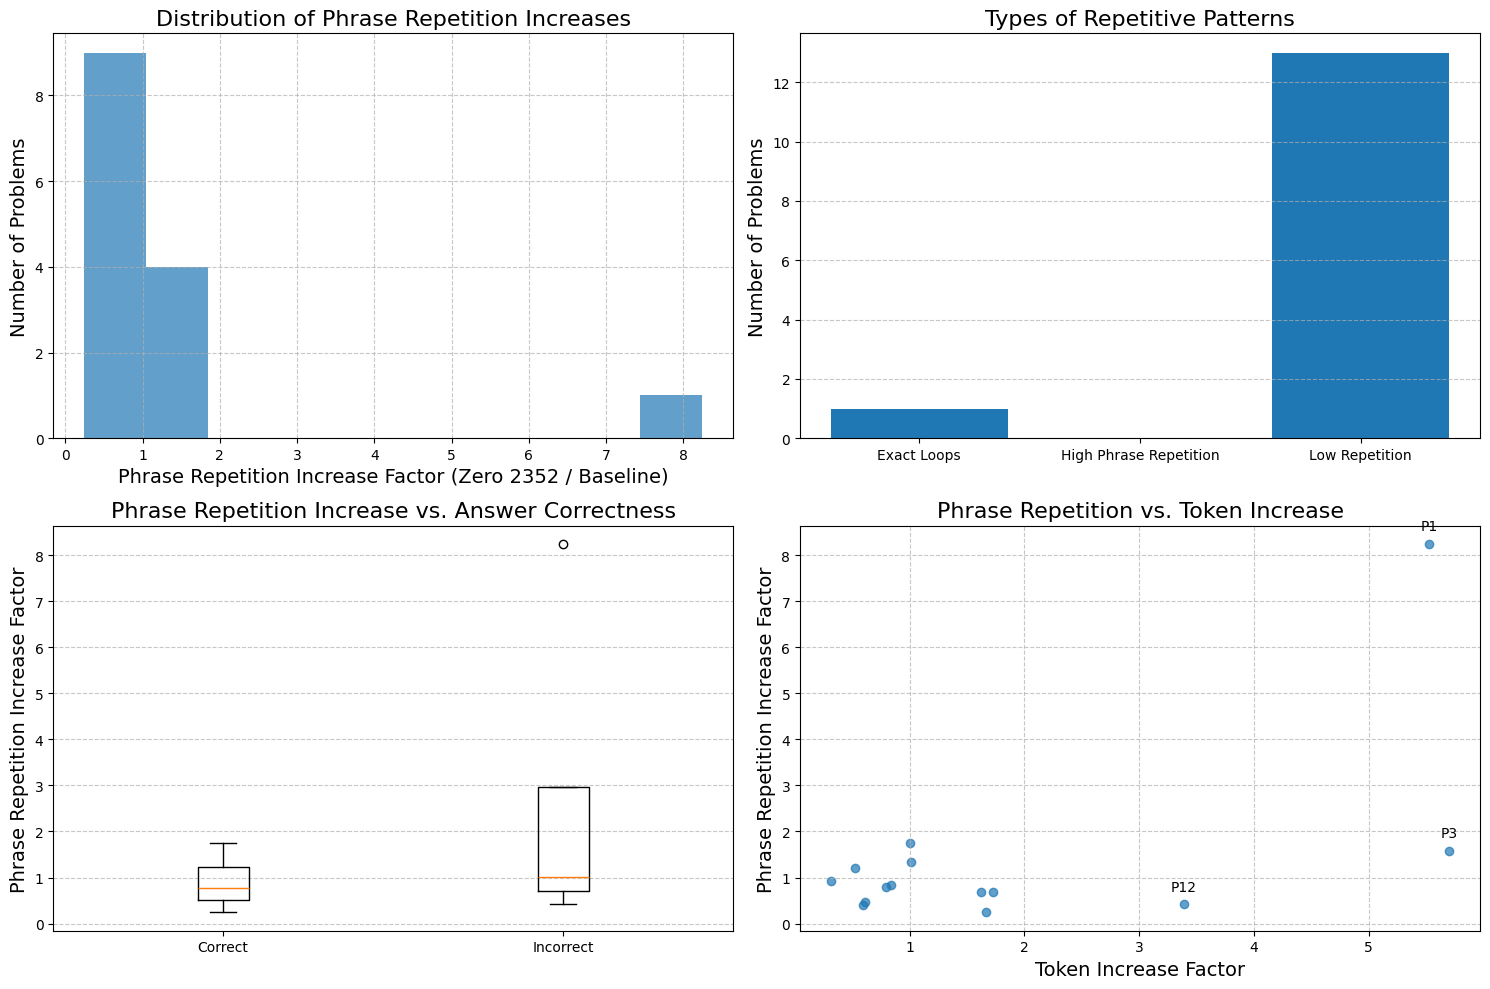

In [ ]:
#Look at repetitive patterns that appear when 2352 is zeroed
def analyze_repetitive_patterns_across_problems(results_file):
    """
    Analyze repetitive text patterns across all problems when Feature 2352 is zeroed.
    Compare phrase repetition between baseline and zeroed conditions.
    """
    # Load the results
    with open(results_file, 'r') as f:
        all_results = json.load(f)
    
    print(f"=== Repetitive Pattern Analysis When Feature 2352 is Zeroed ===")
    print(f"Analyzing {len(all_results)} problems")
    
    # Track patterns across all problems
    all_patterns = {}
    problem_stats = []
    
    # Process each problem
    for prompt_idx, (prompt, problem_results) in enumerate(all_results.items()):
        baseline = problem_results.get('Baseline (No Ablation)')
        zero_2352 = problem_results.get('Zero Feature 2352')
        
        if not baseline or not zero_2352 or 'steps' not in baseline or 'steps' not in zero_2352:
            continue
        
        baseline_steps = baseline['steps']
        zero_steps = zero_2352['steps']
        
        # Get token counts if available
        baseline_tokens = len(baseline.get('generated_text', '').split())
        zero_tokens = len(zero_2352.get('generated_text', '').split())
        
        # Calculate increases
        step_increase = len(zero_steps) / len(baseline_steps) if len(baseline_steps) > 0 else 0
        token_increase = zero_tokens / baseline_tokens if baseline_tokens > 0 else 0
        
        # Track problem stats
        problem_stat = {
            'prompt': prompt[:50] + "...",
            'baseline_steps': len(baseline_steps),
            'zero_steps': len(zero_steps),
            'baseline_tokens': baseline_tokens,
            'zero_tokens': zero_tokens,
            'step_increase': step_increase,
            'token_increase': token_increase,
            'correct': zero_2352.get('matches_ground_truth', False)
        }
        
        # Find repeating sequences (exact repetitions)
        repetitions = []
        
        for seq_length in range(1, min(10, len(zero_steps) // 2)):
            for i in range(len(zero_steps) - seq_length * 2):
                sequence = zero_steps[i:i+seq_length]
                next_sequence = zero_steps[i+seq_length:i+seq_length*2]
                
                if sequence == next_sequence:
                    # Found a repeating sequence
                    repetition = {
                        'sequence': sequence,
                        'length': seq_length,
                        'start_index': i,
                        'repetitions': 1,
                        'type': 'exact'
                    }
                    
                    # Count how many times it repeats
                    j = i + seq_length * 2
                    while j + seq_length <= len(zero_steps) and zero_steps[j:j+seq_length] == sequence:
                        repetition['repetitions'] += 1
                        j += seq_length
                    
                    repetitions.append(repetition)
        
        # Sort by number of repetitions
        repetitions.sort(key=lambda x: x['repetitions'], reverse=True)
        
        if repetitions:
            # Get top repetition
            top_rep = repetitions[0]
            problem_stat['has_exact_loop'] = True
            problem_stat['loop_length'] = top_rep['length']
            problem_stat['loop_repetitions'] = top_rep['repetitions']
            problem_stat['loop_sequence'] = [s[:30] + "..." for s in top_rep['sequence']]
        else:
            problem_stat['has_exact_loop'] = False
        
        # Count phrase repetitions in baseline
        baseline_phrase_counts = {}
        for step in baseline_steps:
            # Get phrases (3-grams of words)
            words = step.split()
            for i in range(len(words) - 2):
                phrase = ' '.join(words[i:i+3])
                baseline_phrase_counts[phrase] = baseline_phrase_counts.get(phrase, 0) + 1
        
        # Count phrase repetitions in zeroed
        zero_phrase_counts = {}
        for step in zero_steps:
            # Get phrases (3-grams of words)
            words = step.split()
            for i in range(len(words) - 2):
                phrase = ' '.join(words[i:i+3])
                zero_phrase_counts[phrase] = zero_phrase_counts.get(phrase, 0) + 1
        
        # Find most repeated phrases in baseline
        baseline_top_phrases = sorted(baseline_phrase_counts.items(), key=lambda x: x[1], reverse=True)
        
        # Find most repeated phrases in zeroed
        zero_top_phrases = sorted(zero_phrase_counts.items(), key=lambda x: x[1], reverse=True)
        
        # Store top phrases
        if baseline_top_phrases:
            problem_stat['baseline_top_phrase'] = baseline_top_phrases[0][0]
            problem_stat['baseline_top_count'] = baseline_top_phrases[0][1]
            problem_stat['baseline_top_phrases'] = [(p, c) for p, c in baseline_top_phrases[:5] if c >= 3]
        
        if zero_top_phrases:
            problem_stat['zero_top_phrase'] = zero_top_phrases[0][0]
            problem_stat['zero_top_count'] = zero_top_phrases[0][1]
            problem_stat['zero_top_phrases'] = [(p, c) for p, c in zero_top_phrases[:5] if c >= 3]
        
        # Calculate phrase repetition increase
        if baseline_top_phrases and zero_top_phrases:
            baseline_max_count = baseline_top_phrases[0][1]
            zero_max_count = zero_top_phrases[0][1]
            
            # Normalize by number of steps
            baseline_norm = baseline_max_count / len(baseline_steps)
            zero_norm = zero_max_count / len(zero_steps)
            
            if baseline_norm > 0:
                problem_stat['phrase_repetition_increase'] = zero_norm / baseline_norm
        
        # Count step types (first 3 words of each step)
        baseline_step_types = {}
        for step in baseline_steps:
            # Get first few words as step type
            words = step.split()
            if len(words) >= 3:
                step_type = ' '.join(words[:3])
                baseline_step_types[step_type] = baseline_step_types.get(step_type, 0) + 1
        
        zero_step_types = {}
        for step in zero_steps:
            # Get first few words as step type
            words = step.split()
            if len(words) >= 3:
                step_type = ' '.join(words[:3])
                zero_step_types[step_type] = zero_step_types.get(step_type, 0) + 1
                
                # Track across all problems
                if step_type not in all_patterns:
                    all_patterns[step_type] = {
                        'total_occurrences': 0,
                        'problem_occurrences': 0,
                        'problems': []
                    }
                
                all_patterns[step_type]['total_occurrences'] += 1
                
                if prompt_idx not in all_patterns[step_type]['problems']:
                    all_patterns[step_type]['problems'].append(prompt_idx)
                    all_patterns[step_type]['problem_occurrences'] += 1
        
        # Find most frequent step types
        baseline_frequent_types = sorted(baseline_step_types.items(), key=lambda x: x[1], reverse=True)
        zero_frequent_types = sorted(zero_step_types.items(), key=lambda x: x[1], reverse=True)
        
        if baseline_frequent_types:
            problem_stat['baseline_most_frequent_type'] = baseline_frequent_types[0][0]
            problem_stat['baseline_most_frequent_count'] = baseline_frequent_types[0][1]
            problem_stat['baseline_frequent_types'] = [(t, c) for t, c in baseline_frequent_types[:5] if c >= 3]
        
        if zero_frequent_types:
            problem_stat['zero_most_frequent_type'] = zero_frequent_types[0][0]
            problem_stat['zero_most_frequent_count'] = zero_frequent_types[0][1]
            problem_stat['zero_frequent_types'] = [(t, c) for t, c in zero_frequent_types[:5] if c >= 3]
        
        problem_stats.append(problem_stat)
    
    # Sort problems by phrase repetition increase
    problem_stats.sort(key=lambda x: x.get('phrase_repetition_increase', 0), reverse=True)
    
    # Print problem stats
    print("\n=== Problems Sorted by Phrase Repetition Increase ===")
    for i, stat in enumerate(problem_stats):
        print(f"\n{i+1}. {stat['prompt']}")
        print(f"   Baseline: {stat['baseline_steps']} steps, {stat['baseline_tokens']} tokens")
        print(f"   Zero 2352: {stat['zero_steps']} steps ({stat['step_increase']:.1f}x), {stat['zero_tokens']} tokens ({stat['token_increase']:.1f}x)")
        print(f"   Correct answer when 2352 zeroed: {'Yes' if stat['correct'] else 'No'}")
        
        if 'phrase_repetition_increase' in stat:
            print(f"   Phrase repetition increase: {stat['phrase_repetition_increase']:.1f}x")
        
        if 'baseline_top_phrase' in stat and 'zero_top_phrase' in stat:
            print(f"   Baseline top phrase: '{stat['baseline_top_phrase']}' appears {stat['baseline_top_count']} times")
            print(f"   Zero 2352 top phrase: '{stat['zero_top_phrase']}' appears {stat['zero_top_count']} times")
        
        if stat.get('has_exact_loop', False):
            print(f"   Exact loop detected: {stat['loop_length']} steps repeating {stat['loop_repetitions']} times")
            print(f"   Loop sequence: {' → '.join(stat['loop_sequence'])}")
        
        if 'baseline_frequent_types' in stat:
            print(f"   Baseline most frequent patterns:")
            for t, c in stat['baseline_frequent_types']:
                print(f"     '{t}...' appears {c} times")
        
        if 'zero_frequent_types' in stat:
            print(f"   Zero 2352 most frequent patterns:")
            for t, c in stat['zero_frequent_types']:
                print(f"     '{t}...' appears {c} times")
    
    # Find patterns that appear across multiple problems
    common_patterns = {k: v for k, v in all_patterns.items() 
                      if v['problem_occurrences'] > 1 and v['total_occurrences'] >= 5}
    
    # Sort by number of problems they appear in
    common_patterns = sorted(common_patterns.items(), 
                            key=lambda x: (x[1]['problem_occurrences'], x[1]['total_occurrences']), 
                            reverse=True)
    
    print("\n=== Common Patterns Across Problems When Feature 2352 is Zeroed ===")
    for pattern, stats in common_patterns[:20]:  # Top 20 patterns
        print(f"'{pattern}...' appears in {stats['problem_occurrences']} problems, {stats['total_occurrences']} total occurrences")
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # 1. Phrase Repetition Increase Distribution
    plt.subplot(2, 2, 1)
    repetition_increases = [stat.get('phrase_repetition_increase', 0) for stat in problem_stats if 'phrase_repetition_increase' in stat]
    plt.hist(repetition_increases, bins=10, alpha=0.7)
    plt.title('Distribution of Phrase Repetition Increases', fontsize=16)
    plt.xlabel('Phrase Repetition Increase Factor (Zero 2352 / Baseline)', fontsize=14)
    plt.ylabel('Number of Problems', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 2. Repetition Types
    plt.subplot(2, 2, 2)
    exact_loops = sum(1 for stat in problem_stats if stat.get('has_exact_loop', False))
    high_phrase_rep = sum(1 for stat in problem_stats if stat.get('phrase_repetition_increase', 0) > 2 and not stat.get('has_exact_loop', False))
    low_rep = len(problem_stats) - exact_loops - high_phrase_rep
    
    plt.bar(['Exact Loops', 'High Phrase Repetition', 'Low Repetition'], [exact_loops, high_phrase_rep, low_rep])
    plt.title('Types of Repetitive Patterns', fontsize=16)
    plt.ylabel('Number of Problems', fontsize=14)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 3. Phrase Repetition vs. Correctness
    plt.subplot(2, 2, 3)
    correct_increases = [stat.get('phrase_repetition_increase', 0) for stat in problem_stats if stat['correct'] and 'phrase_repetition_increase' in stat]
    incorrect_increases = [stat.get('phrase_repetition_increase', 0) for stat in problem_stats if not stat['correct'] and 'phrase_repetition_increase' in stat]
    
    plt.boxplot([correct_increases, incorrect_increases], labels=['Correct', 'Incorrect'])
    plt.title('Phrase Repetition Increase vs. Answer Correctness', fontsize=16)
    plt.ylabel('Phrase Repetition Increase Factor', fontsize=14)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 4. Phrase Repetition vs. Token Increase
    plt.subplot(2, 2, 4)
    plt.scatter([stat['token_increase'] for stat in problem_stats if 'phrase_repetition_increase' in stat], 
                [stat.get('phrase_repetition_increase', 0) for stat in problem_stats if 'phrase_repetition_increase' in stat], 
                alpha=0.7)
    
    # Add labels for points with high increases
    for stat in problem_stats:
        if stat.get('phrase_repetition_increase', 0) > 5 or stat['token_increase'] > 3:
            plt.annotate(f"P{problem_stats.index(stat)+1}", 
                        (stat['token_increase'], stat.get('phrase_repetition_increase', 0)),
                        textcoords="offset points", 
                        xytext=(0,10), 
                        ha='center')
    
    plt.title('Phrase Repetition vs. Token Increase', fontsize=16)
    plt.xlabel('Token Increase Factor', fontsize=14)
    plt.ylabel('Phrase Repetition Increase Factor', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('repetitive_patterns_comparison.png')
    plt.show()
    
    return {
        'problem_stats': problem_stats,
        'common_patterns': common_patterns
    }

# Run the analysis
pattern_analysis = analyze_repetitive_patterns_across_problems('ablation_results_all_correct_seed_42.json')

=== Feature Compensation Analysis When Feature 2352 is Zeroed ===
Analyzing 14 problems

Top 10 features that compensate when Feature 2352 is zeroed:
Feature 2932 (positive): 17.6x increase, appears in 5 problems
Feature 2298 (positive): 6.3x increase, appears in 1 problems
Feature 2330 (negative): 6.0x increase, appears in 4 problems
Feature 3869 (negative): 5.7x increase, appears in 1 problems
Feature 3139 (positive): 5.0x increase, appears in 4 problems
Feature 2929 (negative): 5.0x increase, appears in 1 problems
Feature 3881 (negative): 4.6x increase, appears in 5 problems
Feature 2742 (positive): 4.5x increase, appears in 8 problems
Feature 2219 (positive): 4.4x increase, appears in 4 problems
Feature 1856 (negative): 4.3x increase, appears in 5 problems


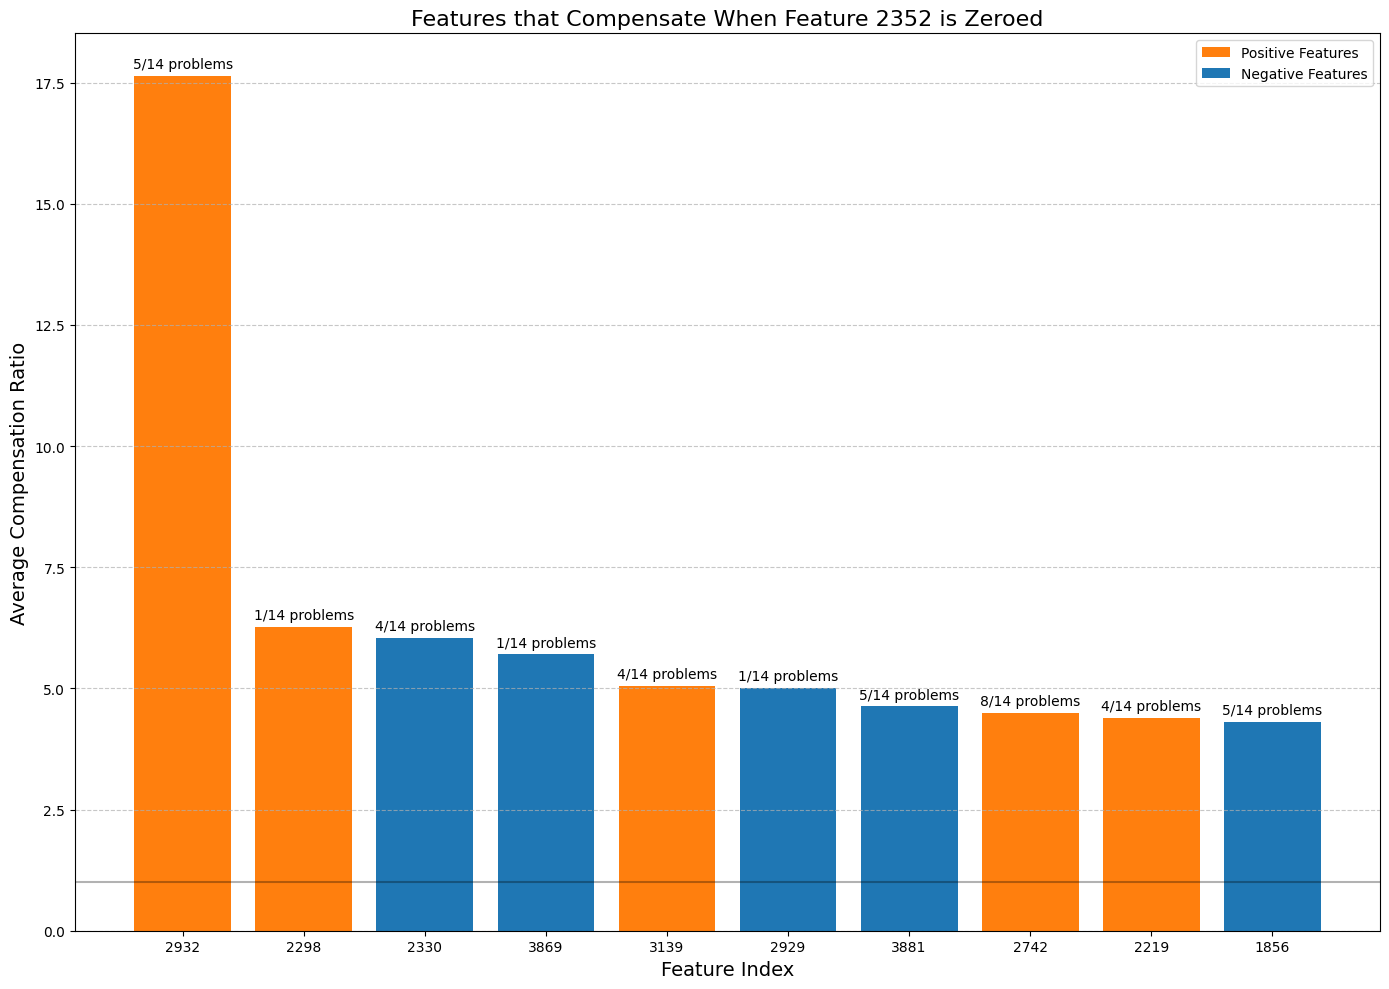

<Figure size 1400x1000 with 0 Axes>

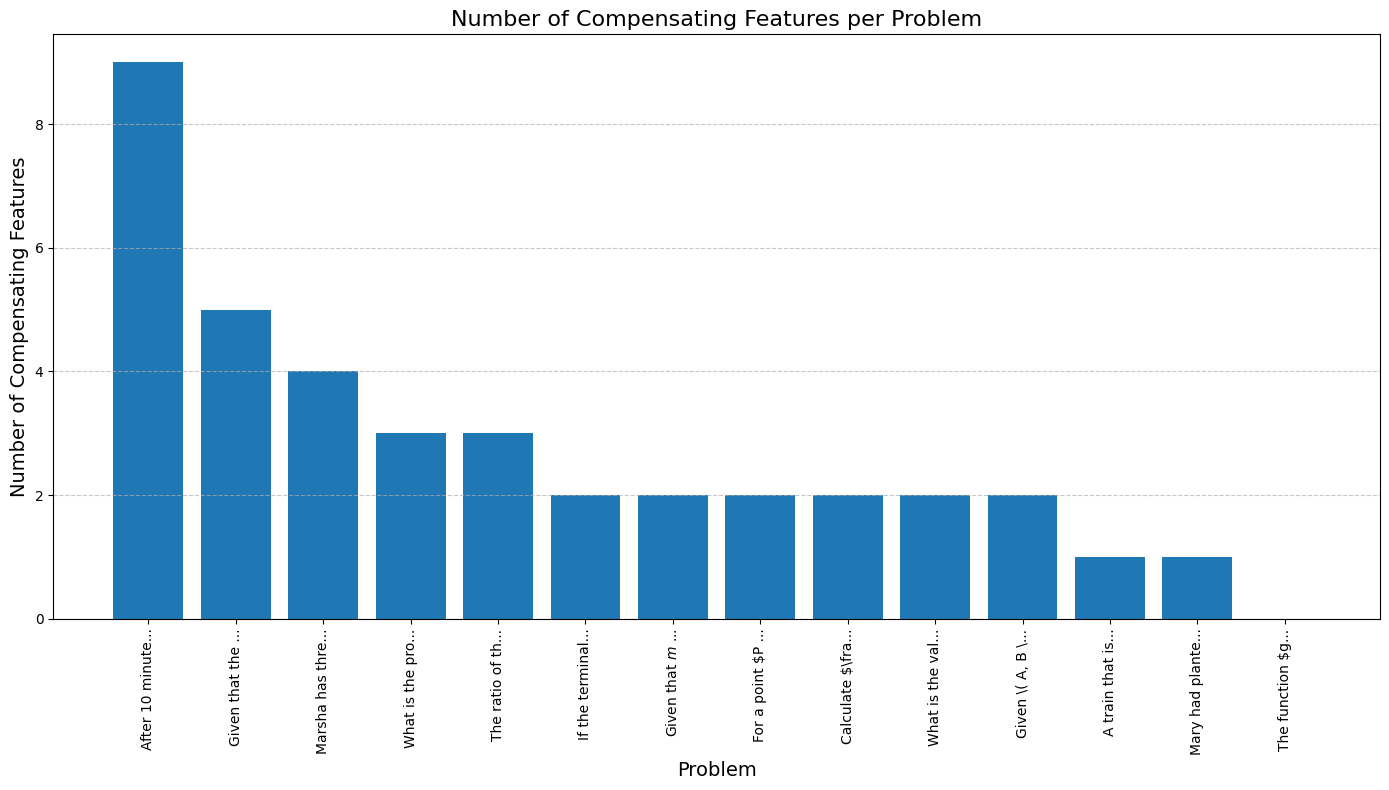

In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def plot_feature_compensation_for_2352(results_file, top_n=10, figsize=(14, 10)):
    """
    Create a focused graph showing only the features that compensate when Feature 2352 is zeroed,
    with enhanced visualization to show problem distribution.
    
    Args:
        results_file: Path to the results JSON file
        top_n: Number of top compensating features to show
        figsize: Size of the figure
    """
    # Load the results
    with open(results_file, 'r') as f:
        all_results = json.load(f)
    
    print(f"=== Feature Compensation Analysis When Feature 2352 is Zeroed ===")
    print(f"Analyzing {len(all_results)} problems")
    
    # Track compensation patterns
    all_feature_changes = {}
    
    # Track which problems each feature appears in
    feature_problems = {}
    
    # Keep track of all problems for later analysis
    all_problems = []
    
    # Process each problem
    problem_count = 0
    for prompt, problem_results in all_results.items():
        # Get baseline and zeroed results
        baseline = problem_results.get('Baseline (No Ablation)')
        zero_2352 = problem_results.get('Zero Feature 2352')
        
        if not baseline or not zero_2352 or 'step_features' not in baseline or 'step_features' not in zero_2352:
            continue
            
        problem_count += 1
        all_problems.append(prompt)
        
        # Count features in baseline
        baseline_features = {
            'positive': {},
            'negative': {}
        }
        
        for step_feature in baseline['step_features']:
            # Process top positive features
            for feat in step_feature['top_positive_features']:
                feat_idx = feat['index']
                if feat_idx not in baseline_features['positive']:
                    baseline_features['positive'][feat_idx] = 0
                baseline_features['positive'][feat_idx] += 1
            
            # Process top negative features
            for feat in step_feature['top_negative_features']:
                feat_idx = feat['index']
                if feat_idx not in baseline_features['negative']:
                    baseline_features['negative'][feat_idx] = 0
                baseline_features['negative'][feat_idx] += 1
        
        # Count features in zeroed condition
        zero_features = {
            'positive': {},
            'negative': {}
        }
        
        for step_feature in zero_2352['step_features']:
            # Process top positive features
            for feat in step_feature['top_positive_features']:
                feat_idx = feat['index']
                if feat_idx not in zero_features['positive']:
                    zero_features['positive'][feat_idx] = 0
                zero_features['positive'][feat_idx] += 1
            
            # Process top negative features
            for feat in step_feature['top_negative_features']:
                feat_idx = feat['index']
                if feat_idx not in zero_features['negative']:
                    zero_features['negative'][feat_idx] = 0
                zero_features['negative'][feat_idx] += 1
        
        # Find features that became more prominent
        for feat_type in ['positive', 'negative']:
            for feat_idx, count in zero_features[feat_type].items():
                # Skip Feature 2352 itself
                if feat_idx == 2352:
                    continue
                    
                # Get baseline count for this feature
                baseline_count = baseline_features[feat_type].get(feat_idx, 0)
                
                # Calculate change ratio
                if baseline_count > 0:
                    # Normalize by number of steps
                    baseline_norm = baseline_count / len(baseline['step_features'])
                    zero_norm = count / len(zero_2352['step_features'])
                    
                    # Calculate change ratio
                    change_ratio = zero_norm / baseline_norm
                    
                    # Only track significant increases
                    if change_ratio > 1.5:  # 50% increase threshold
                        # Store in aggregated changes
                        if feat_idx not in all_feature_changes:
                            all_feature_changes[feat_idx] = {
                                'type': feat_type,
                                'ratios': [],
                                'problems': set(),
                                'problem_ratios': {}
                            }
                        
                        all_feature_changes[feat_idx]['ratios'].append(change_ratio)
                        all_feature_changes[feat_idx]['problems'].add(prompt)
                        all_feature_changes[feat_idx]['problem_ratios'][prompt] = change_ratio
    
    # Calculate average compensation ratios
    avg_compensation = {}
    for feat_idx, data in all_feature_changes.items():
        if data['ratios']:
            avg_compensation[feat_idx] = {
                'type': data['type'],
                'avg_ratio': sum(data['ratios']) / len(data['ratios']),
                'problem_count': len(data['problems']),
                'problems': data['problems'],
                'problem_ratios': data['problem_ratios']
            }
    
    # Find features with biggest average changes
    significant_changes = []
    for feat_idx, data in avg_compensation.items():
        if data['avg_ratio'] > 1.5:  # Only include features that increase by at least 50%
            significant_changes.append((feat_idx, data['type'], data['avg_ratio'], data['problem_count'], data['problems'], data['problem_ratios']))
    
    # Sort by magnitude of change
    significant_changes.sort(key=lambda x: x[2], reverse=True)
    
    # Take top N
    top_compensating = significant_changes[:top_n]
    
    print(f"\nTop {len(top_compensating)} features that compensate when Feature 2352 is zeroed:")
    for feat_idx, feat_type, ratio, count, problems, _ in top_compensating:
        print(f"Feature {feat_idx} ({feat_type}): {ratio:.1f}x increase, appears in {count} problems")
    
    # Create visualization
    plt.figure(figsize=figsize)
    
    # Prepare data for plotting
    feat_indices = [str(idx) for idx, _, _, _, _, _ in top_compensating]
    ratios = [ratio for _, _, ratio, _, _, _ in top_compensating]
    types = [typ for _, typ, _, _, _, _ in top_compensating]
    problem_counts = [count for _, _, _, count, _, _ in top_compensating]
    all_problem_ratios = [prob_ratios for _, _, _, _, _, prob_ratios in top_compensating]
    
    # Create colors based on feature type
    colors = ['#ff7f0e' if t == 'positive' else '#1f77b4' for t in types]
    
    # Plot the data
    bars = plt.bar(range(len(feat_indices)), ratios, color=colors)
    
    # Add problem count labels above bars
    for i, count in enumerate(problem_counts):
        plt.text(i, ratios[i] + 0.1, f"{count}/{problem_count} problems", 
                 ha='center', va='bottom', fontsize=10)
    
    # Add a horizontal line at y=1 (no change)
    plt.axhline(y=1.0, color='black', linestyle='-', alpha=0.3)
    
    # Add title and labels
    plt.title('Features that Compensate When Feature 2352 is Zeroed', fontsize=16)
    plt.xlabel('Feature Index', fontsize=14)
    plt.ylabel('Average Compensation Ratio', fontsize=14)
    plt.xticks(range(len(feat_indices)), feat_indices)
    
    # Add legend for feature types
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#ff7f0e', label='Positive Features'),
        Patch(facecolor='#1f77b4', label='Negative Features')
    ]
    plt.legend(handles=legend_elements)
    
    # Add grid
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout for the first plot
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('feature_compensation_for_2352.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Create a second visualization showing problem distribution
    plt.figure(figsize=(14, 10))
    
    # Create a matrix of which problems each feature appears in
    problem_matrix = np.zeros((len(top_compensating), problem_count))
    
    # Short problem names for display
    short_problem_names = [p[:15] + "..." for p in all_problems]
    
    # Fill the matrix
    for i, (_, _, _, _, problems, problem_ratios) in enumerate(top_compensating):
        for j, problem in enumerate(all_problems):
            if problem in problems:
                problem_matrix[i, j] = problem_ratios.get(problem, 0)
    
    # Create a heatmap
    plt.figure(figsize=(16, 8))
    
    # Use a custom colormap that starts at white for 0
    from matplotlib.colors import LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list('custom_cmap', ['white', '#ff7f0e'], N=100)
    
    # Plot the heatmap
    im = plt.imshow(problem_matrix, cmap=cmap, aspect='auto')
    
    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label('Compensation Ratio', fontsize=12)
    
    # Add feature labels on y-axis
    plt.yticks(range(len(feat_indices)), [f"Feature {idx}" for idx in feat_indices])
    
    # Add problem labels on x-axis (rotated for readability)
    plt.xticks(range(len(short_problem_names)), short_problem_names, rotation=90)
    
    # Add title
    plt.title('Problem Distribution of Compensating Features', fontsize=16)
    
    # Add grid
    plt.grid(False)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('feature_compensation_problem_distribution.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Create a third visualization: stacked bar chart showing problem distribution
    plt.figure(figsize=(14, 8))
    
    # Count how many features appear in each problem
    problem_feature_counts = [0] * problem_count
    for _, _, _, _, problems, _ in top_compensating:
        for j, problem in enumerate(all_problems):
            if problem in problems:
                problem_feature_counts[j] += 1
    
    # Sort problems by feature count
    sorted_indices = np.argsort(problem_feature_counts)[::-1]
    sorted_problems = [all_problems[i] for i in sorted_indices]
    sorted_counts = [problem_feature_counts[i] for i in sorted_indices]
    sorted_short_names = [short_problem_names[i] for i in sorted_indices]
    
    # Plot the bar chart
    plt.bar(range(len(sorted_short_names)), sorted_counts)
    
    # Add labels
    plt.title('Number of Compensating Features per Problem', fontsize=16)
    plt.xlabel('Problem', fontsize=14)
    plt.ylabel('Number of Compensating Features', fontsize=14)
    plt.xticks(range(len(sorted_short_names)), sorted_short_names, rotation=90)
    
    # Add grid
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('problem_feature_distribution.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return {
        'top_compensating': top_compensating,
        'avg_compensation': avg_compensation,
        'problem_matrix': problem_matrix
    }

# Run the analysis
compensation_results = plot_feature_compensation_for_2352('ablation_results_all_correct_seed_42.json', top_n=10)